In [1]:
from tools_stance import * 
from models import *
from transformer_class import *
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Input
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical
from keras.preprocessing.sequence import pad_sequences
import os 
import torch 
import gc
import pandas as pd

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

dict_cl=dict()
dict_cl[0]="support"
dict_cl[1]="denying"
dict_cl[2]="questioning"
dict_cl[3]="commenting"

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

keys=["commenting", "support", "denying", "questioning"]

path="../../../Datasets/CSV_Stance/"
train =pd.read_csv(path + "train_semeval_raw.csv")
val=pd.read_csv(path + "dev_semeval_raw.csv")
test=pd.read_csv(path + "test_semeval_raw.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl


embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../../../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


(1193513, 200)

In [2]:
def cm_norma(matrix):
    return matrix/matrix.sum(axis=-1, keepdims=True)

def plot_cm(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2.# if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def data_gen(batch_size,mode,n_machines,new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings):  
    """ESTA FUNCION DEBERÁ RETORNAR MATRICES DE TAMAÑO BATCH_SIZE * TW,M1,M2,M3,M4,M5,M6
    CADA EJEMPLO DEBERÁ SER ESTILO [ID_T, 1,2,1,2,1,2] SIENDO 1 CUANDO LA CLASE PREDICHA ES LA 0
    2 PARA CLASE PREDICHA 1, ETC. ID_T DEBEŔA INICIAR EN 5 PARA REFERIRSE AL PRIMER TW (EL PRIMERO DE TRAIN)"""
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=matrix.shape[1]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)        #indices desordenados de seccion train
        objs=ids_train
        labels=etiq     #np.load("matrices/y_train_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8')
    if mode=='Val':
        max_objs=matrix_val.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1] for x in x_list]   
        #np.random.shuffle(x_list)        #indices desordenados de seccion val
        objs=val['Tw_id']    #df_val['Unnamed: 0'].values        
        labels=np.asarray(etiq_v)     #np.load("matrices/y_val_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8') 
    if mode=='Test':
        max_objs=matrix_test.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1]+matrix_val.shape[1] for x in x_list]
        total=matrix.shape[1]+matrix_val.shape[1]
        objs=test['Tw_id']     #np.arange(total, total+max_objs)
        
    #----------------------------------- COMPLETA MINI BATCHES ----------------------    
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
    #print ("los indices de train k voy a acceder random son", x_data[0])
            
    #-------------------------------- CONSTRUCCION MINI BATCHES (X,Y)----------------------   
    new_x_data=[] 
    for batch in x_data:
        #print ("transformando batch", batch)
        temp=[]
        for pos in batch:
            #print("en especifico el numerito", pos)
            temp2=[index_embeddings[pos+5]]#fromId2num[objs[exam]]] ### obj evaluado en maquinas  
            #print ("me dice que es el embed en index", temp2)
            for m in range(n_machines): 
                #print ("machine ",m,"dice:", np.argmax(new_matrix[m][pos])+1)
                temp2= temp2 + [np.argmax(new_matrix[m][pos])+1] 
                #matrix[4][cosa-5])+1)
            temp.append(temp2)
        new_x_data.append(temp)   

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for conjunto in range(len(new_x_data)):
            batch=new_x_data[conjunto]
            temp_y=[]
            for linea in range(len(batch)):
                indice=x_data[conjunto][linea]  #pos
                lab=d_lab[lab_str_embeddings[indice+5]]+1 #labels_train
                temp_y.append([lab])       
            y_data.append(temp_y)
            
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    #print ("primer batch X.Y", new_x_data[0], y_data[0])
    if mode=='Test':
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)        
    else:          
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)
            

def make_model_concat(target, K_list_new, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                #print ("batch.src_mask en run epoch", batch.src_mask)
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
                #la loss del batch es sobre todos los ejemplos o es promedio en batch?
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            #print ("BATCH\n", i, '\n', batch.src)
            out = model.forward(batch.src, batch.src_mask)
            #print ("OUT DE RUN EPOCH", out)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0    #4 clases (macro)
            total_fs += f1                 #none  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last

def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq, trainPredict))
    """print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq_v, trainPredict))
    """print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=cm_norma(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ": %.3f" % acc_t)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma_t)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [3]:
MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
    
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= np.asarray([1.0, 1.0, 1.0, 1.0])
print ("Pesos de clases:", class_weights)

ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

Pesos de clases: [1. 1. 1. 1.]


In [4]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [5]:
path_m='../../../Datasets/Models_Stance/'

etiq=np.asarray(labels_train)
etiq_v=np.asarray(labels_val)
etiq_t=np.asarray(labels_test)

In [6]:
from bert_serving.client import BertClient
import seaborn 

def draw(data, ax, label, color="Blues"):
    seaborn.heatmap(data, 
                    xticklabels=label[0], square=True, yticklabels=label[0], vmin=0.0, vmax=1.0, 
                    cbar=False,  cmap=color, ax=ax)

#sns.heatmap(matriz_attn, xticklabels=label[0], yticklabels=label[0],
#                    vmin=0.0, vmax=1.0, linewidths=.5, cmap="Blues", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
#    plt.show()
    
bc = BertClient()  

In [7]:
n_machines=5

Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.219 	F-macro_val: 0.167
Epoch 10 	acc_val: 0.639 	F-macro_val: 0.269
Epoch 20 	acc_val: 0.694 	F-macro_val: 0.351
Epoch 30 	acc_val: 0.719 	F-macro_val: 0.443
Epoch 40 	acc_val: 0.715 	F-macro_val: 0.443
Epoch 50 	acc_val: 0.726 	F-macro_val: 0.448
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


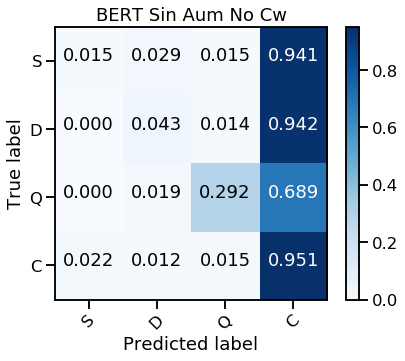

Test_ acc: 0.7590597453476984
Test_ f1 none: [0.02325581 0.07058824 0.41059603 0.86046512]
Test_ f1 macro: 0.34122629800418547


Ejemplo de tweet con label  commenting  y Tw_id  524943390816079872
Encoder Layer 1


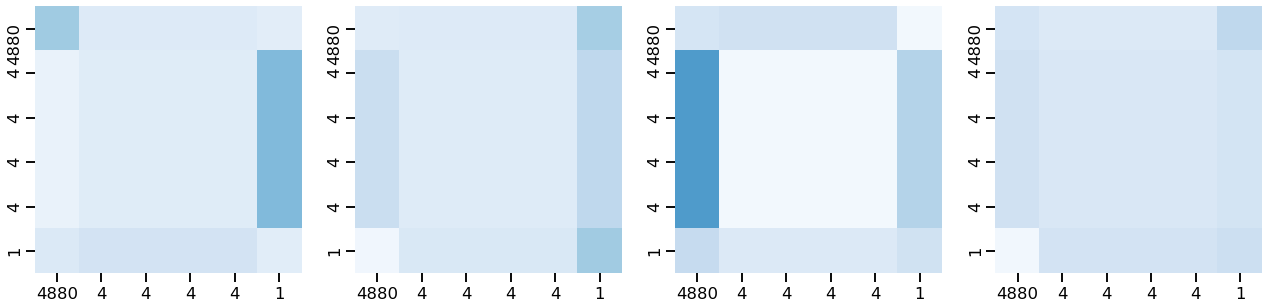

Encoder Layer 2


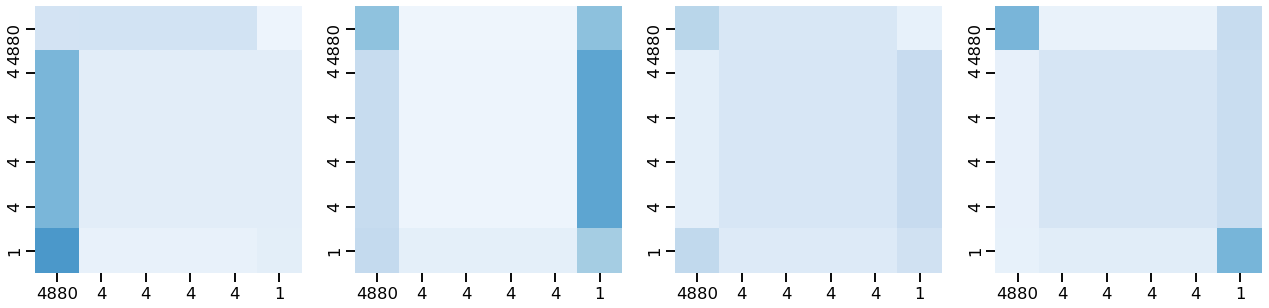



Ejemplo de tweet con label  support  y Tw_id  775166410662219777
Encoder Layer 1


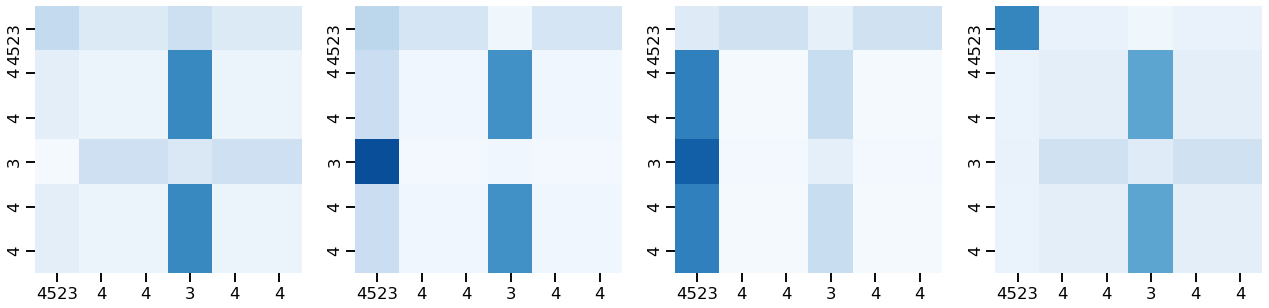

Encoder Layer 2


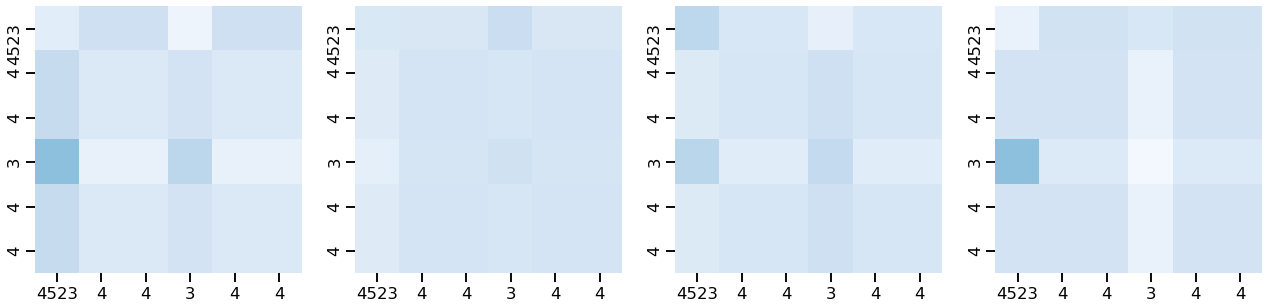



Ejemplo de tweet con label  denying  y Tw_id  765252851782254592
Encoder Layer 1


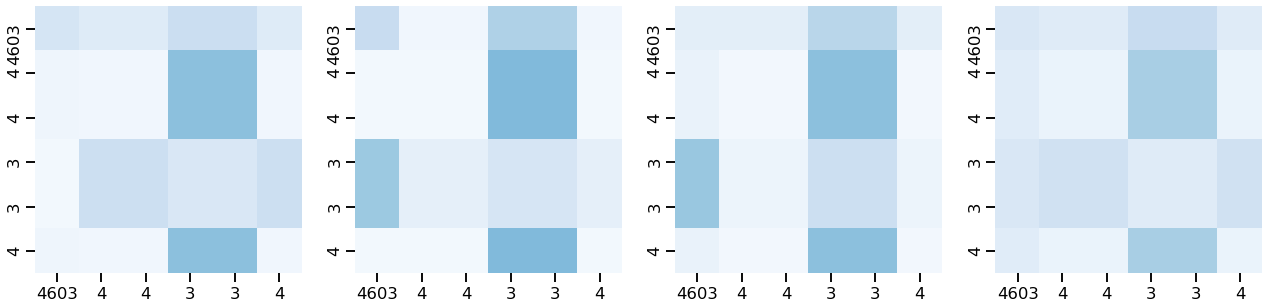

Encoder Layer 2


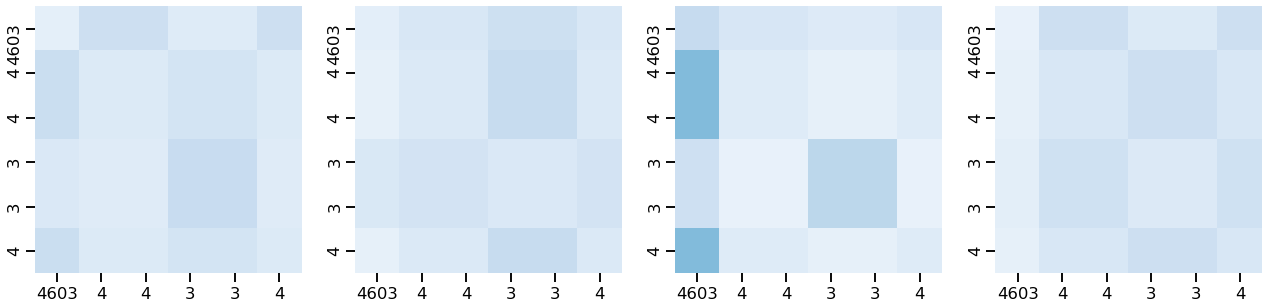



Ejemplo de tweet con label  questioning  y Tw_id  498314140436684800
Encoder Layer 1


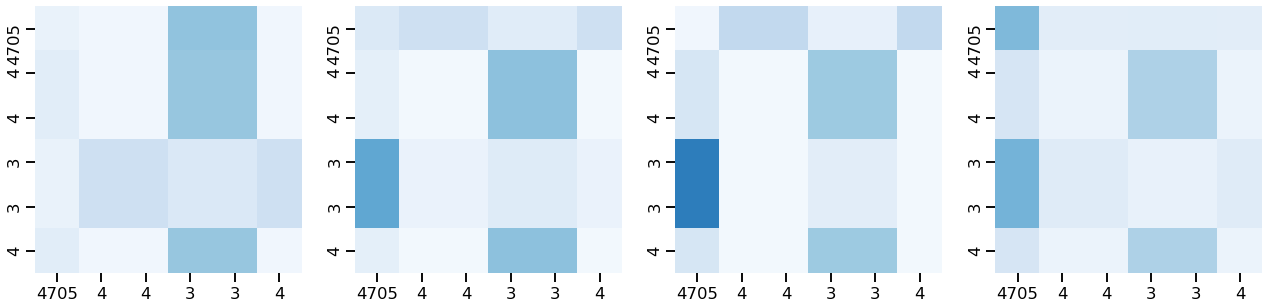

Encoder Layer 2


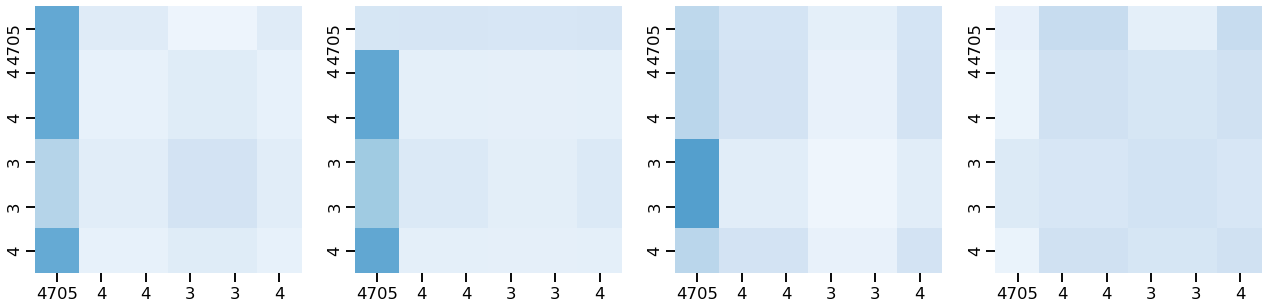

Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.142 	F-macro_val: 0.112
Epoch 10 	acc_val: 0.701 	F-macro_val: 0.444
Epoch 20 	acc_val: 0.729 	F-macro_val: 0.478
Epoch 30 	acc_val: 0.729 	F-macro_val: 0.481
Epoch 40 	acc_val: 0.747 	F-macro_val: 0.515
Epoch 50 	acc_val: 0.747 	F-macro_val: 0.545
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


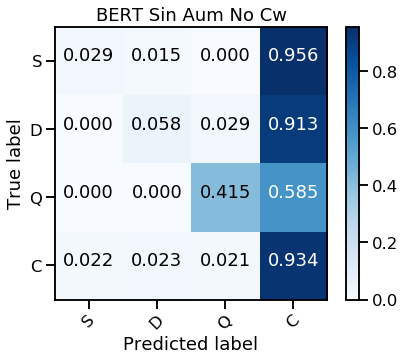

Test_ acc: 0.7610186092066601
Test_ f1 none: [0.04597701 0.08695652 0.52380952 0.85781711]
Test_ f1 macro: 0.3786400415468625


Ejemplo de tweet con label  commenting  y Tw_id  765042054141468672
Encoder Layer 1


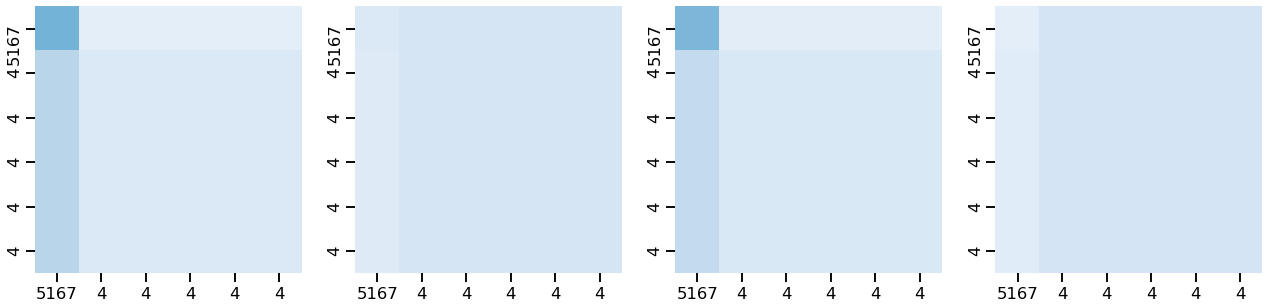

Encoder Layer 2


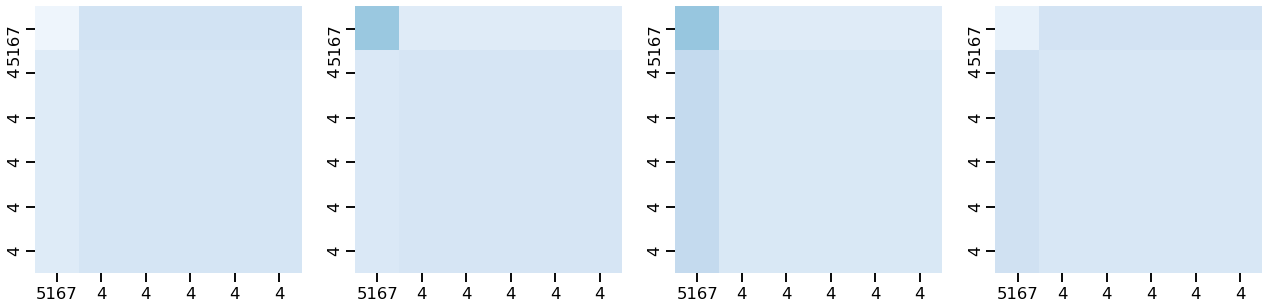



Ejemplo de tweet con label  support  y Tw_id  524965242691141632
Encoder Layer 1


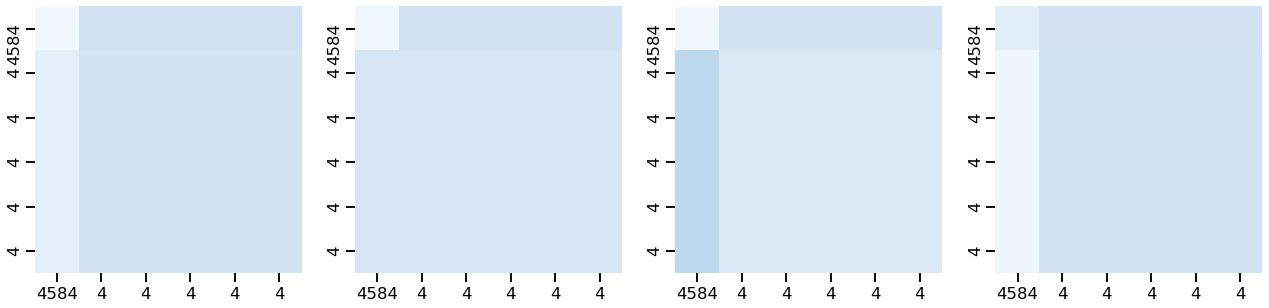

Encoder Layer 2


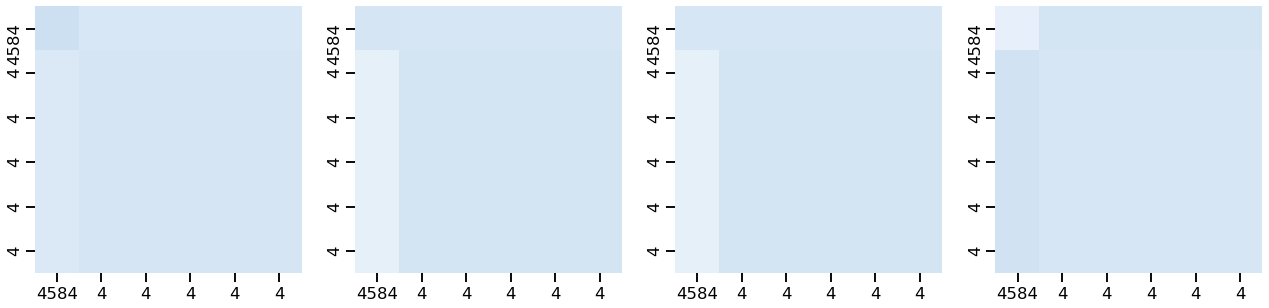



Ejemplo de tweet con label  denying  y Tw_id  580355626926231552
Encoder Layer 1


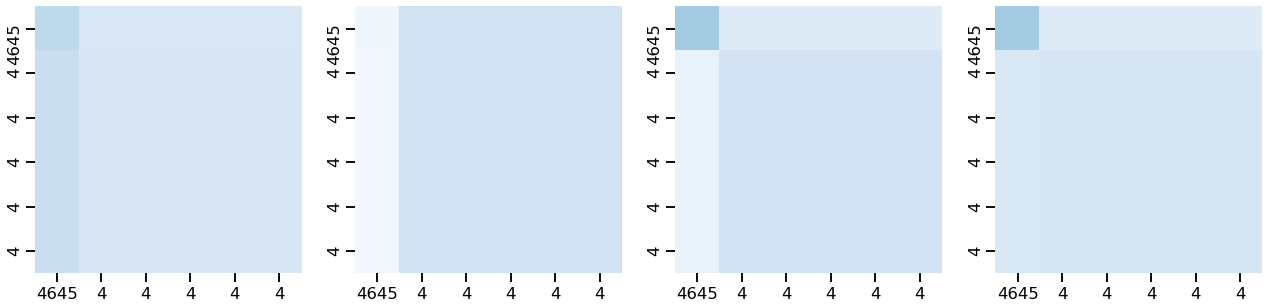

Encoder Layer 2


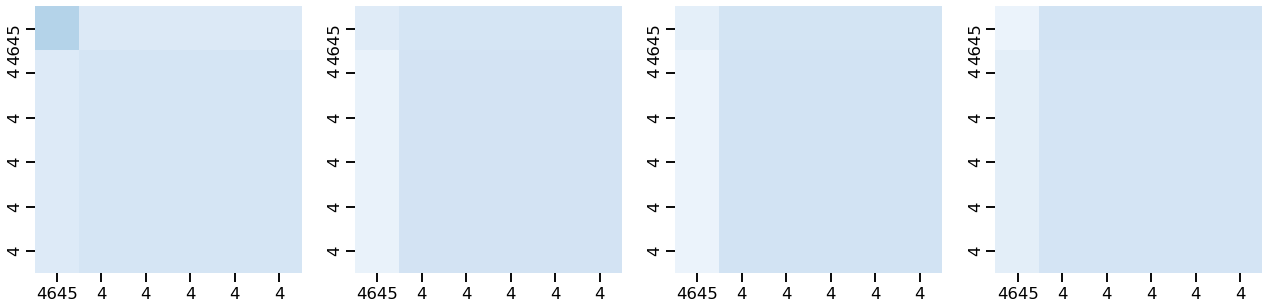



Ejemplo de tweet con label  questioning  y Tw_id  524942600344571904
Encoder Layer 1


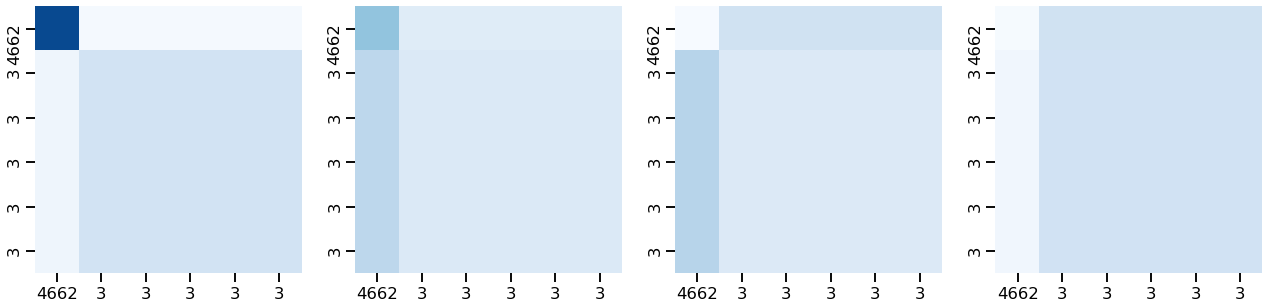

Encoder Layer 2


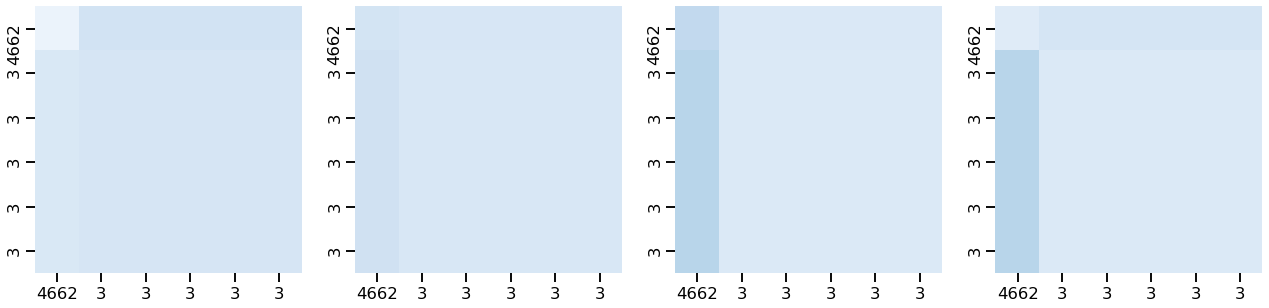

Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.299 	F-macro_val: 0.183
Epoch 10 	acc_val: 0.632 	F-macro_val: 0.238
Epoch 20 	acc_val: 0.708 	F-macro_val: 0.425
Epoch 30 	acc_val: 0.691 	F-macro_val: 0.424
Epoch 40 	acc_val: 0.705 	F-macro_val: 0.468
Epoch 50 	acc_val: 0.705 	F-macro_val: 0.504
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


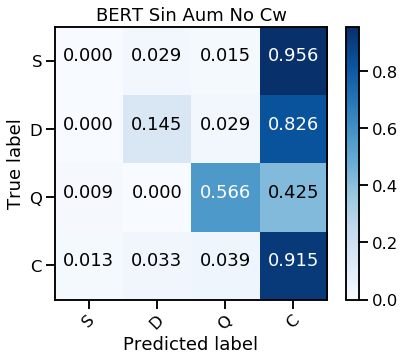

Test_ acc: 0.7659157688540646
Test_ f1 none: [0.         0.18691589 0.60301508 0.85938443]
Test_ f1 macro: 0.4123288482298917


Ejemplo de tweet con label  commenting  y Tw_id  775067765640040448
Encoder Layer 1


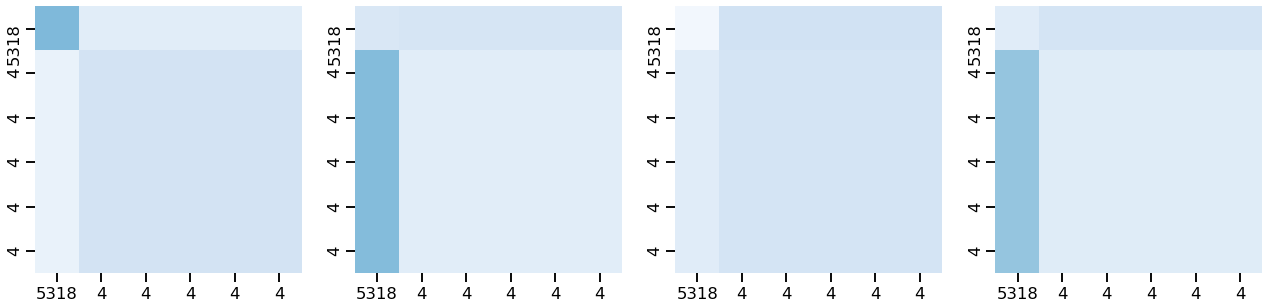

Encoder Layer 2


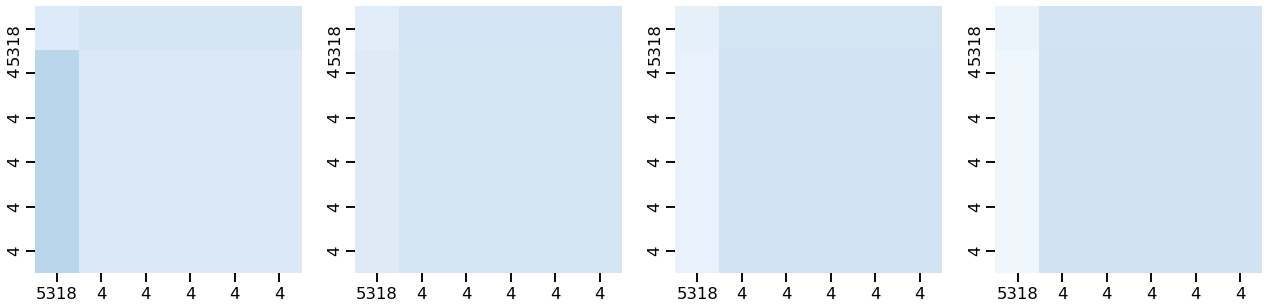



Ejemplo de tweet con label  support  y Tw_id  767730695619751938
Encoder Layer 1


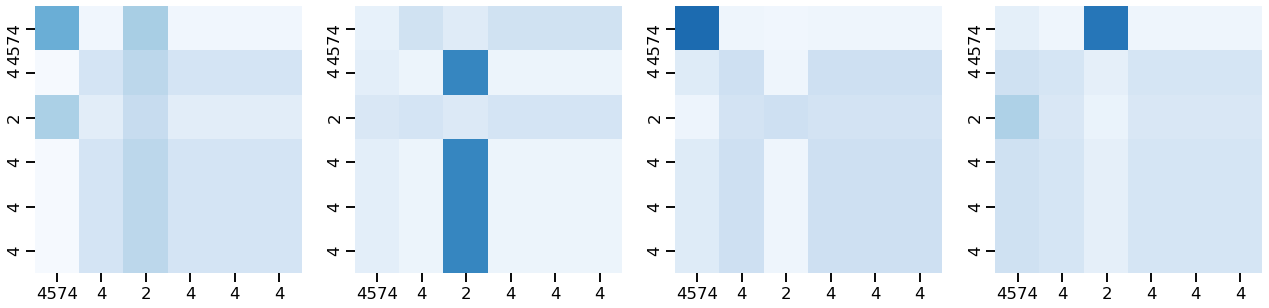

Encoder Layer 2


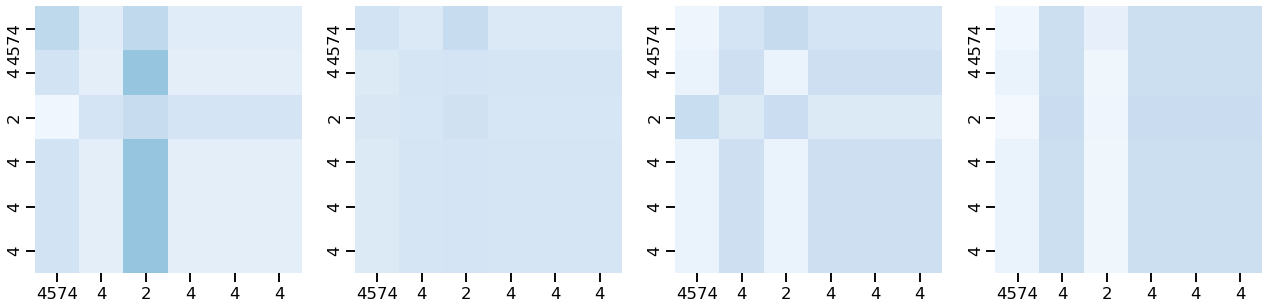



Ejemplo de tweet con label  denying  y Tw_id  764945051830988800
Encoder Layer 1


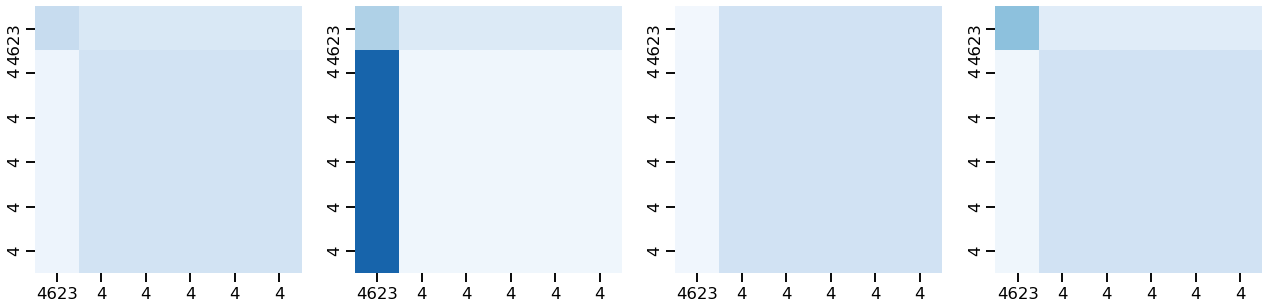

Encoder Layer 2


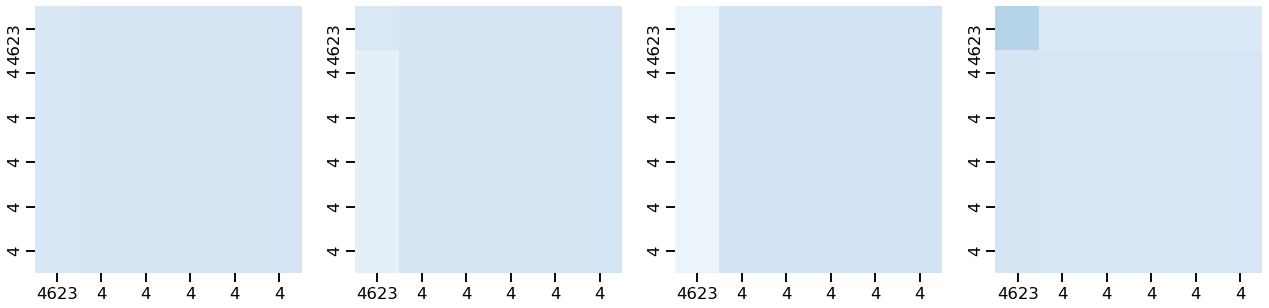



Ejemplo de tweet con label  questioning  y Tw_id  767730320246509568
Encoder Layer 1


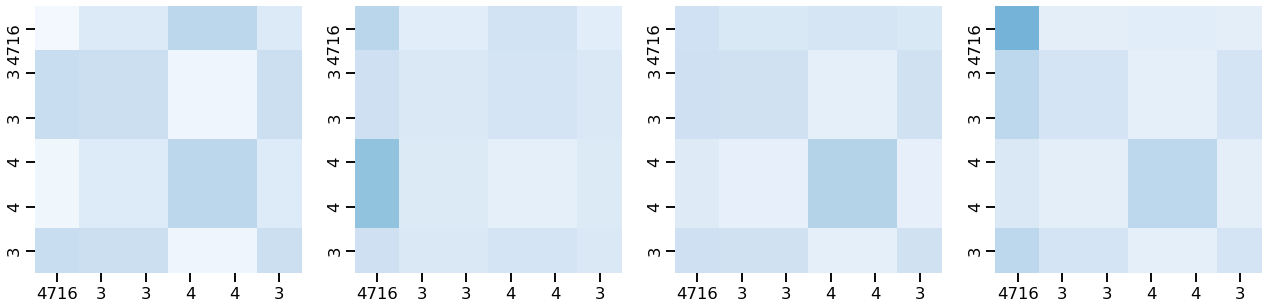

Encoder Layer 2


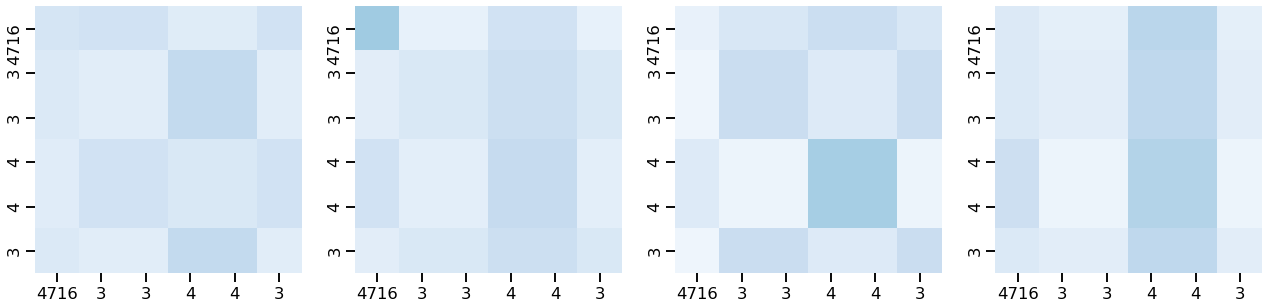

Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.580 	F-macro_val: 0.296
Epoch 10 	acc_val: 0.615 	F-macro_val: 0.286
Epoch 20 	acc_val: 0.684 	F-macro_val: 0.413
Epoch 30 	acc_val: 0.701 	F-macro_val: 0.434
Epoch 40 	acc_val: 0.719 	F-macro_val: 0.451
Epoch 50 	acc_val: 0.715 	F-macro_val: 0.449
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


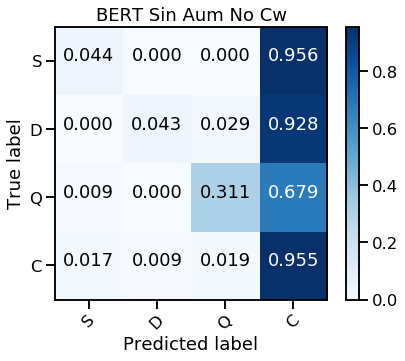

Test_ acc: 0.7659157688540646
Test_ f1 none: [0.07058824 0.07594937 0.42307692 0.86295006]
Test_ f1 macro: 0.35814114588291435
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.358 	F-macro_val: 0.223
Epoch 10 	acc_val: 0.684 	F-macro_val: 0.329
Epoch 20 	acc_val: 0.729 	F-macro_val: 0.458
Epoch 30 	acc_val: 0.736 	F-macro_val: 0.493
Epoch 40 	acc_val: 0.750 	F-macro_val: 0.499
Epoch 50 	acc_val: 0.743 	F-macro_val: 0.524
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


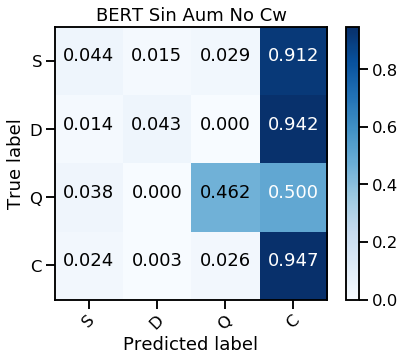

Test_ acc: 0.7757100881488737
Test_ f1 none: [0.06315789 0.08       0.55367232 0.86961652]
Test_ f1 macro: 0.39161168257376605
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.253 	F-macro_val: 0.258
Epoch 10 	acc_val: 0.701 	F-macro_val: 0.433
Epoch 20 	acc_val: 0.715 	F-macro_val: 0.452
Epoch 30 	acc_val: 0.726 	F-macro_val: 0.460
Epoch 40 	acc_val: 0.726 	F-macro_val: 0.468
Epoch 50 	acc_val: 0.743 	F-macro_val: 0.487
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


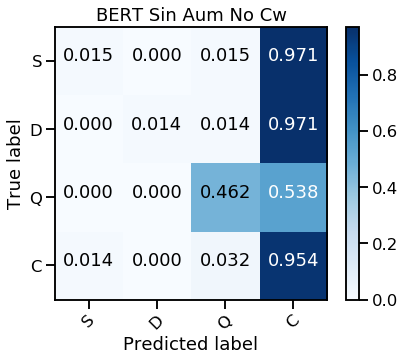

Test_ acc: 0.7766895200783546
Test_ f1 none: [0.025      0.02857143 0.53846154 0.86783626]
Test_ f1 macro: 0.36496730608572714
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.194 	F-macro_val: 0.118
Epoch 10 	acc_val: 0.684 	F-macro_val: 0.324
Epoch 20 	acc_val: 0.753 	F-macro_val: 0.492
Epoch 30 	acc_val: 0.740 	F-macro_val: 0.496
Epoch 40 	acc_val: 0.740 	F-macro_val: 0.508
Epoch 50 	acc_val: 0.747 	F-macro_val: 0.509
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


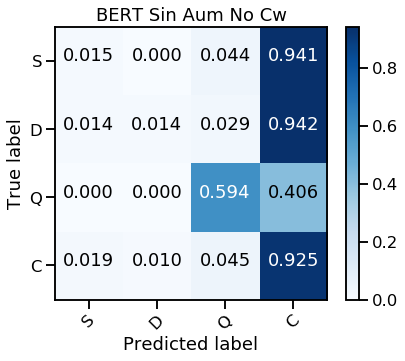

Test_ acc: 0.7688540646425074
Test_ f1 none: [0.02352941 0.02564103 0.60287081 0.86227545]
Test_ f1 macro: 0.3785791749761643
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.580 	F-macro_val: 0.404
Epoch 10 	acc_val: 0.701 	F-macro_val: 0.465
Epoch 20 	acc_val: 0.698 	F-macro_val: 0.468
Epoch 30 	acc_val: 0.712 	F-macro_val: 0.477
Epoch 40 	acc_val: 0.712 	F-macro_val: 0.475
Epoch 50 	acc_val: 0.701 	F-macro_val: 0.461
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


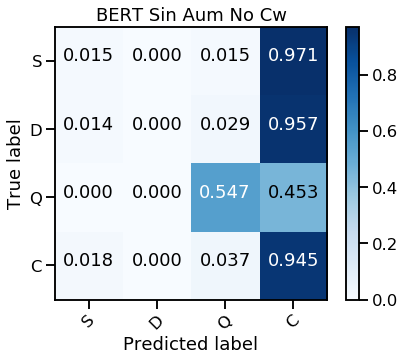

Test_ acc: 0.7776689520078355
Test_ f1 none: [0.02380952 0.         0.59183673 0.86828116]
Test_ f1 macro: 0.3709818540529029
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.146 	F-macro_val: 0.142
Epoch 10 	acc_val: 0.590 	F-macro_val: 0.271
Epoch 20 	acc_val: 0.705 	F-macro_val: 0.444
Epoch 30 	acc_val: 0.698 	F-macro_val: 0.461
Epoch 40 	acc_val: 0.705 	F-macro_val: 0.481
Epoch 50 	acc_val: 0.719 	F-macro_val: 0.503
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


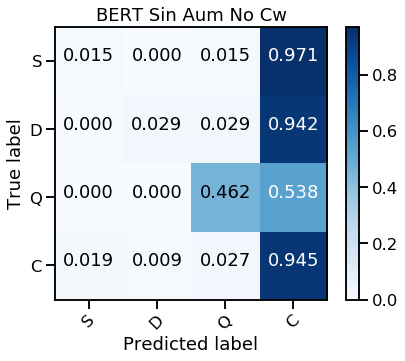

Test_ acc: 0.7708129285014691
Test_ f1 none: [0.02380952 0.05128205 0.54748603 0.86419753]
Test_ f1 macro: 0.3716937848688314
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.271 	F-macro_val: 0.177
Epoch 10 	acc_val: 0.628 	F-macro_val: 0.265
Epoch 20 	acc_val: 0.712 	F-macro_val: 0.418
Epoch 30 	acc_val: 0.701 	F-macro_val: 0.489
Epoch 40 	acc_val: 0.715 	F-macro_val: 0.517
Epoch 50 	acc_val: 0.701 	F-macro_val: 0.513
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


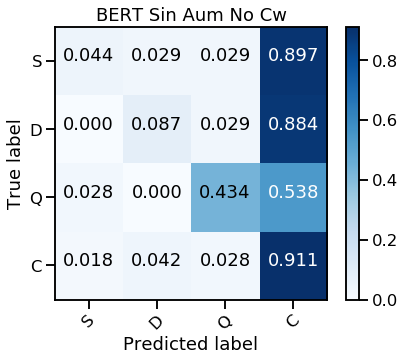

Test_ acc: 0.7482859941234085
Test_ f1 none: [0.06818182 0.10909091 0.51685393 0.85114046]
Test_ f1 macro: 0.3863167790098675
Entrenando Run # 11
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.097 	F-macro_val: 0.092
Epoch 10 	acc_val: 0.663 	F-macro_val: 0.384
Epoch 20 	acc_val: 0.719 	F-macro_val: 0.447
Epoch 30 	acc_val: 0.736 	F-macro_val: 0.489
Epoch 40 	acc_val: 0.736 	F-macro_val: 0.490
Epoch 50 	acc_val: 0.740 	F-macro_val: 0.494
Testing run # 11
SE TUVIERON QUE REPETIR 3 EJEMPLOS


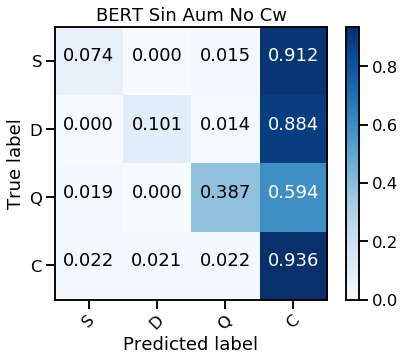

Test_ acc: 0.7649363369245837
Test_ f1 none: [0.10869565 0.15217391 0.4939759  0.86052009]
Test_ f1 macro: 0.40384139084862425
Entrenando Run # 12
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.278 	F-macro_val: 0.229
Epoch 10 	acc_val: 0.691 	F-macro_val: 0.424
Epoch 20 	acc_val: 0.698 	F-macro_val: 0.432
Epoch 30 	acc_val: 0.708 	F-macro_val: 0.467
Epoch 40 	acc_val: 0.722 	F-macro_val: 0.475
Epoch 50 	acc_val: 0.719 	F-macro_val: 0.479
Testing run # 12
SE TUVIERON QUE REPETIR 3 EJEMPLOS


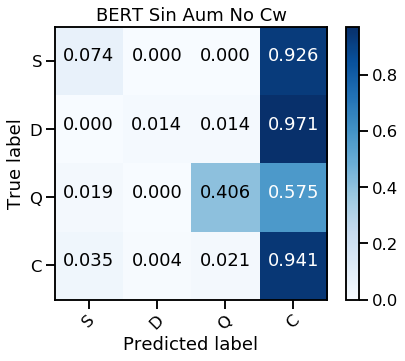

Test_ acc: 0.7649363369245837
Test_ f1 none: [0.09803922 0.02739726 0.51807229 0.86067019]
Test_ f1 macro: 0.3760447397801002
Entrenando Run # 13
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.333 	F-macro_val: 0.190
Epoch 10 	acc_val: 0.622 	F-macro_val: 0.203
Epoch 20 	acc_val: 0.653 	F-macro_val: 0.285
Epoch 30 	acc_val: 0.750 	F-macro_val: 0.498
Epoch 40 	acc_val: 0.743 	F-macro_val: 0.484
Epoch 50 	acc_val: 0.740 	F-macro_val: 0.487
Testing run # 13
SE TUVIERON QUE REPETIR 3 EJEMPLOS


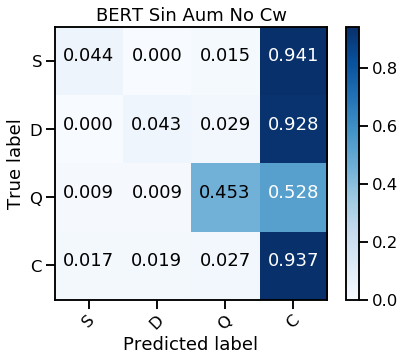

Test_ acc: 0.7668952007835456
Test_ f1 none: [0.07058824 0.06818182 0.53932584 0.86221171]
Test_ f1 macro: 0.3850769013051164
Entrenando Run # 14
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.309 	F-macro_val: 0.186
Epoch 10 	acc_val: 0.701 	F-macro_val: 0.349
Epoch 20 	acc_val: 0.736 	F-macro_val: 0.456
Epoch 30 	acc_val: 0.747 	F-macro_val: 0.486
Epoch 40 	acc_val: 0.750 	F-macro_val: 0.488
Epoch 50 	acc_val: 0.743 	F-macro_val: 0.513
Testing run # 14
SE TUVIERON QUE REPETIR 3 EJEMPLOS


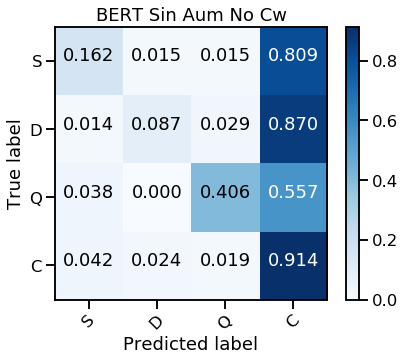

Test_ acc: 0.7551420176297747
Test_ f1 none: [0.18803419 0.12631579 0.51497006 0.85508118]
Test_ f1 macro: 0.42110030399525405


Ejemplo de tweet con label  commenting  y Tw_id  524998076164214784
Encoder Layer 1


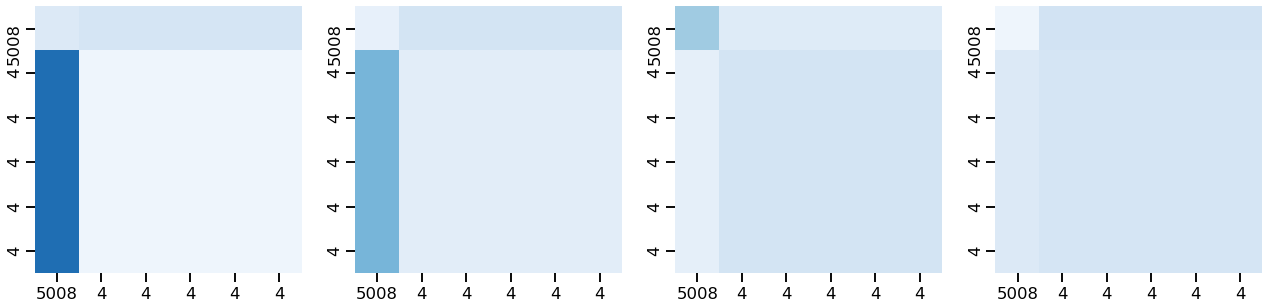

Encoder Layer 2


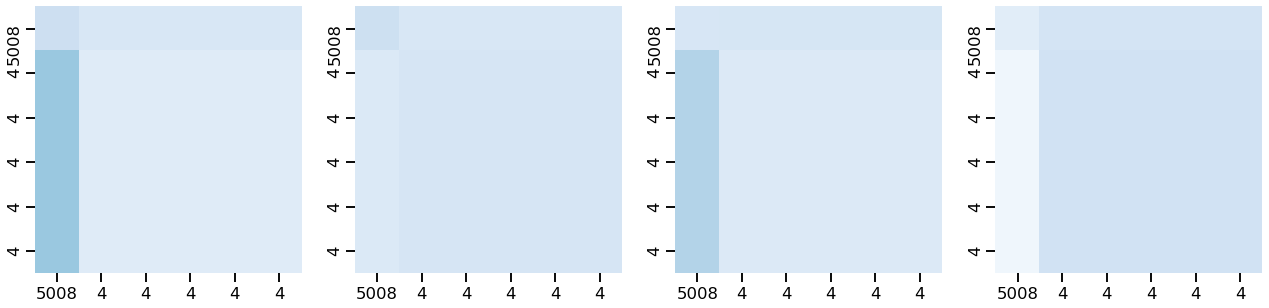



Ejemplo de tweet con label  support  y Tw_id  498295324029747200
Encoder Layer 1


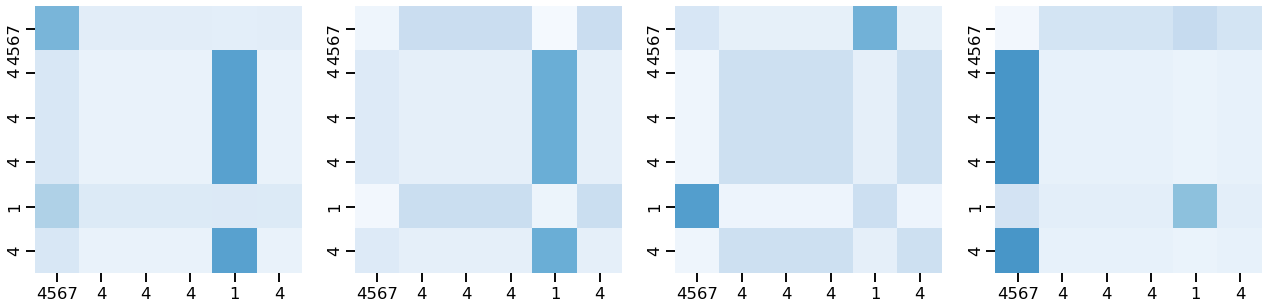

Encoder Layer 2


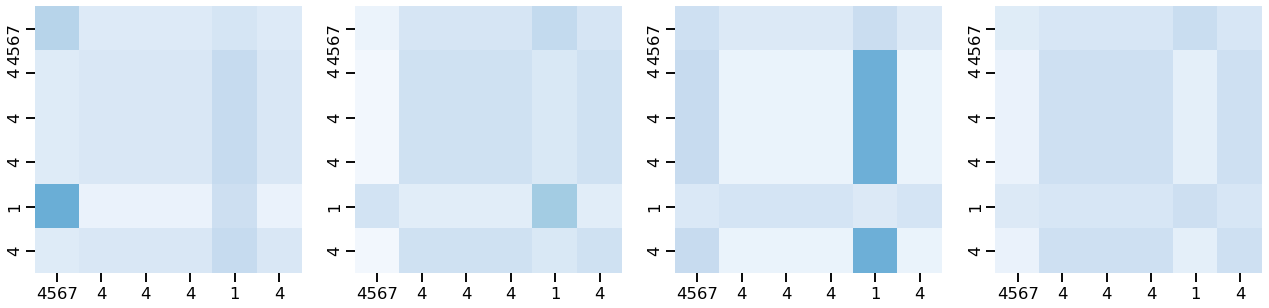



Ejemplo de tweet con label  denying  y Tw_id  764927294313865216
Encoder Layer 1


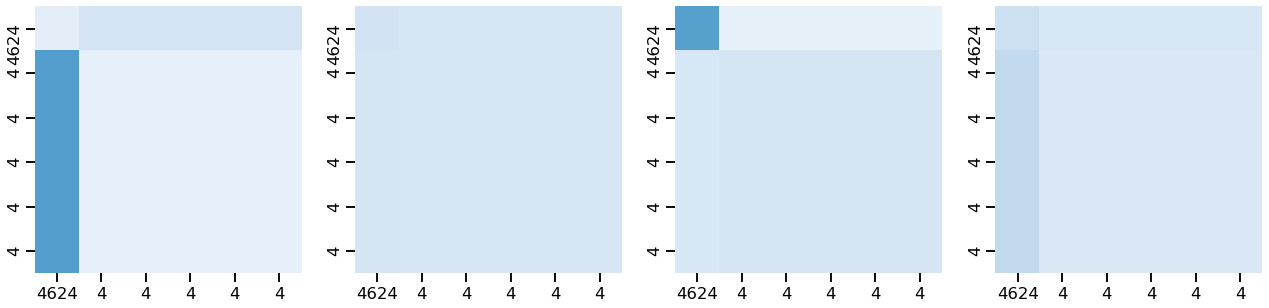

Encoder Layer 2


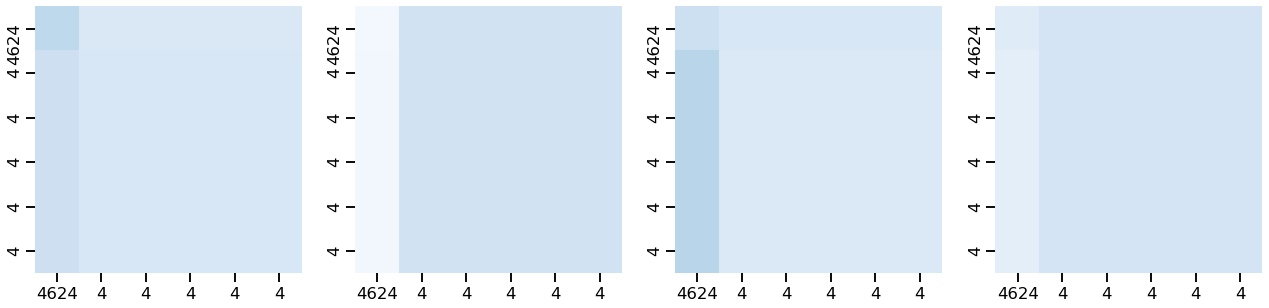



Ejemplo de tweet con label  questioning  y Tw_id  553561561139535872
Encoder Layer 1


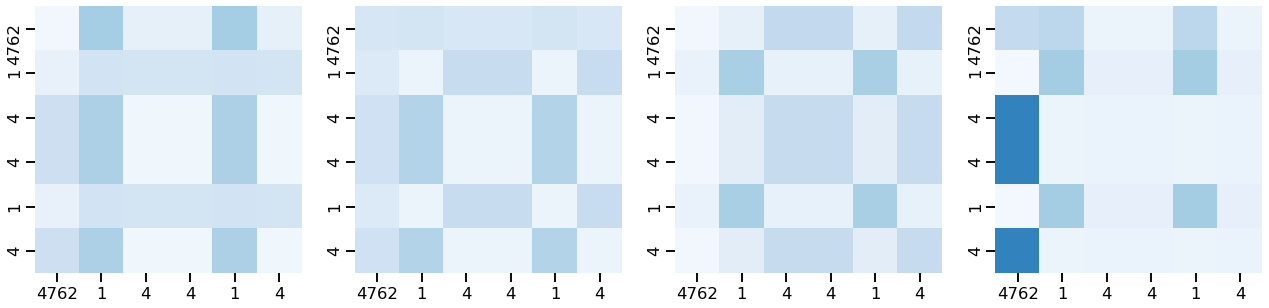

Encoder Layer 2


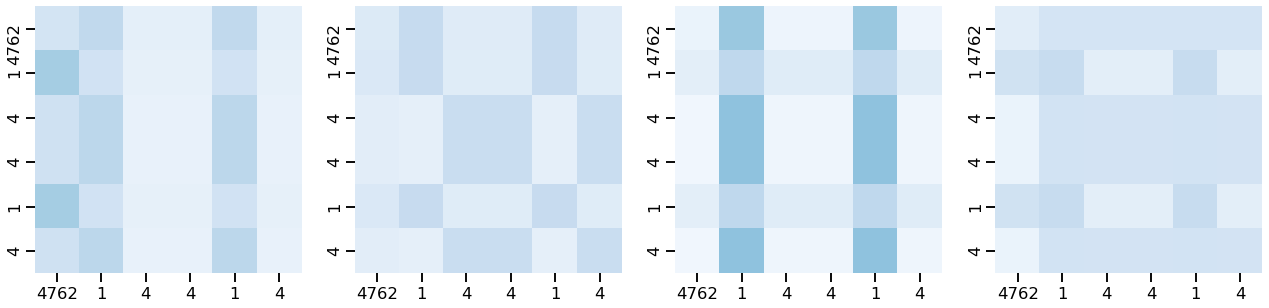

Entrenando Run # 15
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.333 	F-macro_val: 0.186
Epoch 10 	acc_val: 0.677 	F-macro_val: 0.366
Epoch 20 	acc_val: 0.712 	F-macro_val: 0.457
Epoch 30 	acc_val: 0.712 	F-macro_val: 0.480
Epoch 40 	acc_val: 0.722 	F-macro_val: 0.537
Epoch 50 	acc_val: 0.729 	F-macro_val: 0.546
Testing run # 15
SE TUVIERON QUE REPETIR 3 EJEMPLOS


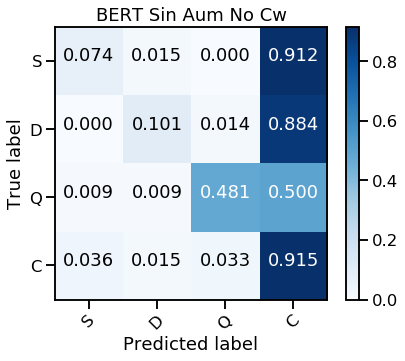

Test_ acc: 0.7590597453476984
Test_ f1 none: [0.09803922 0.15555556 0.55434783 0.8547419 ]
Test_ f1 macro: 0.4156711235218725
Entrenando Run # 16
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.191 	F-macro_val: 0.155
Epoch 10 	acc_val: 0.694 	F-macro_val: 0.349
Epoch 20 	acc_val: 0.733 	F-macro_val: 0.443
Epoch 30 	acc_val: 0.740 	F-macro_val: 0.482
Epoch 40 	acc_val: 0.760 	F-macro_val: 0.520
Epoch 50 	acc_val: 0.753 	F-macro_val: 0.509
Testing run # 16
SE TUVIERON QUE REPETIR 3 EJEMPLOS


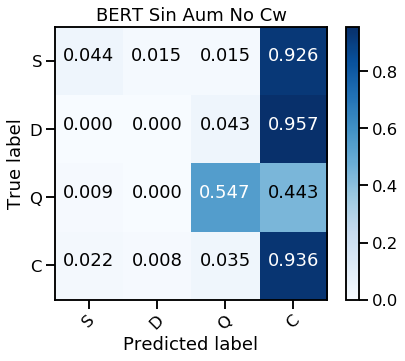

Test_ acc: 0.7727717923604309
Test_ f1 none: [0.06741573 0.         0.59487179 0.86563615]
Test_ f1 macro: 0.3819809181630983
Entrenando Run # 17
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.201 	F-macro_val: 0.124
Epoch 10 	acc_val: 0.663 	F-macro_val: 0.321
Epoch 20 	acc_val: 0.747 	F-macro_val: 0.486
Epoch 30 	acc_val: 0.747 	F-macro_val: 0.492
Epoch 40 	acc_val: 0.736 	F-macro_val: 0.484
Epoch 50 	acc_val: 0.743 	F-macro_val: 0.491
Testing run # 17
SE TUVIERON QUE REPETIR 3 EJEMPLOS


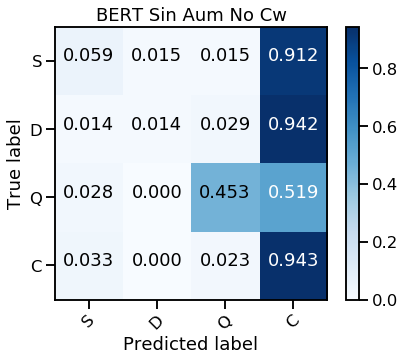

Test_ acc: 0.7708129285014691
Test_ f1 none: [0.07843137 0.02816901 0.54857143 0.86658796]
Test_ f1 macro: 0.38043994317550095
Entrenando Run # 18
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.115 	F-macro_val: 0.103
Epoch 10 	acc_val: 0.684 	F-macro_val: 0.401
Epoch 20 	acc_val: 0.705 	F-macro_val: 0.463
Epoch 30 	acc_val: 0.722 	F-macro_val: 0.486
Epoch 40 	acc_val: 0.726 	F-macro_val: 0.486
Epoch 50 	acc_val: 0.740 	F-macro_val: 0.544
Testing run # 18
SE TUVIERON QUE REPETIR 3 EJEMPLOS


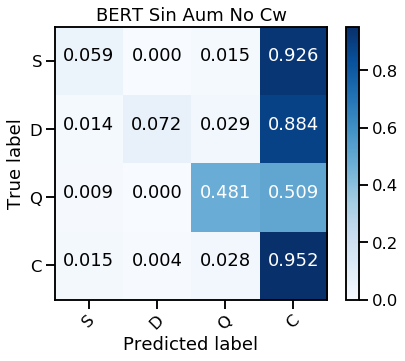

Test_ acc: 0.7845249755142018
Test_ f1 none: [0.09302326 0.12987013 0.56043956 0.87330583]
Test_ f1 macro: 0.41415969498700994
Entrenando Run # 19
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.087 	F-macro_val: 0.065
Epoch 10 	acc_val: 0.663 	F-macro_val: 0.315
Epoch 20 	acc_val: 0.705 	F-macro_val: 0.403
Epoch 30 	acc_val: 0.753 	F-macro_val: 0.512
Epoch 40 	acc_val: 0.743 	F-macro_val: 0.523
Epoch 50 	acc_val: 0.753 	F-macro_val: 0.560
Testing run # 19
SE TUVIERON QUE REPETIR 3 EJEMPLOS


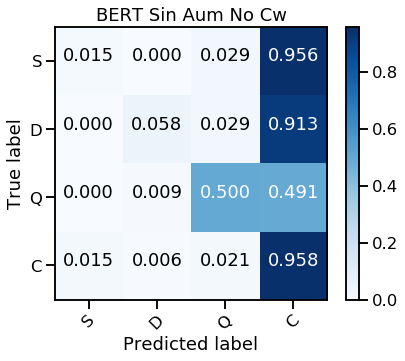

Test_ acc: 0.7864838393731636
Test_ f1 none: [0.02469136 0.10126582 0.59217877 0.8749266 ]
Test_ f1 macro: 0.3982656379691655
Entrenando Run # 20
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.128 	F-macro_val: 0.109
Epoch 10 	acc_val: 0.667 	F-macro_val: 0.363
Epoch 20 	acc_val: 0.701 	F-macro_val: 0.420
Epoch 30 	acc_val: 0.722 	F-macro_val: 0.465
Epoch 40 	acc_val: 0.722 	F-macro_val: 0.498
Epoch 50 	acc_val: 0.747 	F-macro_val: 0.527
Testing run # 20
SE TUVIERON QUE REPETIR 3 EJEMPLOS


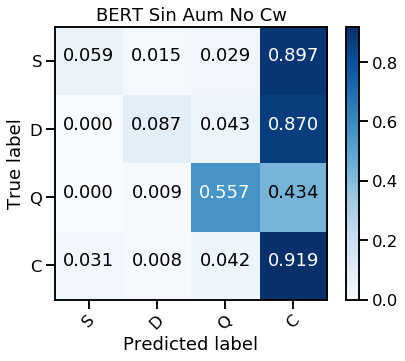

Test_ acc: 0.7678746327130265
Test_ f1 none: [0.08333333 0.14457831 0.58128079 0.86144578]
Test_ f1 macro: 0.41765955447405384


In [9]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
best_macro={'F_ma':0.1 , 'Run':0}

dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.0
bs=32

for x in range(1,21): 
    print ("Entrenando Run #", x)
    cnn1 = load_model(path_m+str(prob)+'/cnn1_'+str(x)+'-exec.h5')
    cnn2 = load_model(path_m+str(prob)+'/cnn2_'+str(x)+'-exec.h5')
    rnn1 = load_model(path_m+str(prob)+'/rnn1_'+str(x)+'-exec.h5')
    rnn2 = load_model(path_m+str(prob)+'/rnn2_'+str(x)+'-exec.h5')
    rnn3 = load_model(path_m+str(prob)+'/rnn3_'+str(x)+'-exec.h5')

    list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
    index_models=np.arange(5)
    dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
    modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
    ind=np.arange(5)
    dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]
    
    print ("agregando predicciones Train")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
    print ("agregando predicciones Val")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
    print ("agregando predicciones Test")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

    matrix=np.asarray(predicciones_all)
    matrix_val=np.asarray(predicciones_all_val)
    matrix_test=np.asarray(predicciones_all_test)
    new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)
    
    b_dim=768
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(sentences)):
        #ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
        vector=bc.encode([encoded_tok])[0]
        final_bert= vector
            
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    objs_val=val['Tw_id']      #df_val['Unnamed: 0'].values
    objs_test=test['Tw_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
      
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
        vector=bc.encode([encoded_tok])[0]
        final_bert= vector

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    
    K_list_new= np.asarray(K_list_ext, dtype='float32')
    keras.backend.clear_session()
    gc.collect()
        
    ###################################### TRANSFORMER ###############################
    hist_train_loss=[]
    hist_train_acc=[]
    hist_train_fma=[]
    hist_val_loss=[]
    hist_val_acc=[]
    hist_val_fma=[]
    
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, K_list_new, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

    
    for epoch in range(60):
        model.train()
        DATA=data_gen(bs, 'Train', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)  
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        DATA_V=data_gen(bs, 'Val', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)  
            
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(DATA_V, model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())
    
    model.eval()
    print ("Testing run #",x)
    DATA_T=data_gen(bs, 'Test', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)  
            
    predicciones = run_epoch(DATA_T, model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-3])
    glo_fno=f1_score(etiq_t,predicciones[:-3], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-3], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-3])

    plot_cm(cm_norma(glo_cm),["S","D","Q","C"],"BERT Sin Aum No Cw")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

    if glo_fma>best_macro['F_ma']:
        best_macro['F_ma']=glo_fma
        best_macro['Run']=x                
        tope=4520

        for key in keys: 
            mask_s=test["Label"]==key
            q_tid=np.random.choice(test["Tw_id"][mask_s])
            q_ide=list(test["Tw_id"].values).index(q_tid)

            model.eval()

            temp2= [tope + q_ide]

            for m in range(n_machines): 
                temp2= temp2 + [np.argmax(matrix_test[m][q_ide])+1] 

            sent = [temp2]
            src = torch.LongTensor([w for w in sent])
            src = Variable(src)
            src_mask = src_mask=  (src != 0).unsqueeze(-2)
            out = model.forward(src, src_mask)
            print ("\n\nEjemplo de tweet con label ", key, " y Tw_id ", q_tid)
            for layer in range(2):
                fig, axs = plt.subplots(1,4, figsize=(22,11))
                print("Encoder Layer", layer+1)
                for h in range(4):
                    draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
                            axs[h], sent, color="Blues")
                plt.show()

In [10]:
best_macro

{'F_ma': 0.42110030399525405, 'Run': 14}

Acc: 0.768 -- deviation: 0.009
F-score: 0.387 -- deviation: 0.021
(0.0_No CW) SDQC: 0.06388003949885585 0.08242515215393528 0.5404856591119349 0.8629545739254556


Confusion counts
[[6.100e+01 1.300e+01 2.200e+01 1.264e+03]
 [6.000e+00 7.300e+01 3.500e+01 1.266e+03]
 [2.400e+01 6.000e+00 9.770e+02 1.113e+03]
 [3.540e+02 1.950e+02 4.360e+02 1.458e+04]]


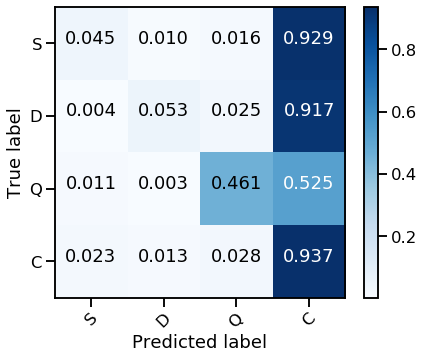

In [11]:
print ("Acc: %.3f" % np.mean(np.asarray(global_accs)), "-- deviation: %.3f" % np.std(np.asarray(global_accs)))
print ("F-score: %.3f" % np.mean(np.asarray(global_fmacros)), "-- deviation: %.3f" % np.std(np.asarray(global_fmacros)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.0_No CW) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S","D","Q","C"], "", cmap='Blues')

## 0.0 CW

In [12]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights

array([1.26 , 3.182, 3.211, 0.388])

Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.198 	F-macro_val: 0.157
Epoch 10 	acc_val: 0.302 	F-macro_val: 0.241
Epoch 20 	acc_val: 0.410 	F-macro_val: 0.357
Epoch 30 	acc_val: 0.500 	F-macro_val: 0.441
Epoch 40 	acc_val: 0.503 	F-macro_val: 0.449
Epoch 50 	acc_val: 0.535 	F-macro_val: 0.466
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


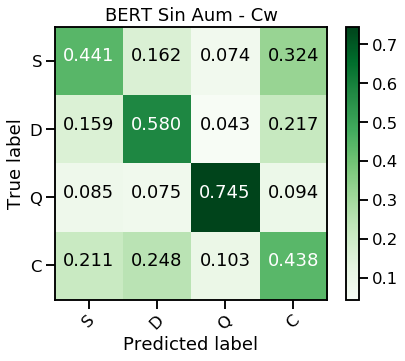

Test_ acc: 0.47992164544564153
Test_ f1 none: [0.213 0.249 0.579 0.585]
Test_ f1 macro: 0.4064118450948422


Ejemplo de tweet con label  commenting  y Tw_id  524962458864476161
Encoder Layer 1


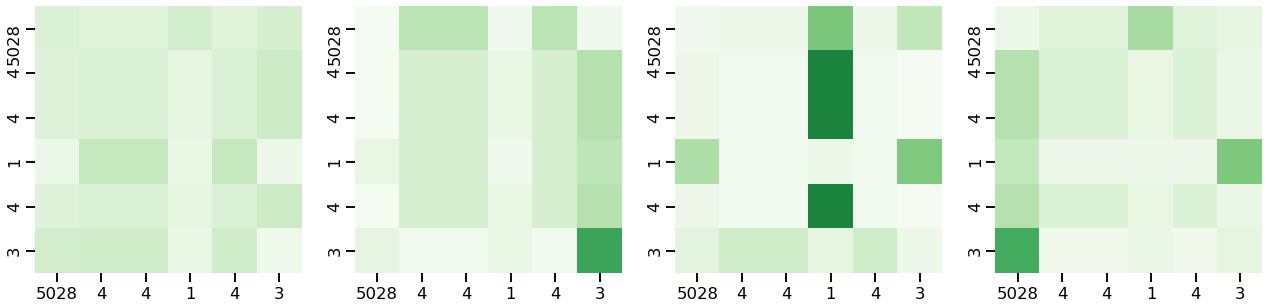

Encoder Layer 2


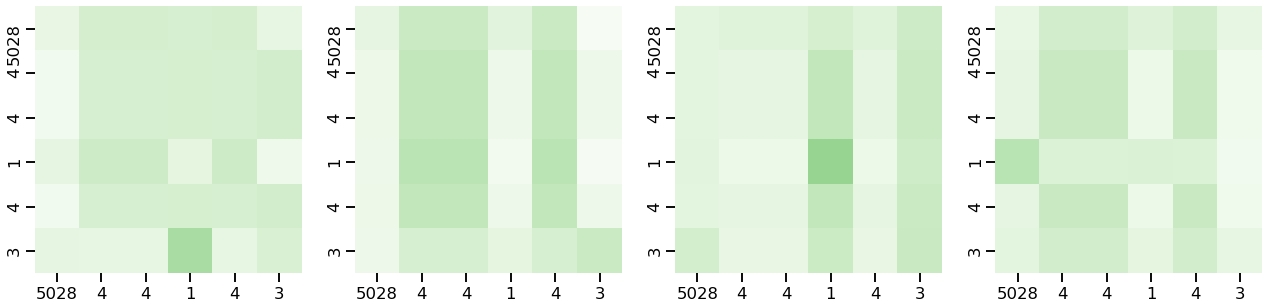



Ejemplo de tweet con label  support  y Tw_id  769993008896995328
Encoder Layer 1


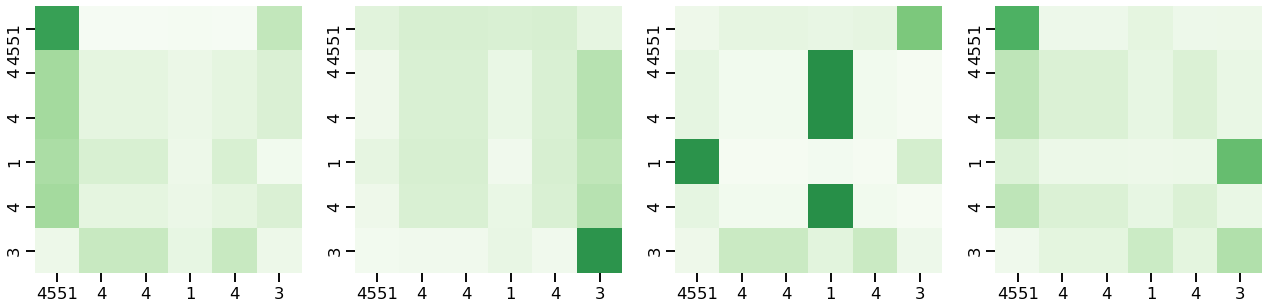

Encoder Layer 2


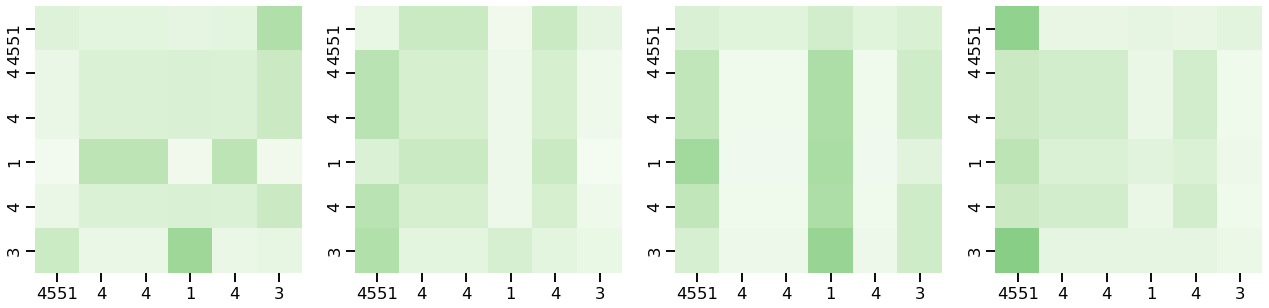



Ejemplo de tweet con label  denying  y Tw_id  580355626926231552
Encoder Layer 1


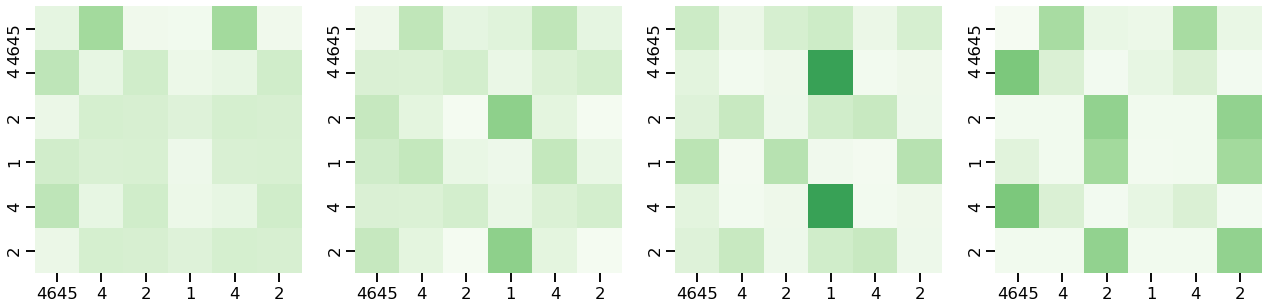

Encoder Layer 2


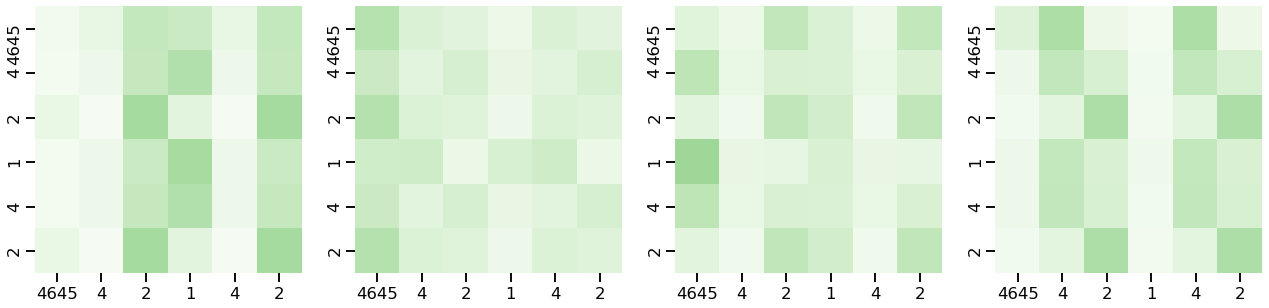



Ejemplo de tweet con label  questioning  y Tw_id  763151827730894848
Encoder Layer 1


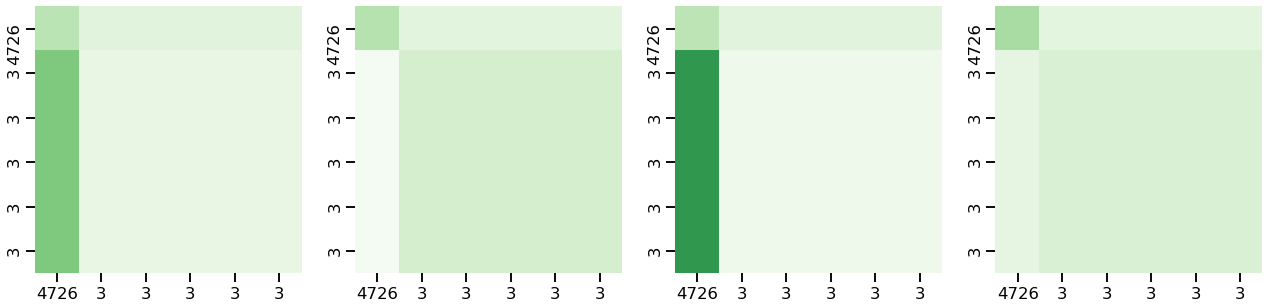

Encoder Layer 2


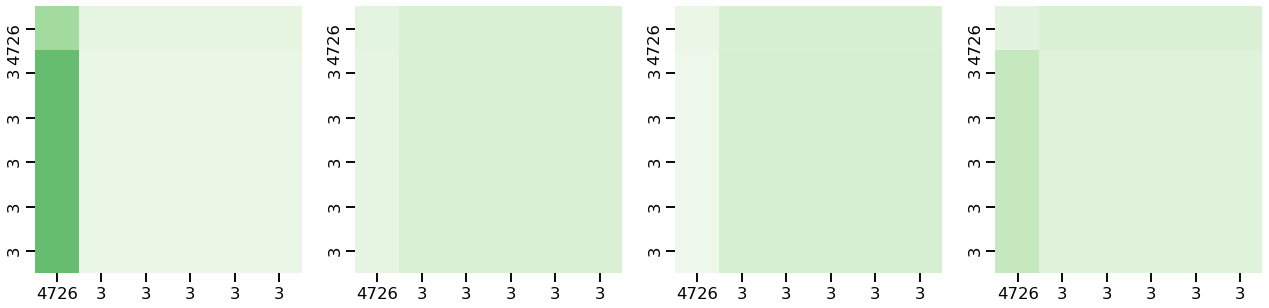

Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.215 	F-macro_val: 0.162
Epoch 10 	acc_val: 0.292 	F-macro_val: 0.251
Epoch 20 	acc_val: 0.302 	F-macro_val: 0.282
Epoch 30 	acc_val: 0.354 	F-macro_val: 0.326
Epoch 40 	acc_val: 0.524 	F-macro_val: 0.450
Epoch 50 	acc_val: 0.528 	F-macro_val: 0.446
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


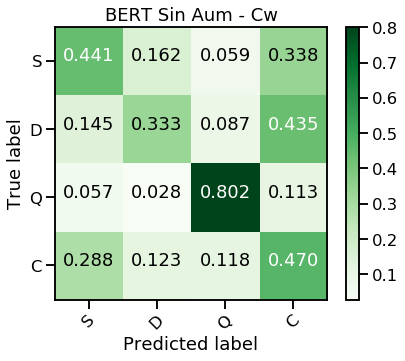

Test_ acc: 0.49363369245837413
Test_ f1 none: [0.178 0.228 0.58  0.605]
Test_ f1 macro: 0.3977253501013982
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.253 	F-macro_val: 0.152
Epoch 10 	acc_val: 0.292 	F-macro_val: 0.201
Epoch 20 	acc_val: 0.365 	F-macro_val: 0.318
Epoch 30 	acc_val: 0.417 	F-macro_val: 0.367
Epoch 40 	acc_val: 0.528 	F-macro_val: 0.450
Epoch 50 	acc_val: 0.545 	F-macro_val: 0.463
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


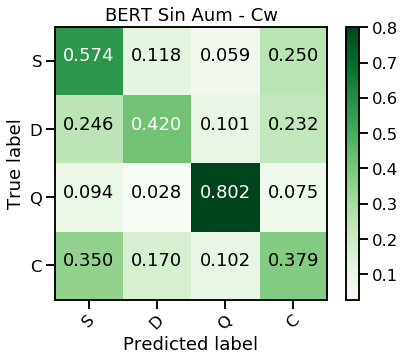

Test_ acc: 0.4387855044074437
Test_ f1 none: [0.192 0.241 0.605 0.53 ]
Test_ f1 macro: 0.3918468284182409
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.128 	F-macro_val: 0.135
Epoch 10 	acc_val: 0.278 	F-macro_val: 0.299
Epoch 20 	acc_val: 0.389 	F-macro_val: 0.383
Epoch 30 	acc_val: 0.444 	F-macro_val: 0.416
Epoch 40 	acc_val: 0.458 	F-macro_val: 0.427
Epoch 50 	acc_val: 0.503 	F-macro_val: 0.444
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


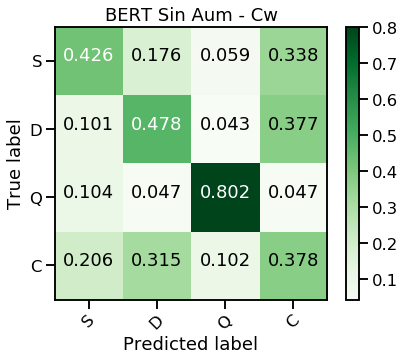

Test_ acc: 0.43192948090107736
Test_ f1 none: [0.211 0.181 0.614 0.522]
Test_ f1 macro: 0.38203716761465667
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.319 	F-macro_val: 0.193
Epoch 10 	acc_val: 0.424 	F-macro_val: 0.354
Epoch 20 	acc_val: 0.444 	F-macro_val: 0.396
Epoch 30 	acc_val: 0.483 	F-macro_val: 0.418
Epoch 40 	acc_val: 0.535 	F-macro_val: 0.443
Epoch 50 	acc_val: 0.569 	F-macro_val: 0.468
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


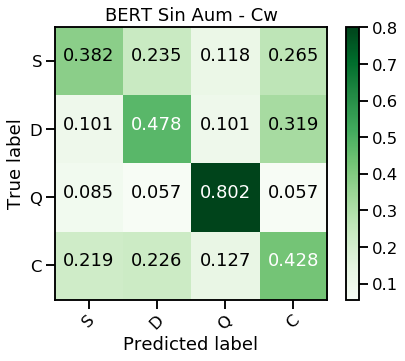

Test_ acc: 0.4671890303623898
Test_ f1 none: [0.186 0.22  0.557 0.576]
Test_ f1 macro: 0.3846794888662636
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.111 	F-macro_val: 0.071
Epoch 10 	acc_val: 0.288 	F-macro_val: 0.225
Epoch 20 	acc_val: 0.361 	F-macro_val: 0.302
Epoch 30 	acc_val: 0.552 	F-macro_val: 0.470
Epoch 40 	acc_val: 0.590 	F-macro_val: 0.493
Epoch 50 	acc_val: 0.618 	F-macro_val: 0.511
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


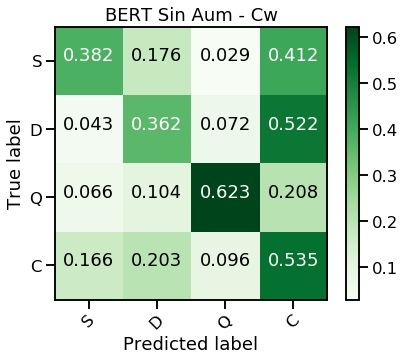

Test_ acc: 0.5220372184133203
Test_ f1 none: [0.223 0.182 0.52  0.65 ]
Test_ f1 macro: 0.3936697967133741
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.132 	F-macro_val: 0.084
Epoch 10 	acc_val: 0.132 	F-macro_val: 0.098
Epoch 20 	acc_val: 0.323 	F-macro_val: 0.293
Epoch 30 	acc_val: 0.323 	F-macro_val: 0.288
Epoch 40 	acc_val: 0.372 	F-macro_val: 0.330
Epoch 50 	acc_val: 0.441 	F-macro_val: 0.384
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


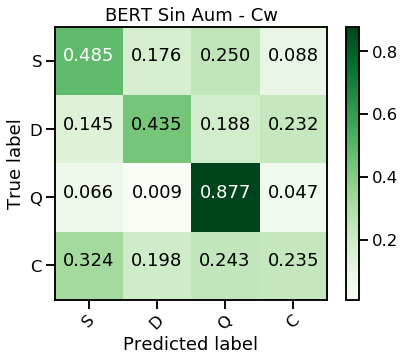

Test_ acc: 0.33202742409402547
Test_ f1 none: [0.178 0.226 0.445 0.37 ]
Test_ f1 macro: 0.3048409272093483
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.253 	F-macro_val: 0.198
Epoch 10 	acc_val: 0.406 	F-macro_val: 0.341
Epoch 20 	acc_val: 0.510 	F-macro_val: 0.434
Epoch 30 	acc_val: 0.479 	F-macro_val: 0.424
Epoch 40 	acc_val: 0.524 	F-macro_val: 0.447
Epoch 50 	acc_val: 0.531 	F-macro_val: 0.452
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


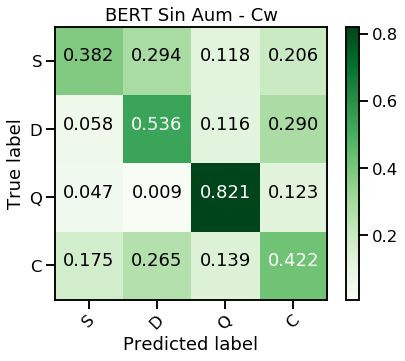

Test_ acc: 0.4681684622918707
Test_ f1 none: [0.218 0.222 0.549 0.569]
Test_ f1 macro: 0.3894104766949799
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.146 	F-macro_val: 0.112
Epoch 10 	acc_val: 0.188 	F-macro_val: 0.146
Epoch 20 	acc_val: 0.330 	F-macro_val: 0.333
Epoch 30 	acc_val: 0.448 	F-macro_val: 0.409
Epoch 40 	acc_val: 0.635 	F-macro_val: 0.537
Epoch 50 	acc_val: 0.663 	F-macro_val: 0.547
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


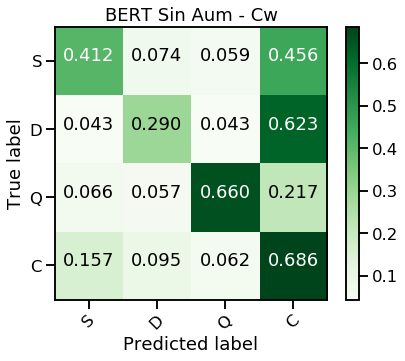

Test_ acc: 0.6385896180215475
Test_ f1 none: [0.246 0.23  0.606 0.758]
Test_ f1 macro: 0.4598860211772537


Ejemplo de tweet con label  commenting  y Tw_id  765035397059530755
Encoder Layer 1


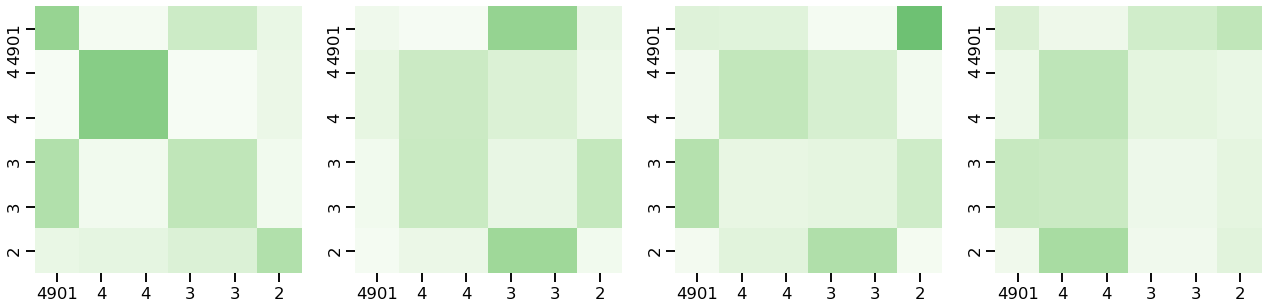

Encoder Layer 2


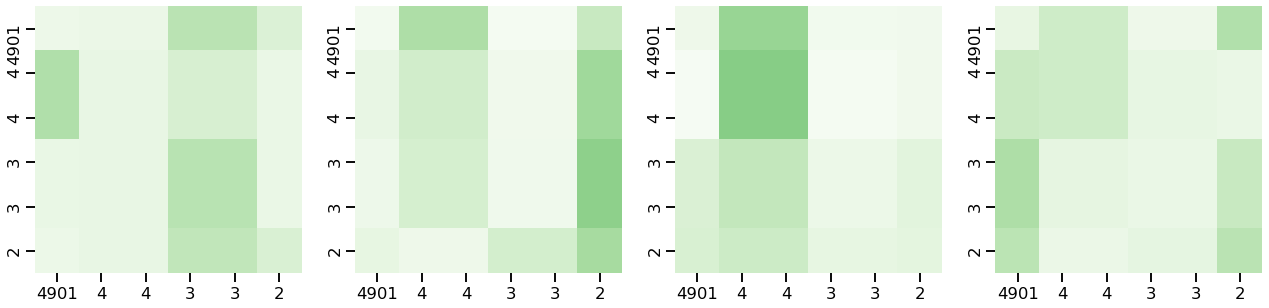



Ejemplo de tweet con label  support  y Tw_id  498298907311767553
Encoder Layer 1


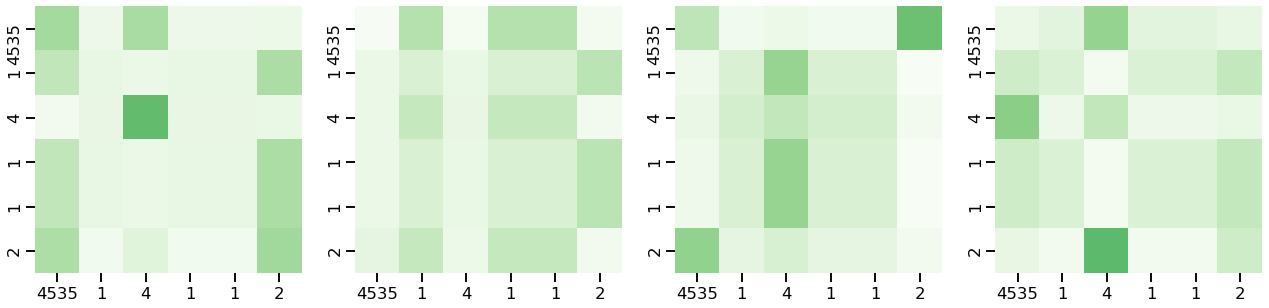

Encoder Layer 2


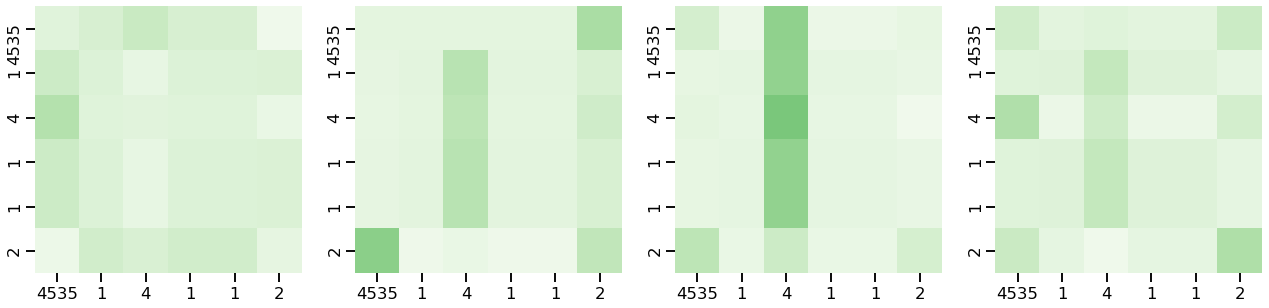



Ejemplo de tweet con label  denying  y Tw_id  775117135924367362
Encoder Layer 1


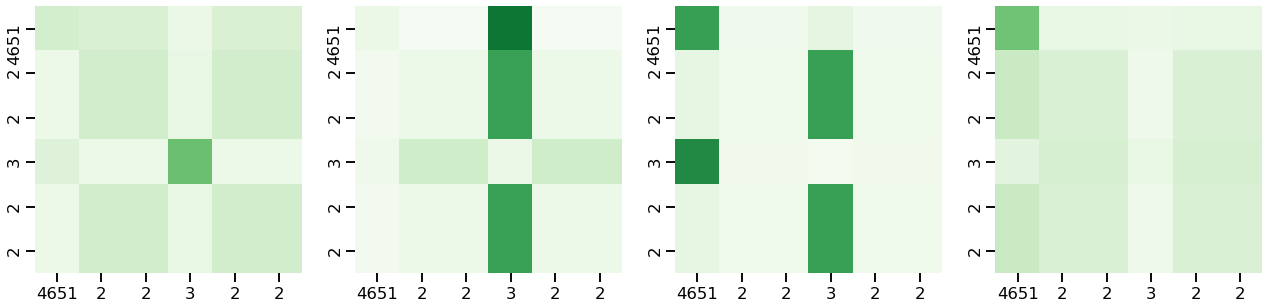

Encoder Layer 2


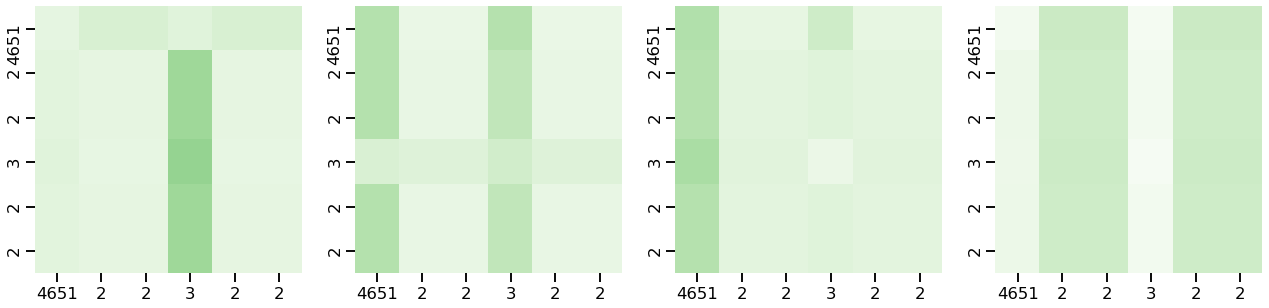



Ejemplo de tweet con label  questioning  y Tw_id  581154859715530752
Encoder Layer 1


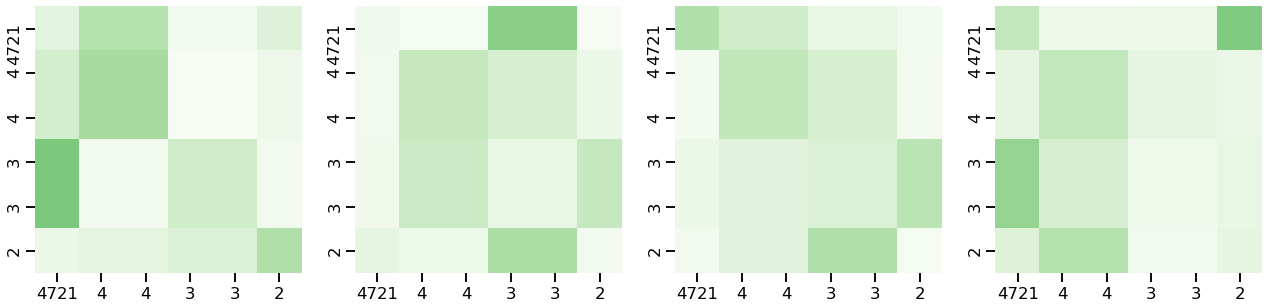

Encoder Layer 2


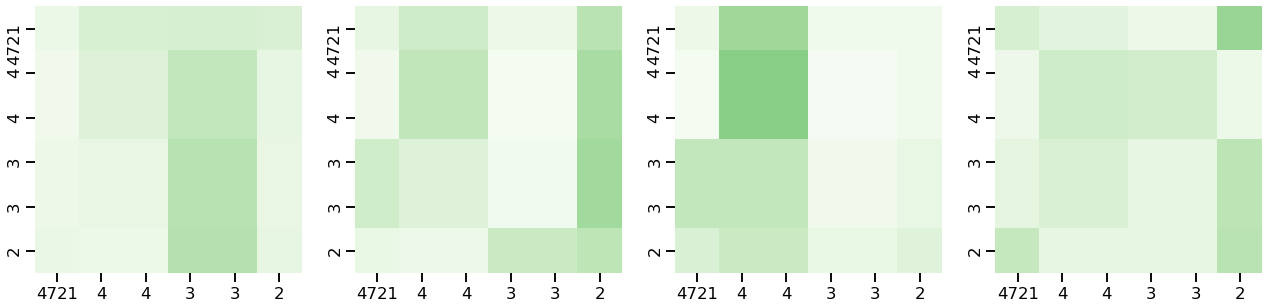

Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.243 	F-macro_val: 0.206
Epoch 10 	acc_val: 0.285 	F-macro_val: 0.250
Epoch 20 	acc_val: 0.382 	F-macro_val: 0.353
Epoch 30 	acc_val: 0.472 	F-macro_val: 0.413
Epoch 40 	acc_val: 0.507 	F-macro_val: 0.446
Epoch 50 	acc_val: 0.535 	F-macro_val: 0.464
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


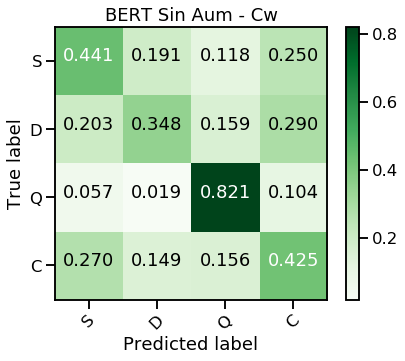

Test_ acc: 0.4622918707149853
Test_ f1 none: [0.183 0.214 0.523 0.572]
Test_ f1 macro: 0.3729761174266518
Entrenando Run # 11
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.365 	F-macro_val: 0.261
Epoch 10 	acc_val: 0.438 	F-macro_val: 0.356
Epoch 20 	acc_val: 0.458 	F-macro_val: 0.409
Epoch 30 	acc_val: 0.521 	F-macro_val: 0.447
Epoch 40 	acc_val: 0.542 	F-macro_val: 0.465
Epoch 50 	acc_val: 0.566 	F-macro_val: 0.478
Testing run # 11
SE TUVIERON QUE REPETIR 3 EJEMPLOS


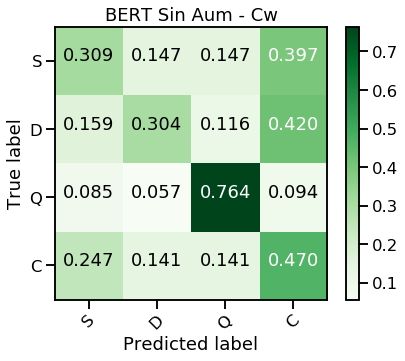

Test_ acc: 0.4789422135161606
Test_ f1 none: [0.14  0.194 0.514 0.605]
Test_ f1 macro: 0.3633059300342598
Entrenando Run # 12
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.288 	F-macro_val: 0.245
Epoch 10 	acc_val: 0.406 	F-macro_val: 0.358
Epoch 20 	acc_val: 0.399 	F-macro_val: 0.363
Epoch 30 	acc_val: 0.424 	F-macro_val: 0.401
Epoch 40 	acc_val: 0.451 	F-macro_val: 0.401
Epoch 50 	acc_val: 0.476 	F-macro_val: 0.427
Testing run # 12
SE TUVIERON QUE REPETIR 3 EJEMPLOS


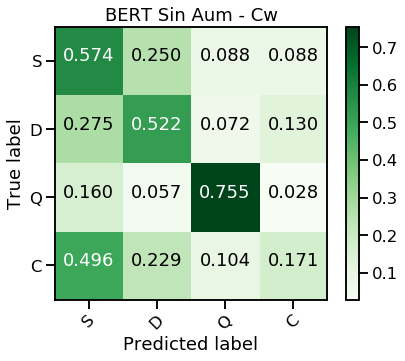

Test_ acc: 0.2820763956904995
Test_ f1 none: [0.147 0.235 0.576 0.286]
Test_ f1 macro: 0.3111527718880713
Entrenando Run # 13
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.149 	F-macro_val: 0.121
Epoch 10 	acc_val: 0.264 	F-macro_val: 0.213
Epoch 20 	acc_val: 0.465 	F-macro_val: 0.414
Epoch 30 	acc_val: 0.625 	F-macro_val: 0.498
Epoch 40 	acc_val: 0.628 	F-macro_val: 0.498
Epoch 50 	acc_val: 0.639 	F-macro_val: 0.507
Testing run # 13
SE TUVIERON QUE REPETIR 3 EJEMPLOS


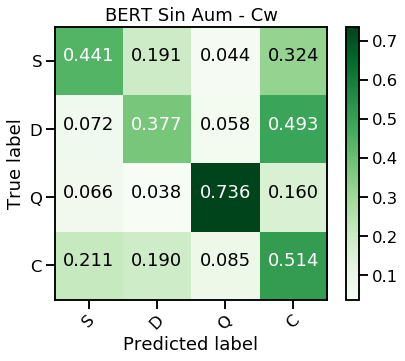

Test_ acc: 0.5230166503428012
Test_ f1 none: [0.219 0.2   0.607 0.639]
Test_ f1 macro: 0.4163676006282366
Entrenando Run # 14
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.396 	F-macro_val: 0.244
Epoch 10 	acc_val: 0.406 	F-macro_val: 0.250
Epoch 20 	acc_val: 0.361 	F-macro_val: 0.315
Epoch 30 	acc_val: 0.417 	F-macro_val: 0.380
Epoch 40 	acc_val: 0.451 	F-macro_val: 0.407
Epoch 50 	acc_val: 0.507 	F-macro_val: 0.445
Testing run # 14
SE TUVIERON QUE REPETIR 3 EJEMPLOS


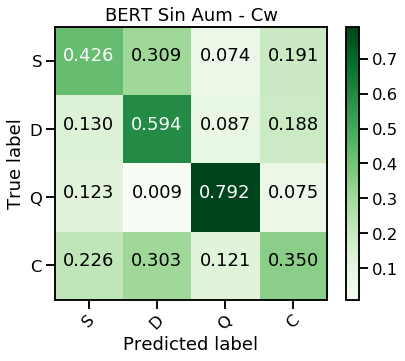

Test_ acc: 0.41723800195886385
Test_ f1 none: [0.197 0.223 0.569 0.502]
Test_ f1 macro: 0.3726932000804901
Entrenando Run # 15
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.111 	F-macro_val: 0.107
Epoch 10 	acc_val: 0.243 	F-macro_val: 0.259
Epoch 20 	acc_val: 0.274 	F-macro_val: 0.290
Epoch 30 	acc_val: 0.295 	F-macro_val: 0.295
Epoch 40 	acc_val: 0.434 	F-macro_val: 0.395
Epoch 50 	acc_val: 0.465 	F-macro_val: 0.418
Testing run # 15
SE TUVIERON QUE REPETIR 3 EJEMPLOS


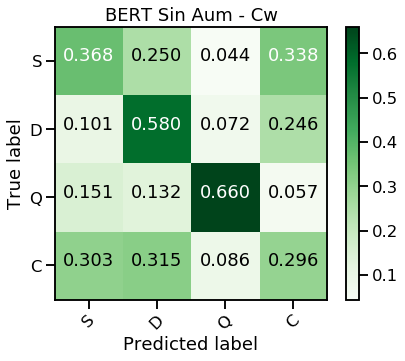

Test_ acc: 0.3574926542605289
Test_ f1 none: [0.142 0.208 0.558 0.436]
Test_ f1 macro: 0.33600980605290215
Entrenando Run # 16
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.354 	F-macro_val: 0.271
Epoch 10 	acc_val: 0.448 	F-macro_val: 0.360
Epoch 20 	acc_val: 0.486 	F-macro_val: 0.444
Epoch 30 	acc_val: 0.566 	F-macro_val: 0.493
Epoch 40 	acc_val: 0.611 	F-macro_val: 0.515
Epoch 50 	acc_val: 0.632 	F-macro_val: 0.538
Testing run # 16
SE TUVIERON QUE REPETIR 3 EJEMPLOS


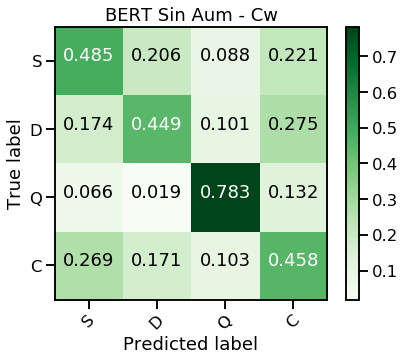

Test_ acc: 0.4926542605288932
Test_ f1 none: [0.201 0.249 0.589 0.602]
Test_ f1 macro: 0.4101563088172665
Entrenando Run # 17
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.264 	F-macro_val: 0.207
Epoch 10 	acc_val: 0.448 	F-macro_val: 0.329
Epoch 20 	acc_val: 0.479 	F-macro_val: 0.420
Epoch 30 	acc_val: 0.625 	F-macro_val: 0.498
Epoch 40 	acc_val: 0.660 	F-macro_val: 0.512
Epoch 50 	acc_val: 0.677 	F-macro_val: 0.527
Testing run # 17
SE TUVIERON QUE REPETIR 3 EJEMPLOS


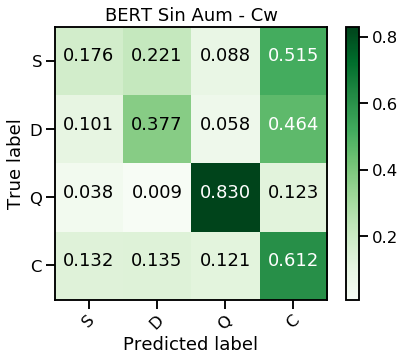

Test_ acc: 0.5896180215475024
Test_ f1 none: [0.124 0.241 0.591 0.714]
Test_ f1 macro: 0.4171748215508396
Entrenando Run # 18
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.135 	F-macro_val: 0.099
Epoch 10 	acc_val: 0.201 	F-macro_val: 0.186
Epoch 20 	acc_val: 0.403 	F-macro_val: 0.342
Epoch 30 	acc_val: 0.566 	F-macro_val: 0.458
Epoch 40 	acc_val: 0.566 	F-macro_val: 0.492
Epoch 50 	acc_val: 0.594 	F-macro_val: 0.522
Testing run # 18
SE TUVIERON QUE REPETIR 3 EJEMPLOS


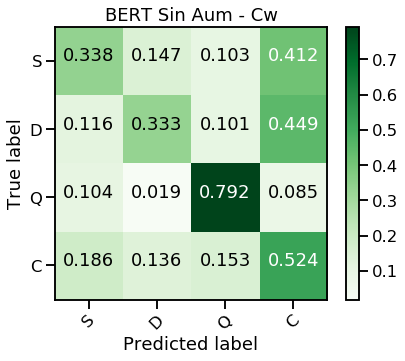

Test_ acc: 0.5269343780607247
Test_ f1 none: [0.18  0.219 0.52  0.651]
Test_ f1 macro: 0.3925703295672336
Entrenando Run # 19
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.323 	F-macro_val: 0.233
Epoch 10 	acc_val: 0.337 	F-macro_val: 0.298
Epoch 20 	acc_val: 0.312 	F-macro_val: 0.315
Epoch 30 	acc_val: 0.319 	F-macro_val: 0.314
Epoch 40 	acc_val: 0.333 	F-macro_val: 0.325
Epoch 50 	acc_val: 0.451 	F-macro_val: 0.430
Testing run # 19
SE TUVIERON QUE REPETIR 3 EJEMPLOS


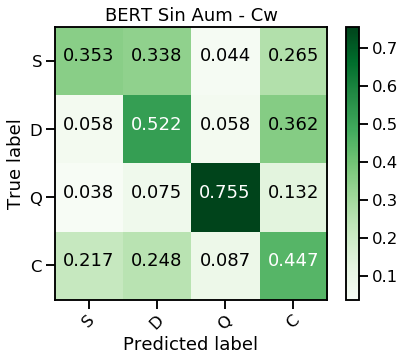

Test_ acc: 0.4779627815866797
Test_ f1 none: [0.178 0.219 0.613 0.588]
Test_ f1 macro: 0.39966130215418416
Entrenando Run # 20
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.278 	F-macro_val: 0.190
Epoch 10 	acc_val: 0.316 	F-macro_val: 0.262
Epoch 20 	acc_val: 0.365 	F-macro_val: 0.339
Epoch 30 	acc_val: 0.368 	F-macro_val: 0.340
Epoch 40 	acc_val: 0.441 	F-macro_val: 0.394
Epoch 50 	acc_val: 0.469 	F-macro_val: 0.409
Testing run # 20
SE TUVIERON QUE REPETIR 3 EJEMPLOS


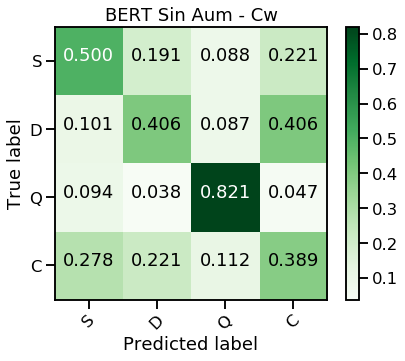

Test_ acc: 0.4427032321253673
Test_ f1 none: [0.203 0.196 0.596 0.537]
Test_ f1 macro: 0.3828594686202992


In [13]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
best_macro={'F_ma':0.1 , 'Run':0}

prob=0.0
bs=32

for x in range(1,21): 
    print ("Entrenando Run #", x)
    cnn1 = load_model(path_m+str(prob)+'cw/cnn1_'+str(x)+'-exec.h5')
    cnn2 = load_model(path_m+str(prob)+'cw/cnn2_'+str(x)+'-exec.h5')
    rnn1 = load_model(path_m+str(prob)+'cw/rnn1_'+str(x)+'-exec.h5')
    rnn2 = load_model(path_m+str(prob)+'cw/rnn2_'+str(x)+'-exec.h5')
    rnn3 = load_model(path_m+str(prob)+'cw/rnn3_'+str(x)+'-exec.h5')

    list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
    index_models=np.arange(5)
    dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
    modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
    ind=np.arange(5)
    dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]
    
    print ("agregando predicciones Train")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
    print ("agregando predicciones Val")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
    print ("agregando predicciones Test")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

    matrix=np.asarray(predicciones_all)
    matrix_val=np.asarray(predicciones_all_val)
    matrix_test=np.asarray(predicciones_all_test)
    new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)
    
    b_dim=768
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(sentences)):
        #ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
        vector=bc.encode([encoded_tok])[0]
        final_bert= vector
            
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    objs_val=val['Tw_id']      #df_val['Unnamed: 0'].values
    objs_test=test['Tw_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
      
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
        vector=bc.encode([encoded_tok])[0]
        final_bert= vector

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    
    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    hist_train_loss=[]
    hist_train_acc=[]
    hist_train_fma=[]
    hist_val_loss=[]
    hist_val_acc=[]
    hist_val_fma=[]
    
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, K_list_new, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

    
    for epoch in range(60):
        model.train()
        DATA=data_gen(bs, 'Train', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)  
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        DATA_V=data_gen(bs, 'Val', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)  
            
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(DATA_V, model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())
    
    model.eval()
    print ("Testing run #",x)
    DATA_T=data_gen(bs, 'Test', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)  
            
    predicciones = run_epoch(DATA_T, model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-3])
    glo_fno=f1_score(etiq_t,predicciones[:-3], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-3], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-3])

    plot_cm(cm_norma(glo_cm),["S","D","Q","C"],"BERT Sin Aum - Cw", cmap="Greens")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

    if glo_fma>best_macro['F_ma']:
        best_macro['F_ma']=glo_fma
        best_macro['Run']=x                
        tope=4520

        for key in keys: 
            mask_s=test["Label"]==key
            q_tid=np.random.choice(test["Tw_id"][mask_s])
            q_ide=list(test["Tw_id"].values).index(q_tid)

            model.eval()

            temp2= [tope + q_ide]

            for m in range(n_machines): 
                temp2= temp2 + [np.argmax(matrix_test[m][q_ide])+1] 

            sent = [temp2]
            src = torch.LongTensor([w for w in sent])
            src = Variable(src)
            src_mask = src_mask=  (src != 0).unsqueeze(-2)
            out = model.forward(src, src_mask)
            print ("\n\nEjemplo de tweet con label ", key, " y Tw_id ", q_tid)
            for layer in range(2):
                fig, axs = plt.subplots(1,4, figsize=(22,11))
                print("Encoder Layer", layer+1)
                for h in range(4):
                    draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
                            axs[h], sent, color="Greens")
                plt.show()

In [14]:
best_macro

{'F_ma': 0.4598860211772537, 'Run': 9}

Acc: 0.466 -- deviation: 0.079
F-score: 0.384 -- deviation: 0.035
(0.0CW) SDQC: 0.18787212724697436 0.2188246002277126 0.5654782185013323 0.5649121657661392


Confusion counts
[[ 567.  273.  119.  401.]
 [ 175.  602.  122.  481.]
 [ 175.   94. 1637.  214.]
 [3835. 3176. 1836. 6713.]]


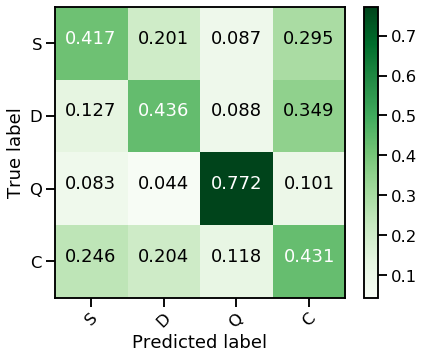

In [15]:
print ("Acc: %.3f" % np.mean(np.asarray(global_accs)), "-- deviation: %.3f" % np.std(np.asarray(global_accs)))
print ("F-score: %.3f" % np.mean(np.asarray(global_fmacros)), "-- deviation: %.3f" % np.std(np.asarray(global_fmacros)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.0CW) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S","D","Q","C"], "", cmap='Greens')

## Con aumento de datos

### 0.15

In [16]:
bc = BertClient()  

class_weights= np.asarray([1.0, 1.0, 1.0, 1.0])
path_a='../../../Datasets/CSV_Stance/Aumento_ofi/' 

print ("Pesos de clases:", class_weights)

Pesos de clases: [1. 1. 1. 1.]


In [17]:
def train_transformer(prob, num_epochs, path_a, path_m, c_gama,  xfrom=1, xto=20):    
    global_accs=[]
    global_fnones=[]
    global_fmacros=[]
    global_cms=[]
    global_attn=[]
    best_macro={'F_ma':0.1 , 'Run':0}

    bs=32

    for x in range(xfrom, xto + 1):

        macro_augmented= np.load(path_a + 'balance_GloVe_' + str(int(prob*100)) + '_'+ str(x)+'_run.npy', allow_pickle=True)

        ids_train=macro_augmented[:,0]
        tws_train=macro_augmented[:,1]
        labels_train=macro_augmented[:,2]
        class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
        print ("Pesos de clases:", class_weights)

        etiq=np.asarray(labels_train)
        sentences = tws_train
        n_labels = etiq.copy()
        y_train=to_categorical(n_labels,num_classes=4)

        input_ids=[]
        for sent in sentences:
            encoded_sent=[]
            for wd in sent:
                try:
                    encoded_sent.append(token_2_idx[wd])
                except:
                    continue
            input_ids.append(encoded_sent)

        input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
        shape=np.asarray(input_ids).shape

        x_train=np.zeros((shape[0], shape[1], emb))
        j=0
        for in_id in input_ids:
            x_train[j]=EMB_matrix[in_id]
            j+=1

        ################################################    
        print ("Entrenando Run #", x)
        cnn1 = load_model(path_m+str(prob)+'/cnn1_'+str(x)+'-exec.h5')
        cnn2 = load_model(path_m+str(prob)+'/cnn2_'+str(x)+'-exec.h5')
        rnn1 = load_model(path_m+str(prob)+'/rnn1_'+str(x)+'-exec.h5')
        rnn2 = load_model(path_m+str(prob)+'/rnn2_'+str(x)+'-exec.h5')
        rnn3 = load_model(path_m+str(prob)+'/rnn3_'+str(x)+'-exec.h5')

        list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
        index_models=np.arange(5)
        dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
        modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
        ind=np.arange(5)
        dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

        predicciones_all=[]
        predicciones_all_val=[]
        predicciones_all_test=[]

        print ("agregando predicciones Train")
        for i in dict_trainedModel.keys(): 
            a_evaluar=dict_models[i]
            predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
        print ("agregando predicciones Val")
        for i in dict_trainedModel.keys(): 
            a_evaluar=dict_models[i]
            predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
        print ("agregando predicciones Test")
        for i in dict_trainedModel.keys(): 
            a_evaluar=dict_models[i]
            predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

        matrix=np.asarray(predicciones_all)
        matrix_val=np.asarray(predicciones_all_val)
        matrix_test=np.asarray(predicciones_all_test)
        new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)

        b_dim=768
        espacio=[np.ones(b_dim)]
        Ks= ortho_group.rvs(dim=b_dim)
        random=np.random.randint(Ks.shape[0], size=4)
        K_list=Ks[random]
        K_list_ext=espacio+list(K_list)
        index_embeddings=[0,1,2,3,4]
        lab_str_embeddings=['','','','','']

        for i in range(len(sentences)):
            #ide=ids_train[i]
            tw_tr=tws_train[i]
            clase=dict_cl[labels_train[i]]            
            tw=' '.join([word for word in tw_tr])
            vector= bc.encode([tw])[0]
            final_bert= vector

            index_embeddings.append(i+5)
            lab_str_embeddings.append(clase)
            K_list_ext.append(final_bert)

        objs_val=val['Tw_id']      #df_val['Unnamed: 0'].values
        objs_test=test['Tw_id']    #np.arange(df_test.shape[0])
        lab_val=val['Label']
        lab_test=test['Label']
        tw_val=val['Tweet']
        tw_test=test['Tweet']
        llaves=np.concatenate([objs_val,objs_test])
        clases=np.concatenate([lab_val,lab_test])
        sent_all=np.concatenate([tw_val,tw_test])

        for num in range(len(llaves)):
            i=llaves[num]
            clase=clases[num]
            tw_tr=sent_all[num]
            encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
            vector=bc.encode([encoded_tok])[0]
            final_bert= vector

            index_embeddings.append(num+5+train.shape[0])
            lab_str_embeddings.append(clase)
            K_list_ext.append(final_bert)


        K_list_new= np.asarray(K_list_ext, dtype='float32')

        ###################################### TRANSFORMER ###############################
        hist_train_loss=[]
        hist_train_acc=[]
        hist_train_fma=[]
        hist_val_loss=[]
        hist_val_acc=[]
        hist_val_fma=[]

        V = 4
        pesos = torch.from_numpy(class_weights).float()
        criterion = FocalLoss(weights=pesos)
        model = make_model_concat(4, K_list_new, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
        model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))


        for epoch in range(num_epochs):
            model.train()
            DATA=data_gen(bs, 'Train', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)  
            loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')

            model.eval()
            DATA_VAL=data_gen(bs, 'Val', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)
            loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(DATA_VAL, model, SimpleLossComputeFL(criterion, None),'Val')
            if epoch%10==0:
                print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())

        model.eval()
        print ("Testing run #",x)
        DATA_TEST=data_gen(bs, 'Test', 5, new_matrix, matrix, matrix_val, matrix_test, lab_str_embeddings, index_embeddings)
        predicciones = run_epoch(DATA_TEST, model, SimpleLossComputeFL(criterion, None),'Test')
        predicciones=np.concatenate(predicciones, axis=-1)

        glo_acc=accuracy_score(etiq_t, predicciones[:-3])
        glo_fno=f1_score(etiq_t,predicciones[:-3], average=None)
        glo_fma=f1_score(etiq_t,predicciones[:-3], average='macro')

        glo_cm=confusion_matrix(etiq_t, predicciones[:-3])

        plot_cm(cm_norma(glo_cm),["S","D","Q","C"],"BERT Aum"+str(prob), cmap=c_gama)
        global_accs.append(glo_acc)
        global_fnones.append(glo_fno)
        global_fmacros.append(glo_fma)
        global_cms.append(glo_cm)
        print("Test_ acc:",glo_acc) 
        print("Test_ f1 none:",glo_fno) 
        print("Test_ f1 macro:",glo_fma) 

        if glo_fma>best_macro['F_ma']:
            best_macro['F_ma']=glo_fma
            best_macro['Run']=x                
            tope=4520

            for key in keys: 
                mask_s=test["Label"]==key
                q_tid=np.random.choice(test["Tw_id"][mask_s])
                q_ide=list(test["Tw_id"].values).index(q_tid)

                model.eval()

                temp2= [tope + q_ide]

                for m in range(n_machines): 
                    temp2= temp2 + [np.argmax(matrix_test[m][q_ide])+1] 

                sent = [temp2]
                src = torch.LongTensor([w for w in sent])
                src = Variable(src)
                src_mask = src_mask=  (src != 0).unsqueeze(-2)
                out = model.forward(src, src_mask)
                print ("\n\nEjemplo de tweet con label ", key, " y Tw_id ", q_tid)
                for layer in range(2):
                    fig, axs = plt.subplots(1,4, figsize=(22,11))
                    print("Encoder Layer", layer+1)
                    for h in range(4):
                        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
                            axs[h], sent, color=c_gama)
                    plt.show()
                    
    return best_macro, global_accs, global_fnones, global_fmacros, global_cms

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.163 	F-macro_val: 0.125
Epoch 10 	acc_val: 0.719 	F-macro_val: 0.549
Epoch 20 	acc_val: 0.708 	F-macro_val: 0.533
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


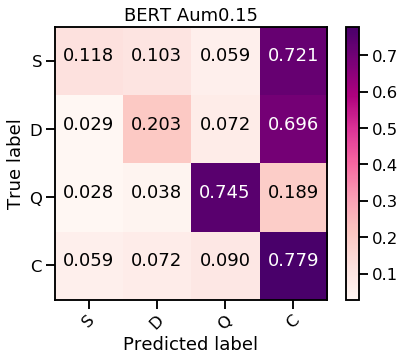

Test_ acc: 0.692458374142997
Test_ f1 none: [0.126 0.187 0.598 0.807]
Test_ f1 macro: 0.4296493648313039


Ejemplo de tweet con label  commenting  y Tw_id  544318276189159426
Encoder Layer 1


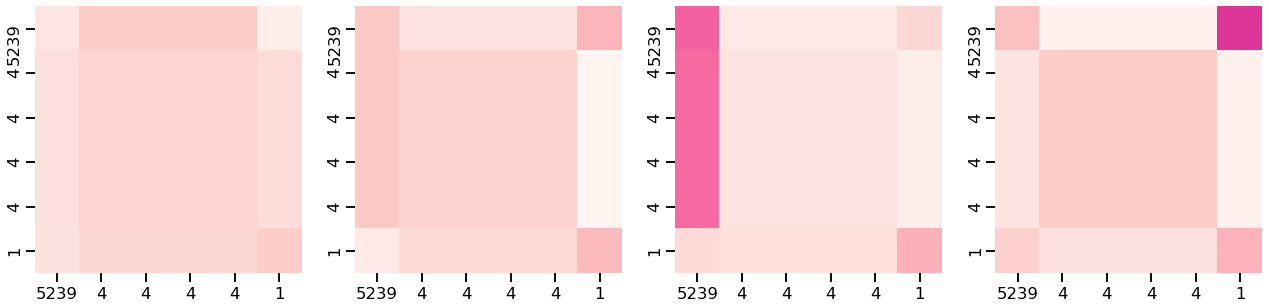

Encoder Layer 2


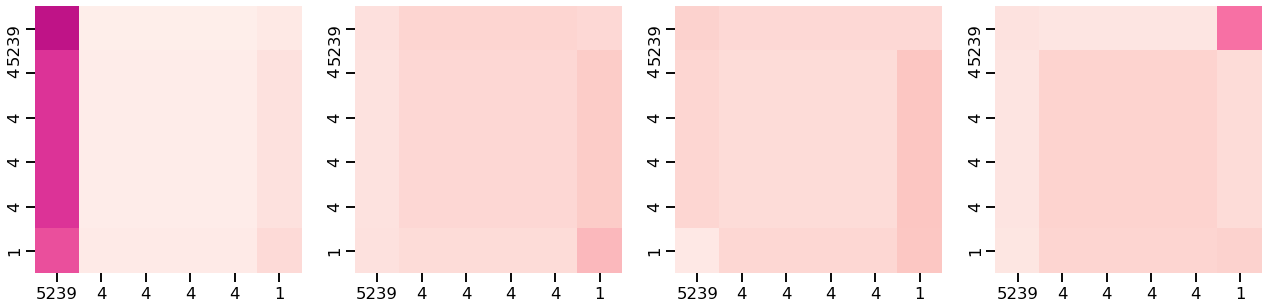



Ejemplo de tweet con label  support  y Tw_id  553574606259625984
Encoder Layer 1


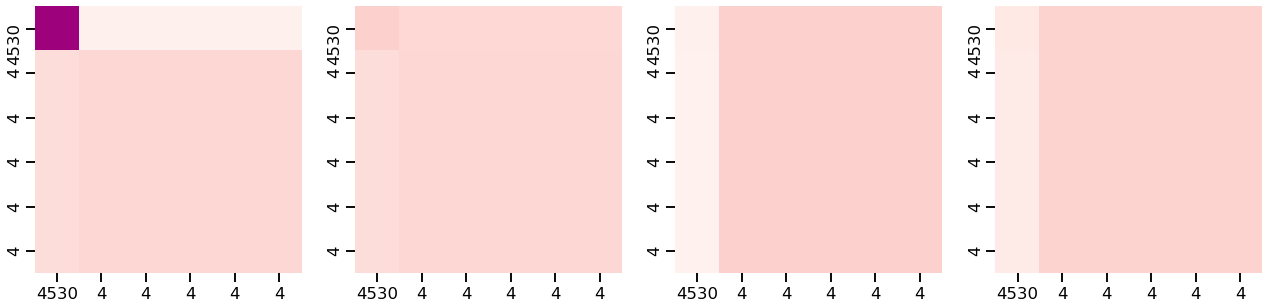

Encoder Layer 2


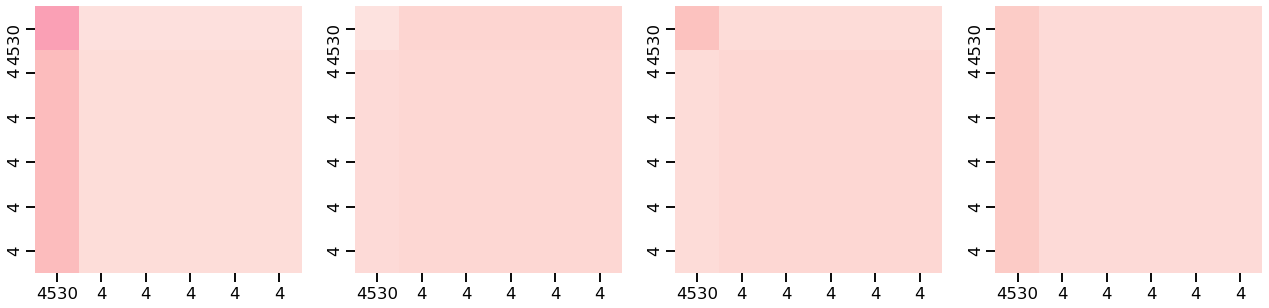



Ejemplo de tweet con label  denying  y Tw_id  758295910145204225
Encoder Layer 1


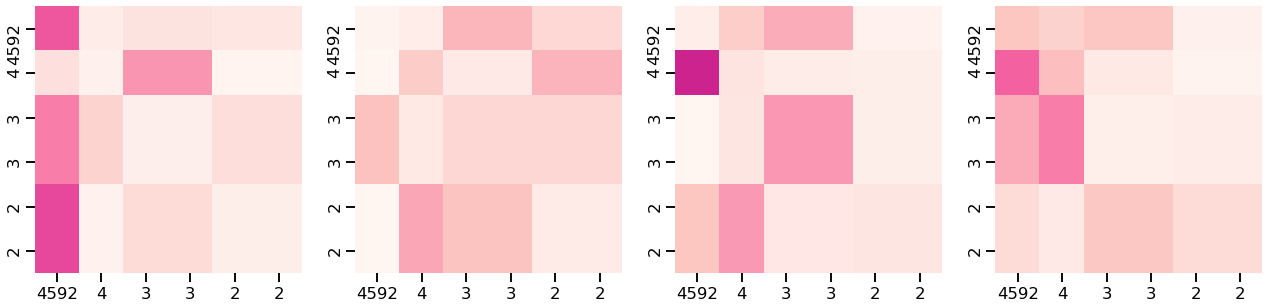

Encoder Layer 2


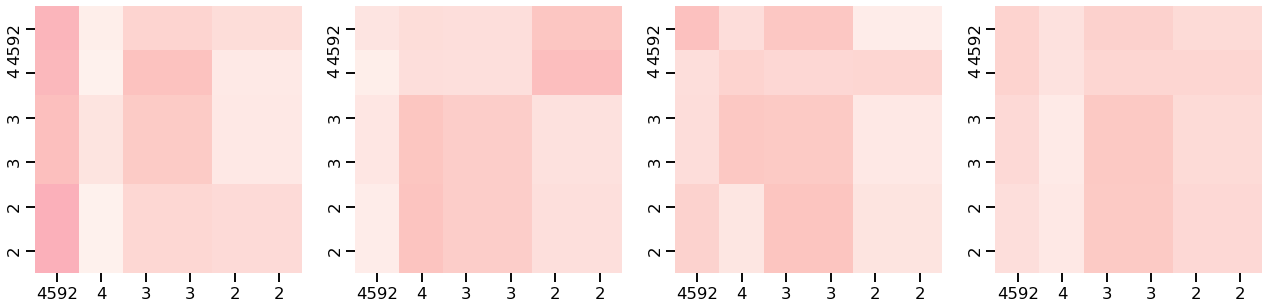



Ejemplo de tweet con label  questioning  y Tw_id  498334502041956352
Encoder Layer 1


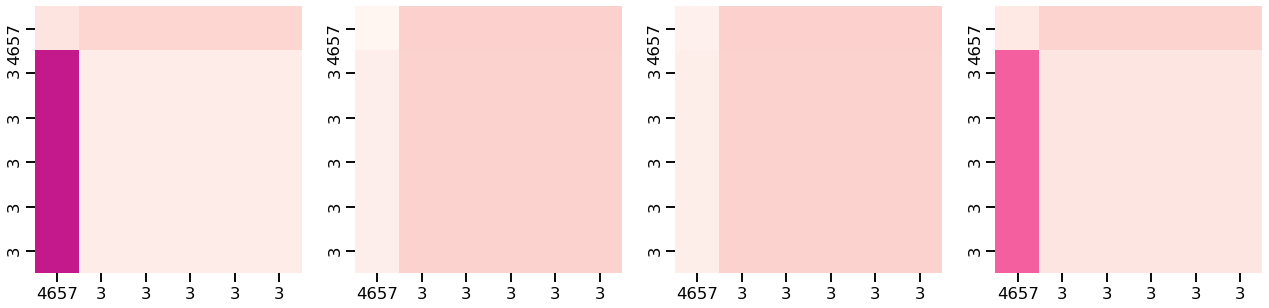

Encoder Layer 2


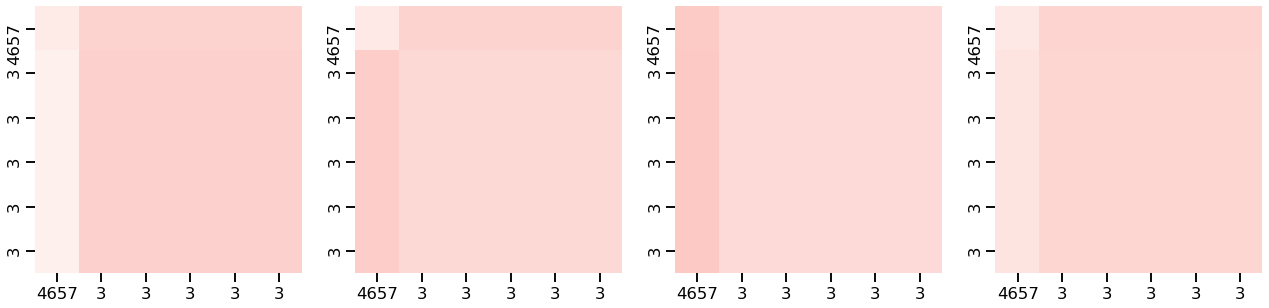

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.181 	F-macro_val: 0.156
Epoch 10 	acc_val: 0.639 	F-macro_val: 0.480
Epoch 20 	acc_val: 0.639 	F-macro_val: 0.486
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


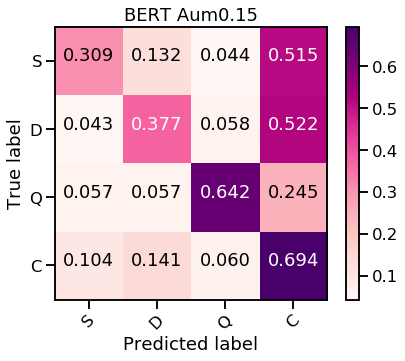

Test_ acc: 0.6415279138099902
Test_ f1 none: [0.235 0.236 0.596 0.763]
Test_ f1 macro: 0.45768565483360446


Ejemplo de tweet con label  commenting  y Tw_id  771202332776247298
Encoder Layer 1


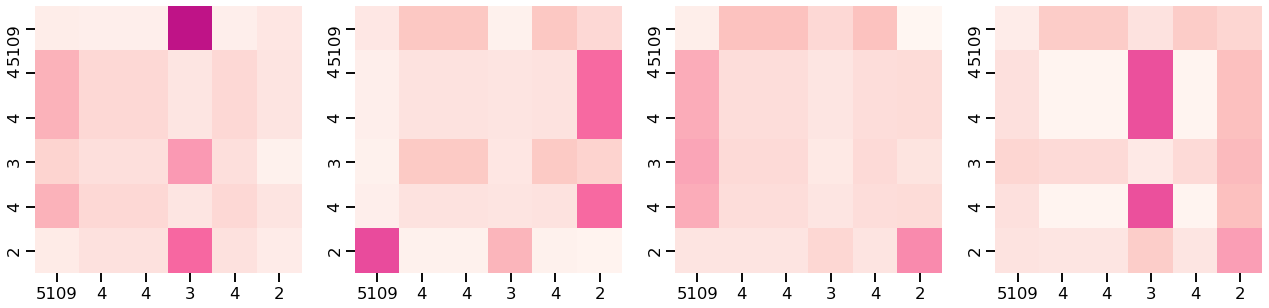

Encoder Layer 2


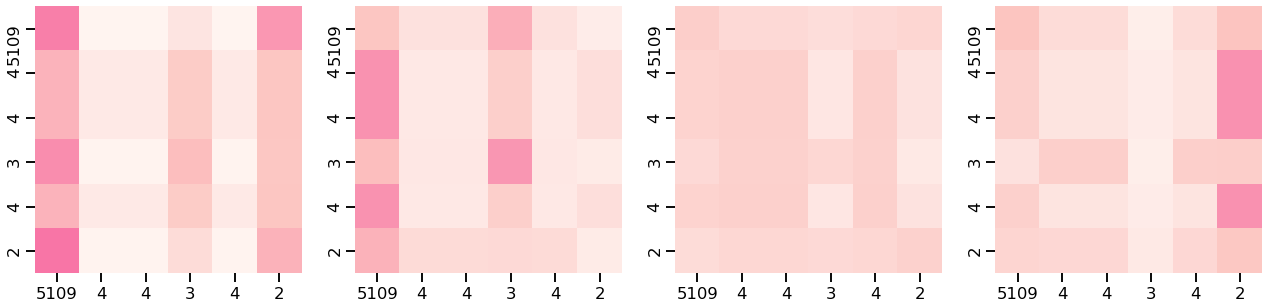



Ejemplo de tweet con label  support  y Tw_id  498295324029747200
Encoder Layer 1


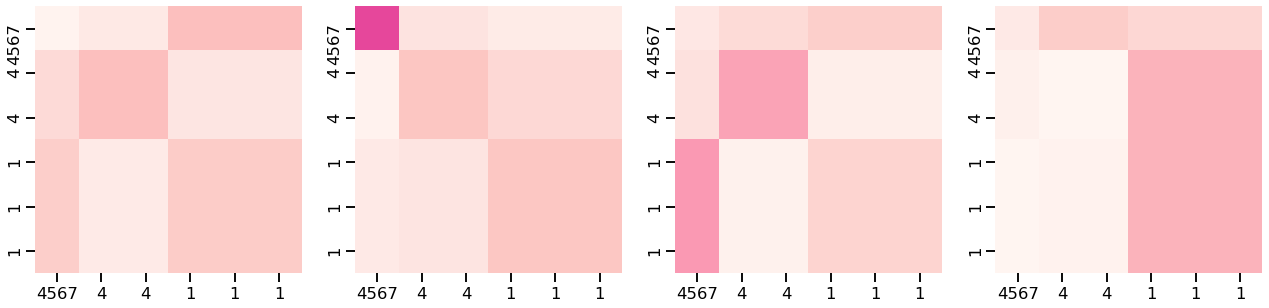

Encoder Layer 2


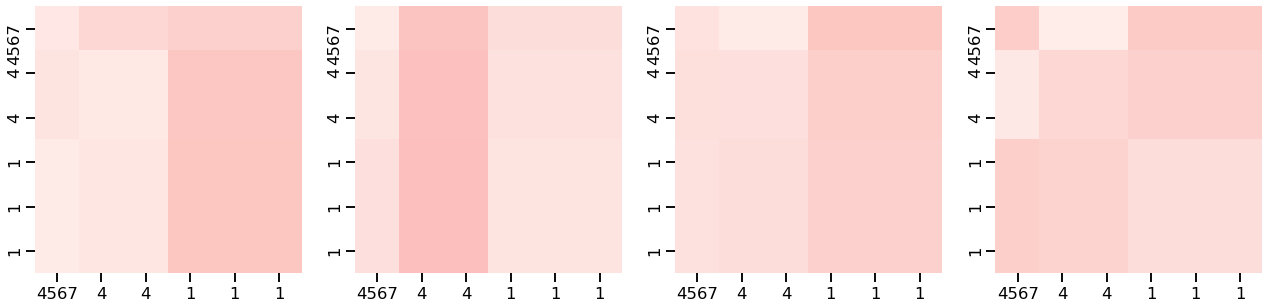



Ejemplo de tweet con label  denying  y Tw_id  765005656952713216
Encoder Layer 1


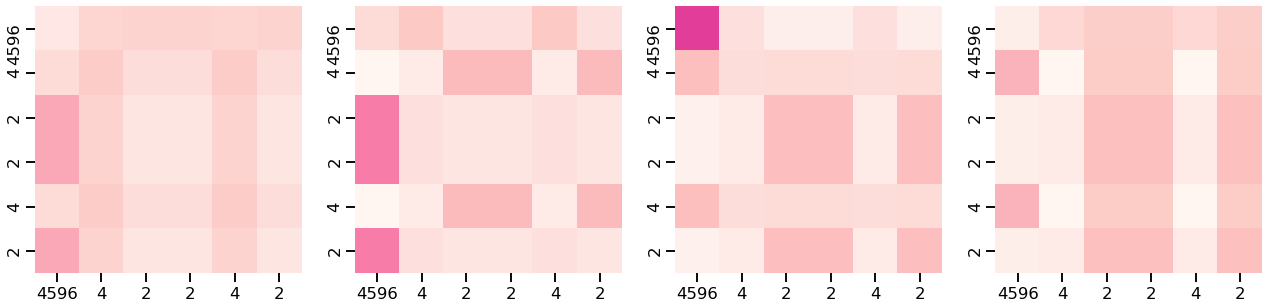

Encoder Layer 2


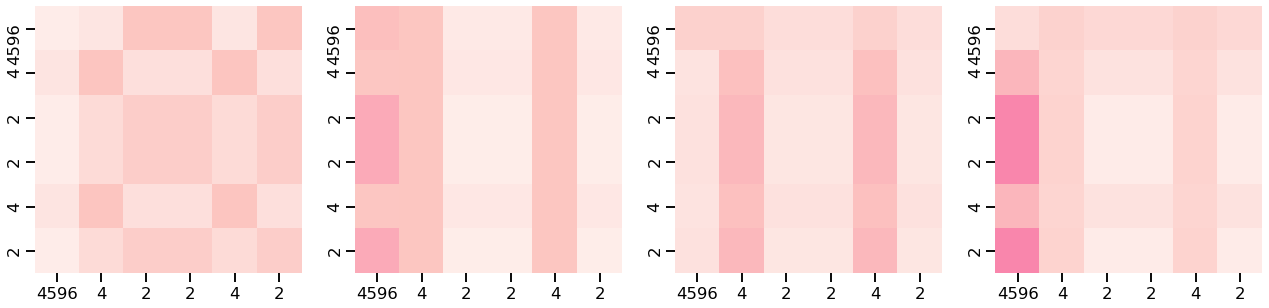



Ejemplo de tweet con label  questioning  y Tw_id  758288954848337920
Encoder Layer 1


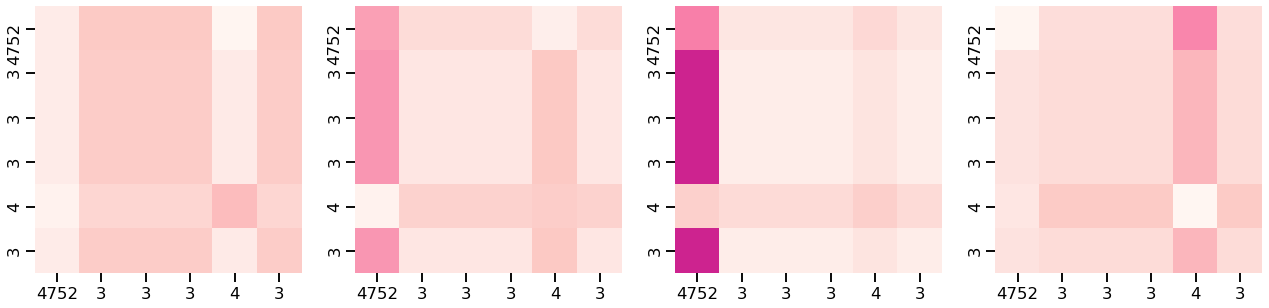

Encoder Layer 2


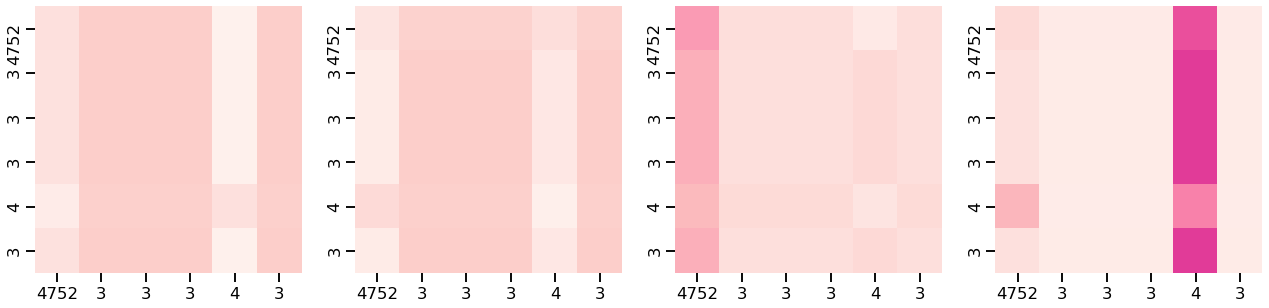

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.233 	F-macro_val: 0.196
Epoch 10 	acc_val: 0.646 	F-macro_val: 0.499
Epoch 20 	acc_val: 0.656 	F-macro_val: 0.501
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


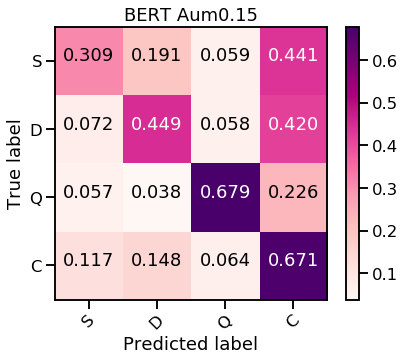

Test_ acc: 0.6327130264446621
Test_ f1 none: [0.22  0.267 0.61  0.755]
Test_ f1 macro: 0.4630467132342627


Ejemplo de tweet con label  commenting  y Tw_id  758707783642513408
Encoder Layer 1


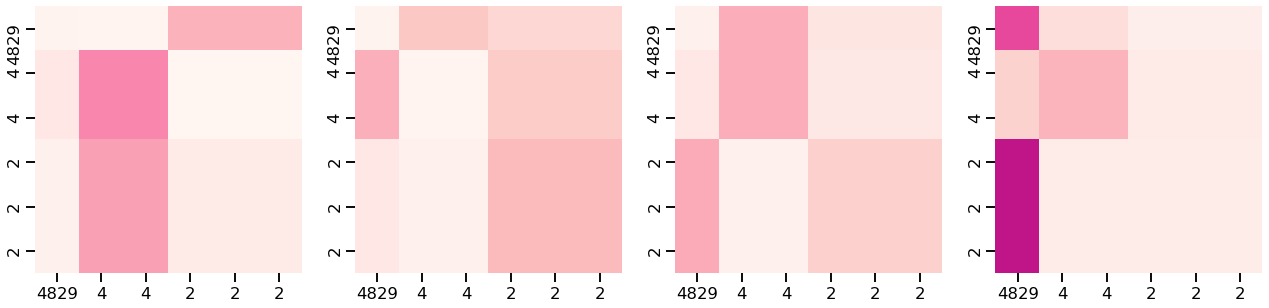

Encoder Layer 2


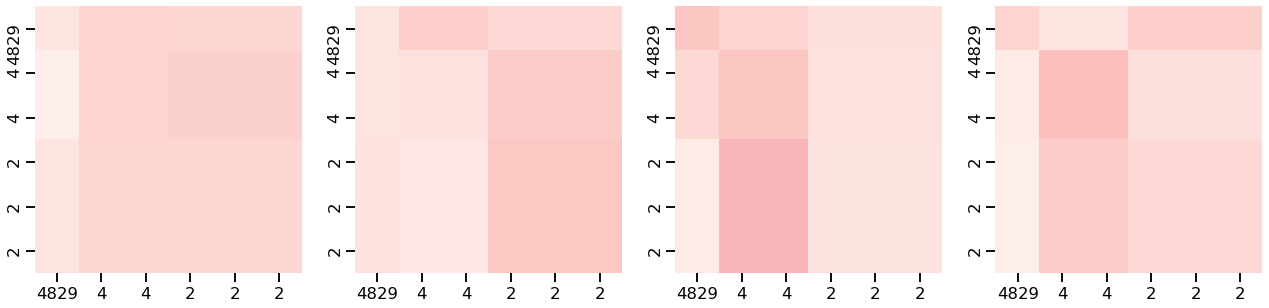



Ejemplo de tweet con label  support  y Tw_id  581307807053393920
Encoder Layer 1


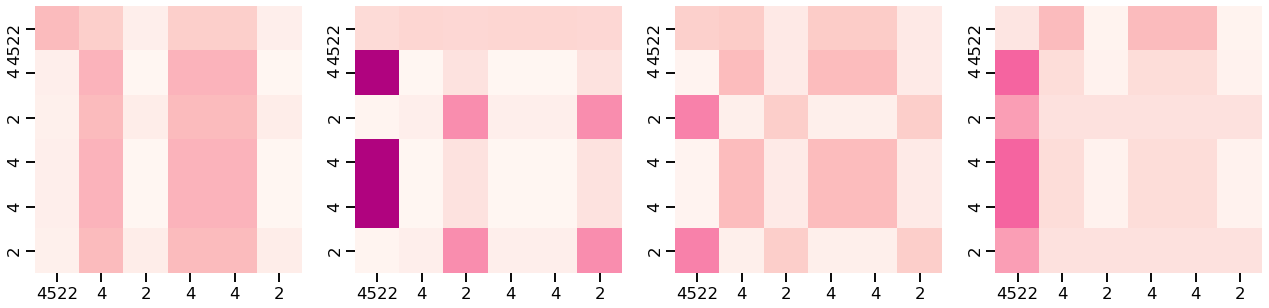

Encoder Layer 2


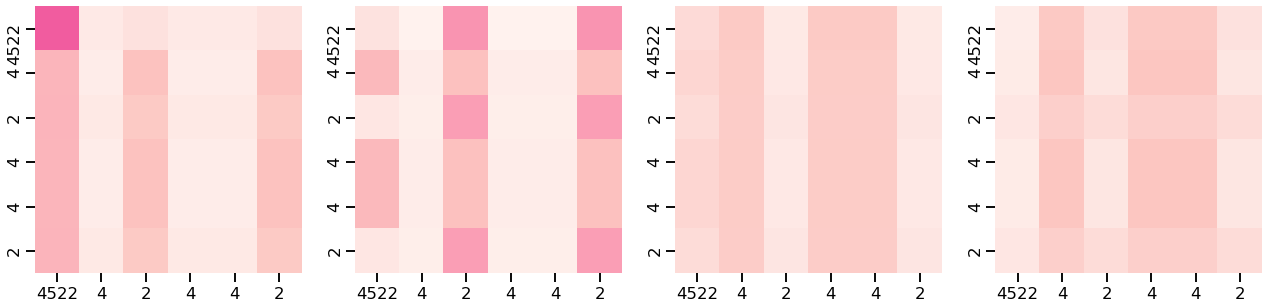



Ejemplo de tweet con label  denying  y Tw_id  498547612740763648
Encoder Layer 1


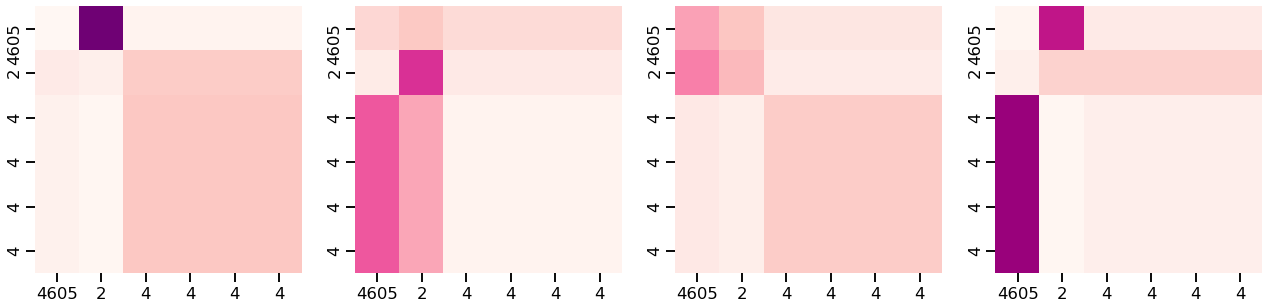

Encoder Layer 2


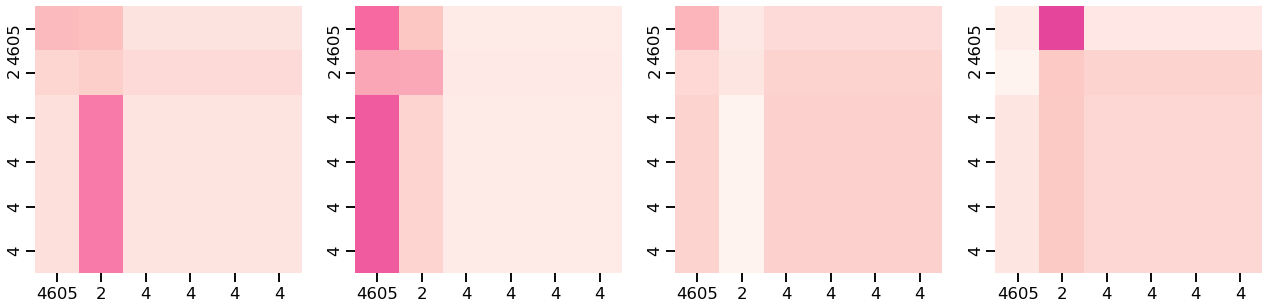



Ejemplo de tweet con label  questioning  y Tw_id  553556691522838529
Encoder Layer 1


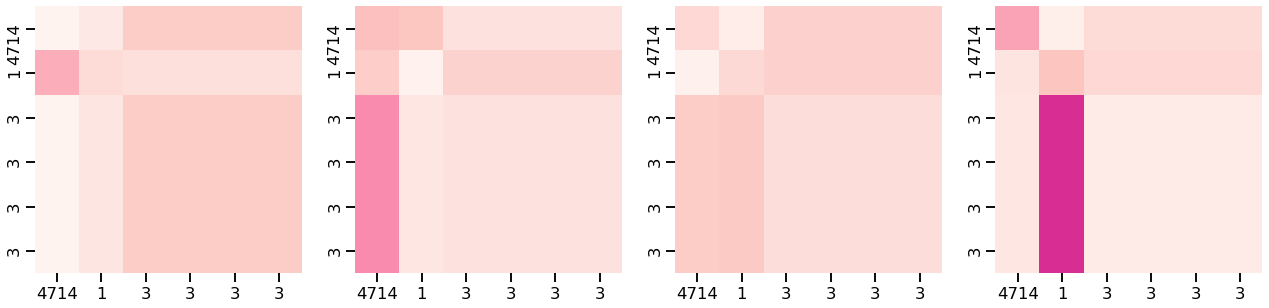

Encoder Layer 2


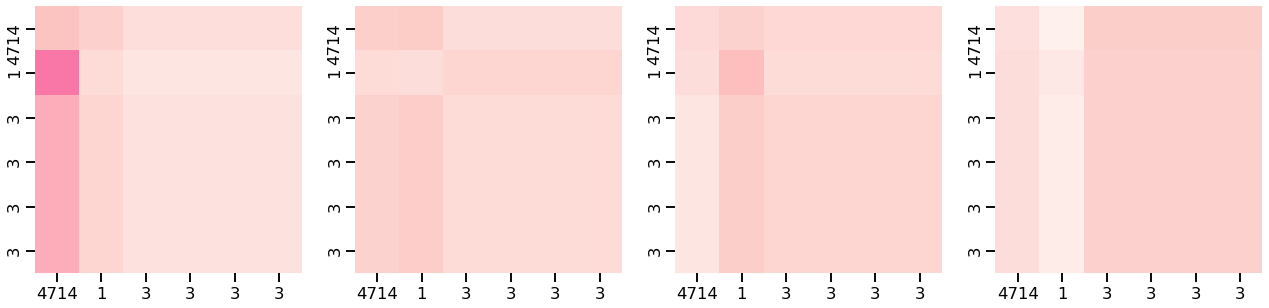

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.163 	F-macro_val: 0.207
Epoch 10 	acc_val: 0.677 	F-macro_val: 0.526
Epoch 20 	acc_val: 0.701 	F-macro_val: 0.514
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


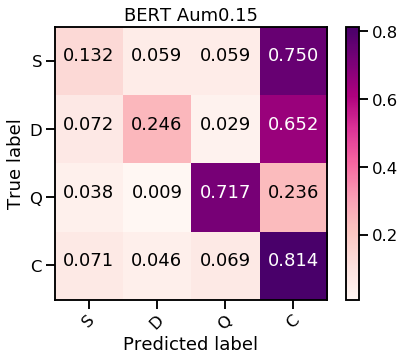

Test_ acc: 0.7198824681684622
Test_ f1 none: [0.128 0.268 0.628 0.826]
Test_ f1 macro: 0.46246151015875786
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.434 	F-macro_val: 0.313
Epoch 10 	acc_val: 0.663 	F-macro_val: 0.520
Epoch 20 	acc_val: 0.677 	F-macro_val: 0.534
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


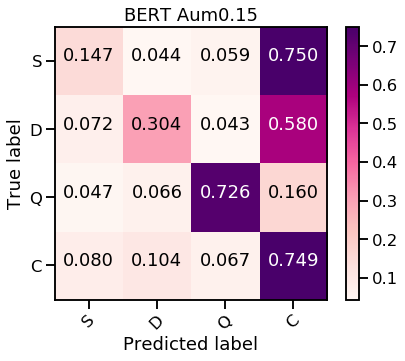

Test_ acc: 0.6767874632713027
Test_ f1 none: [0.133 0.232 0.636 0.794]
Test_ f1 macro: 0.44886960120177744
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.354 	F-macro_val: 0.269
Epoch 10 	acc_val: 0.705 	F-macro_val: 0.512
Epoch 20 	acc_val: 0.705 	F-macro_val: 0.517
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


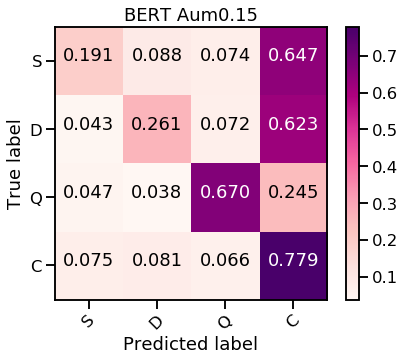

Test_ acc: 0.693437806072478
Test_ f1 none: [0.177 0.225 0.597 0.81 ]
Test_ f1 macro: 0.4520321605596146
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.278 	F-macro_val: 0.175
Epoch 10 	acc_val: 0.688 	F-macro_val: 0.542
Epoch 20 	acc_val: 0.694 	F-macro_val: 0.549
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


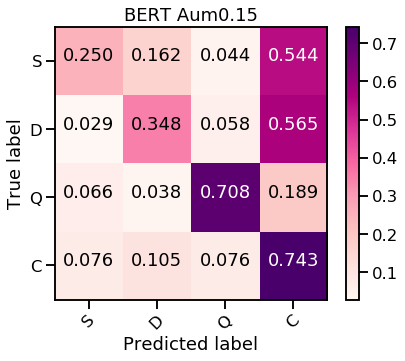

Test_ acc: 0.6797257590597453
Test_ f1 none: [0.222 0.253 0.607 0.796]
Test_ f1 macro: 0.4695711253127521


Ejemplo de tweet con label  commenting  y Tw_id  758297519654834176
Encoder Layer 1


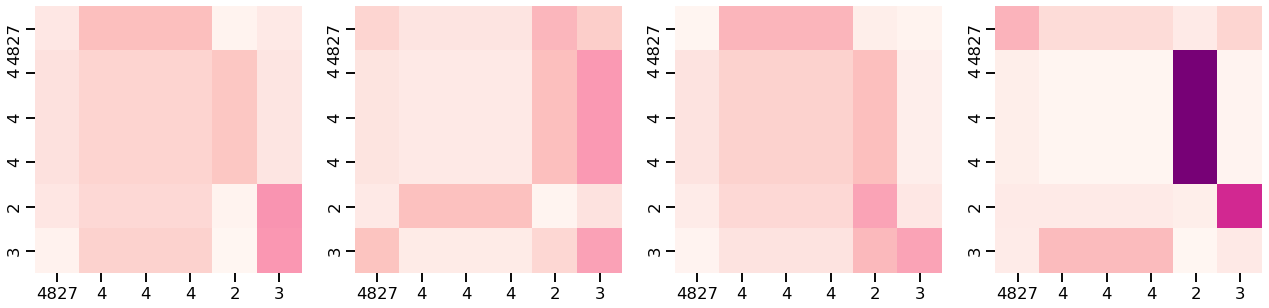

Encoder Layer 2


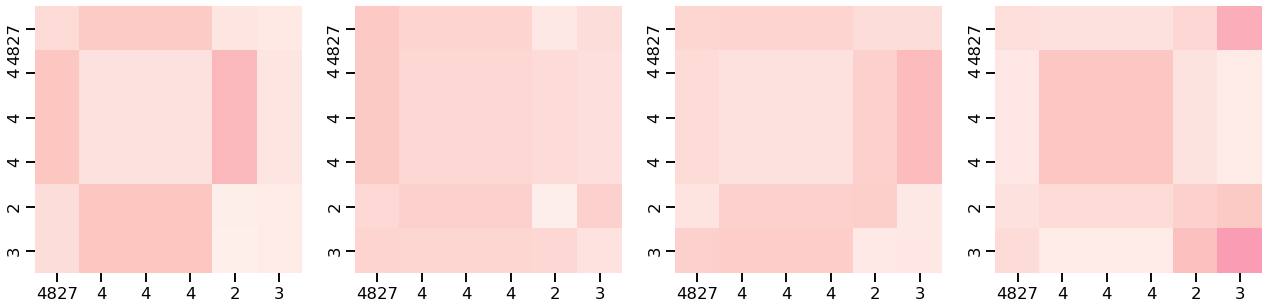



Ejemplo de tweet con label  support  y Tw_id  581157167220277248
Encoder Layer 1


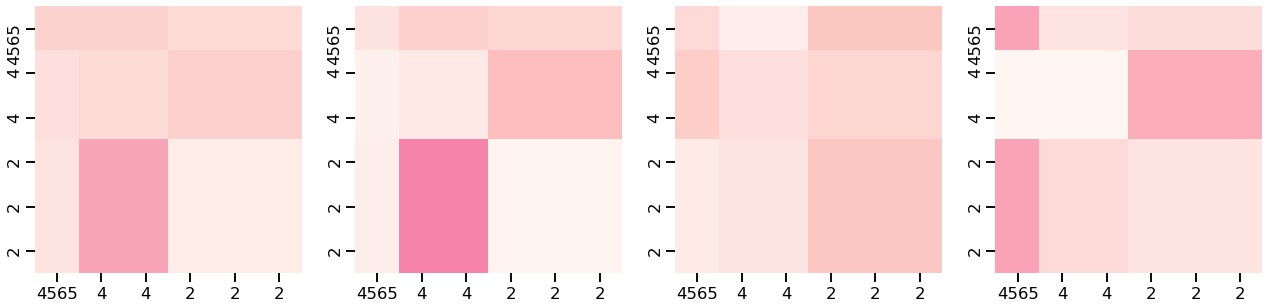

Encoder Layer 2


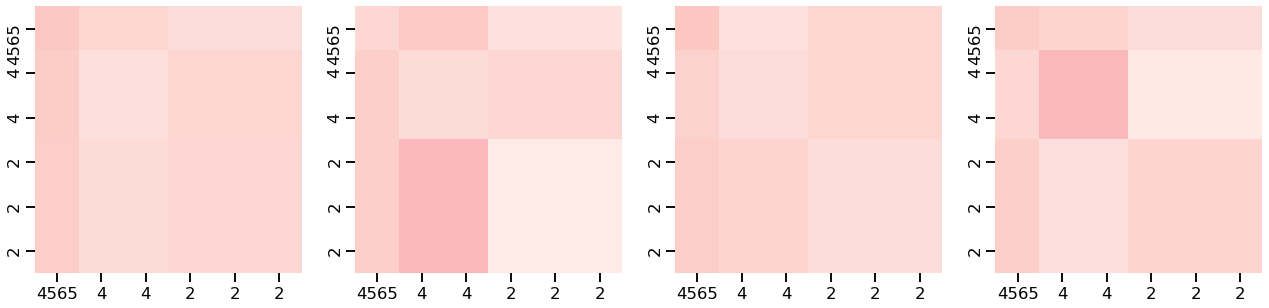



Ejemplo de tweet con label  denying  y Tw_id  580355626926231552
Encoder Layer 1


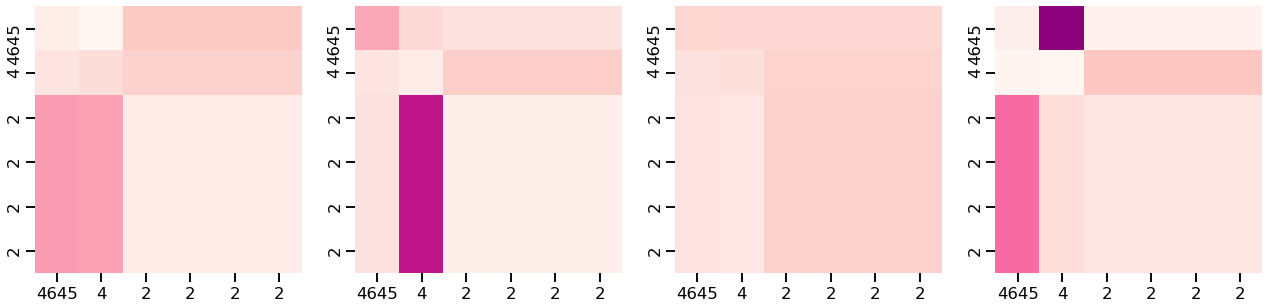

Encoder Layer 2


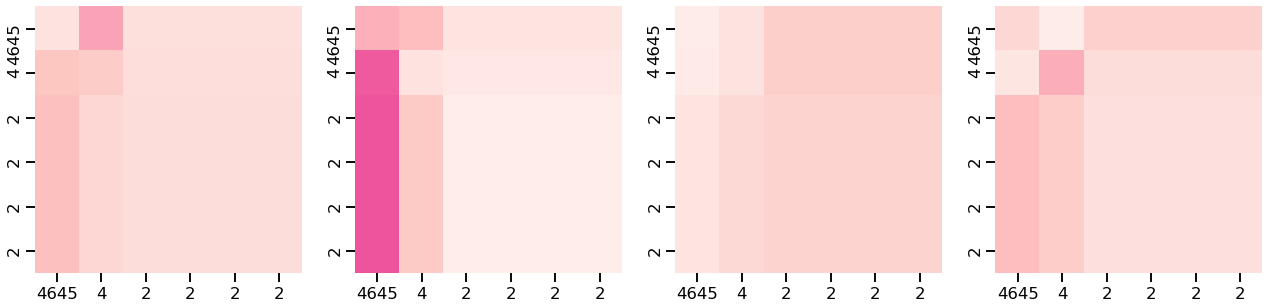



Ejemplo de tweet con label  questioning  y Tw_id  553561531791974400
Encoder Layer 1


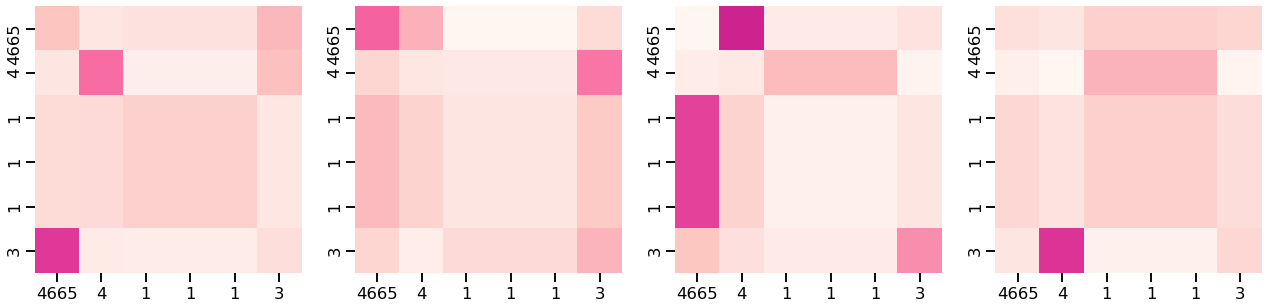

Encoder Layer 2


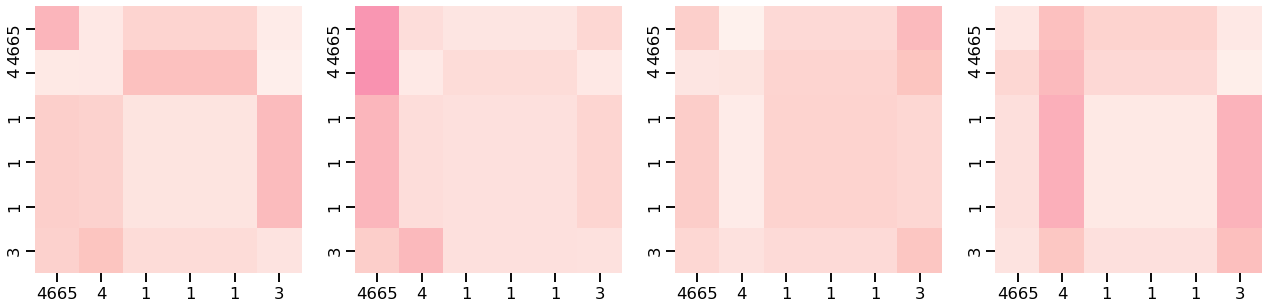

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.260 	F-macro_val: 0.209
Epoch 10 	acc_val: 0.674 	F-macro_val: 0.518
Epoch 20 	acc_val: 0.677 	F-macro_val: 0.511
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


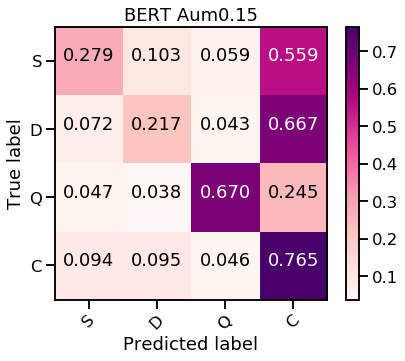

Test_ acc: 0.6856023506366308
Test_ f1 none: [0.224 0.178 0.645 0.802]
Test_ f1 macro: 0.46223156547976596
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.385 	F-macro_val: 0.186
Epoch 10 	acc_val: 0.698 	F-macro_val: 0.501
Epoch 20 	acc_val: 0.701 	F-macro_val: 0.513
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


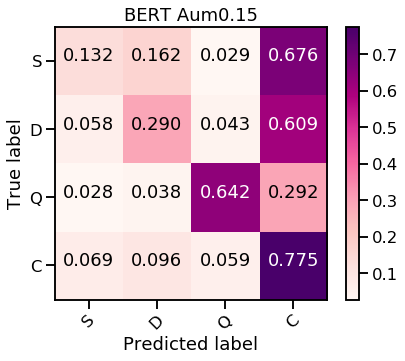

Test_ acc: 0.6856023506366308
Test_ f1 none: [0.13  0.223 0.604 0.804]
Test_ f1 macro: 0.4405857285509945
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.340 	F-macro_val: 0.279
Epoch 10 	acc_val: 0.712 	F-macro_val: 0.551
Epoch 20 	acc_val: 0.715 	F-macro_val: 0.557
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


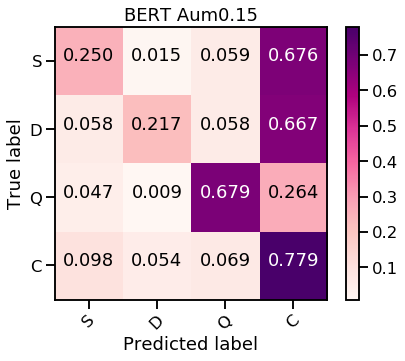

Test_ acc: 0.6953966699314398
Test_ f1 none: [0.2   0.234 0.6   0.806]
Test_ f1 macro: 0.4600565159574468
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 11
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.194 	F-macro_val: 0.177
Epoch 10 	acc_val: 0.688 	F-macro_val: 0.533
Epoch 20 	acc_val: 0.698 	F-macro_val: 0.538
Testing run # 11
SE TUVIERON QUE REPETIR 3 EJEMPLOS


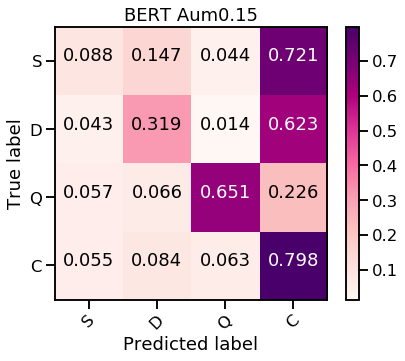

Test_ acc: 0.703232125367287
Test_ f1 none: [0.095 0.254 0.605 0.82 ]
Test_ f1 macro: 0.4436596233616147
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 12
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.253 	F-macro_val: 0.200
Epoch 10 	acc_val: 0.719 	F-macro_val: 0.564
Epoch 20 	acc_val: 0.708 	F-macro_val: 0.544
Testing run # 12
SE TUVIERON QUE REPETIR 3 EJEMPLOS


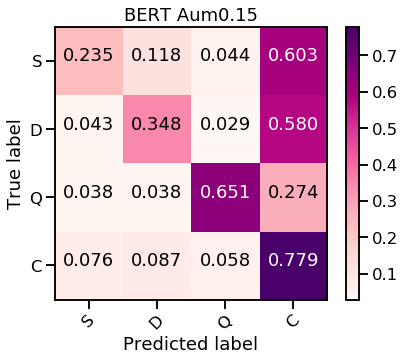

Test_ acc: 0.7002938295788442
Test_ f1 none: [0.213 0.277 0.613 0.811]
Test_ f1 macro: 0.47884207349629726


Ejemplo de tweet con label  commenting  y Tw_id  770035867381600260
Encoder Layer 1


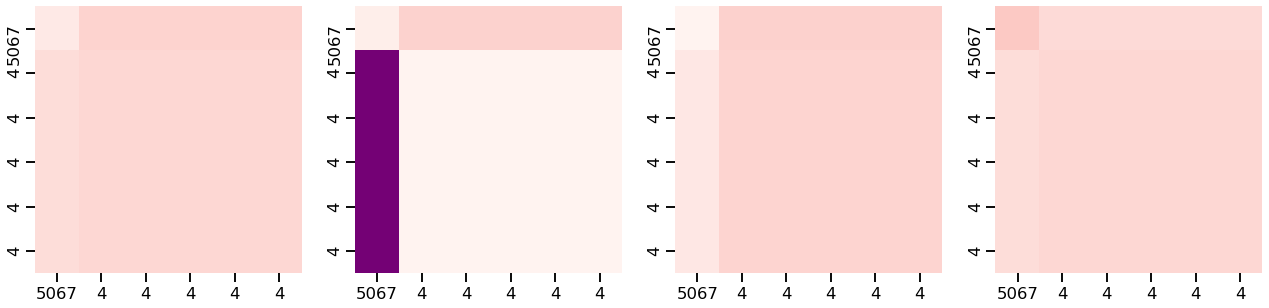

Encoder Layer 2


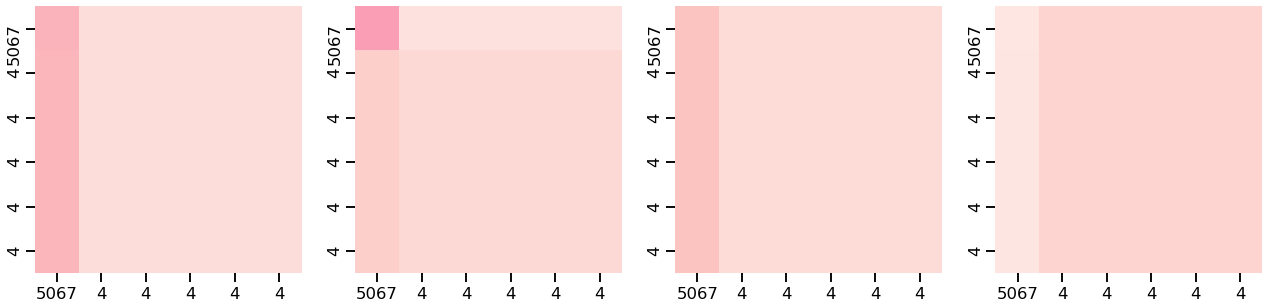



Ejemplo de tweet con label  support  y Tw_id  767744065681104896
Encoder Layer 1


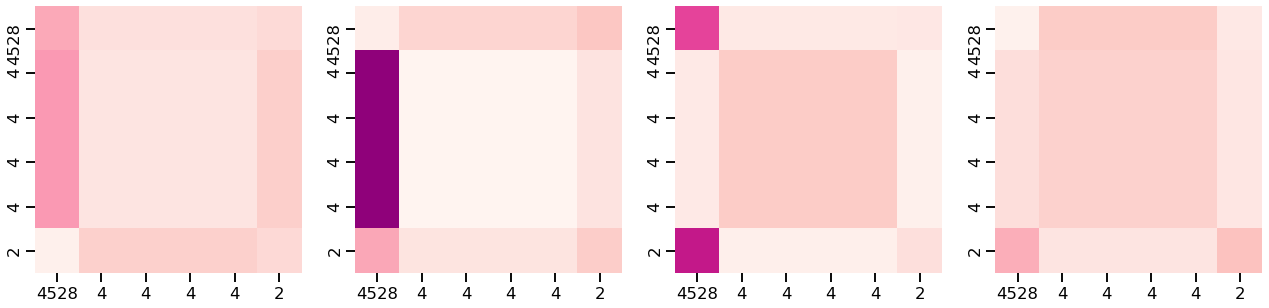

Encoder Layer 2


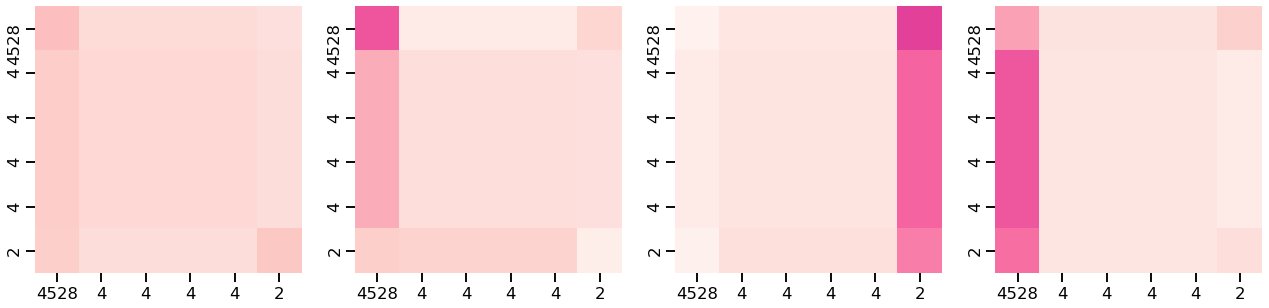



Ejemplo de tweet con label  denying  y Tw_id  758295910145204225
Encoder Layer 1


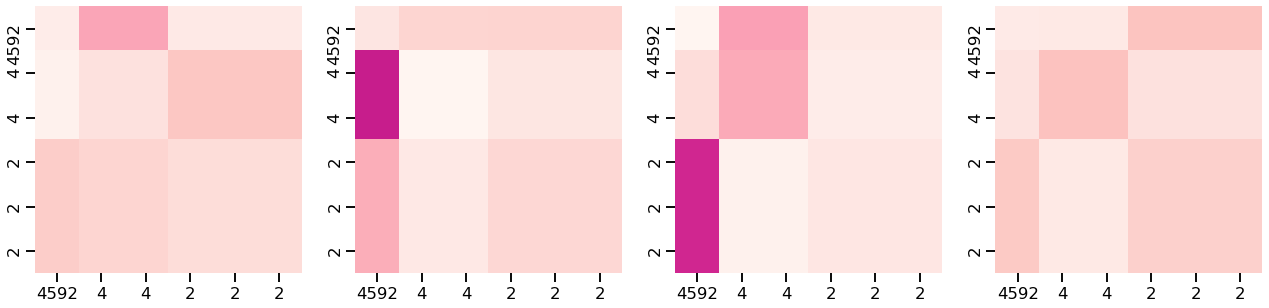

Encoder Layer 2


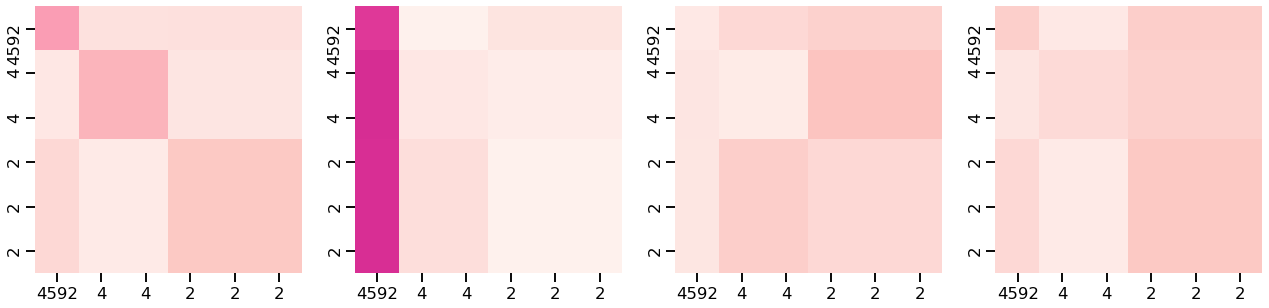



Ejemplo de tweet con label  questioning  y Tw_id  524945172321538048
Encoder Layer 1


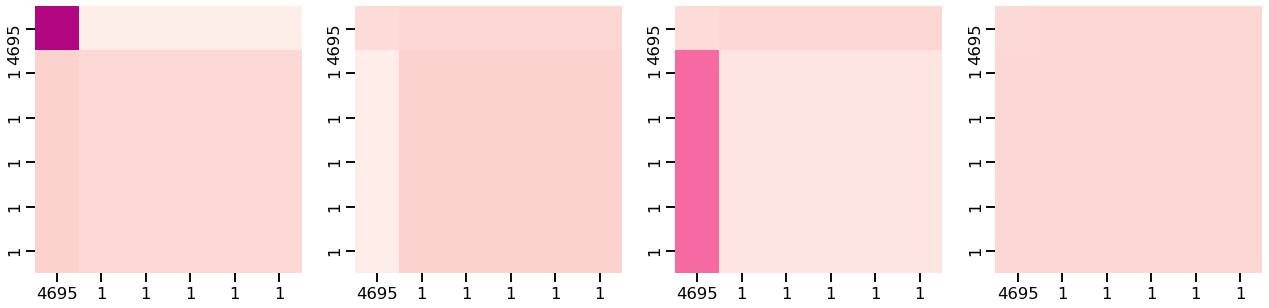

Encoder Layer 2


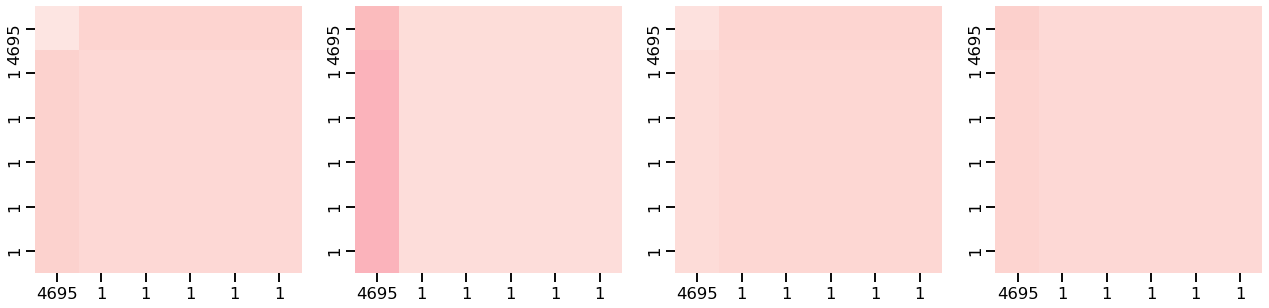

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 13
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.194 	F-macro_val: 0.211
Epoch 10 	acc_val: 0.684 	F-macro_val: 0.531
Epoch 20 	acc_val: 0.674 	F-macro_val: 0.508
Testing run # 13
SE TUVIERON QUE REPETIR 3 EJEMPLOS


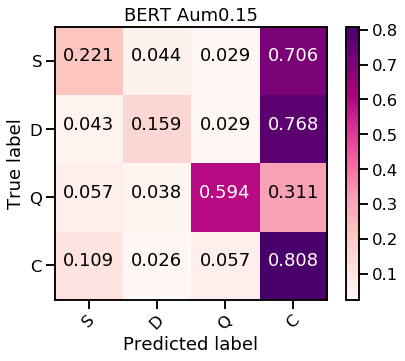

Test_ acc: 0.703232125367287
Test_ f1 none: [0.169 0.206 0.581 0.816]
Test_ f1 macro: 0.44302429521766395
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 14
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.528 	F-macro_val: 0.266
Epoch 10 	acc_val: 0.708 	F-macro_val: 0.529
Epoch 20 	acc_val: 0.712 	F-macro_val: 0.525
Testing run # 14
SE TUVIERON QUE REPETIR 3 EJEMPLOS


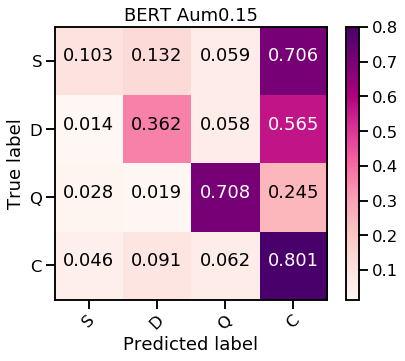

Test_ acc: 0.7149853085210578
Test_ f1 none: [0.122 0.284 0.633 0.823]
Test_ f1 macro: 0.46543172522179044
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 15
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.399 	F-macro_val: 0.268
Epoch 10 	acc_val: 0.712 	F-macro_val: 0.534
Epoch 20 	acc_val: 0.719 	F-macro_val: 0.538
Testing run # 15
SE TUVIERON QUE REPETIR 3 EJEMPLOS


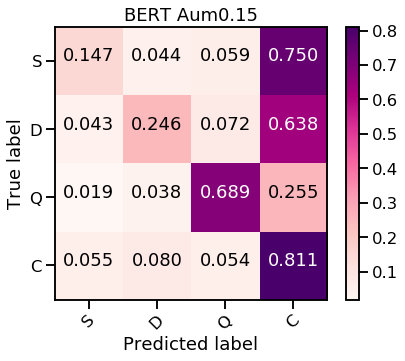

Test_ acc: 0.7159647404505387
Test_ f1 none: [0.159 0.219 0.635 0.824]
Test_ f1 macro: 0.4592913626703842
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 16
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.347 	F-macro_val: 0.202
Epoch 10 	acc_val: 0.646 	F-macro_val: 0.513
Epoch 20 	acc_val: 0.674 	F-macro_val: 0.530
Testing run # 16
SE TUVIERON QUE REPETIR 3 EJEMPLOS


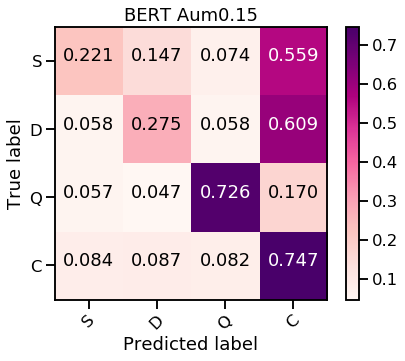

Test_ acc: 0.6777668952007836
Test_ f1 none: [0.19  0.222 0.602 0.798]
Test_ f1 macro: 0.45279682736754134
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 17
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.184 	F-macro_val: 0.125
Epoch 10 	acc_val: 0.719 	F-macro_val: 0.571
Epoch 20 	acc_val: 0.722 	F-macro_val: 0.565
Testing run # 17
SE TUVIERON QUE REPETIR 3 EJEMPLOS


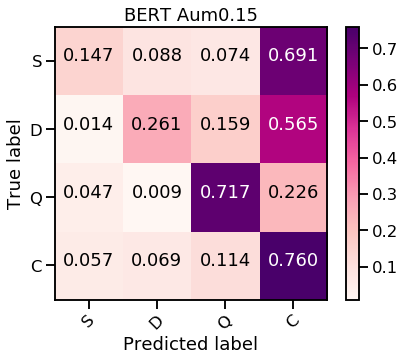

Test_ acc: 0.6807051909892262
Test_ f1 none: [0.156 0.243 0.53  0.799]
Test_ f1 macro: 0.4320746522388875
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 18
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.399 	F-macro_val: 0.256
Epoch 10 	acc_val: 0.705 	F-macro_val: 0.569
Epoch 20 	acc_val: 0.691 	F-macro_val: 0.547
Testing run # 18
SE TUVIERON QUE REPETIR 3 EJEMPLOS


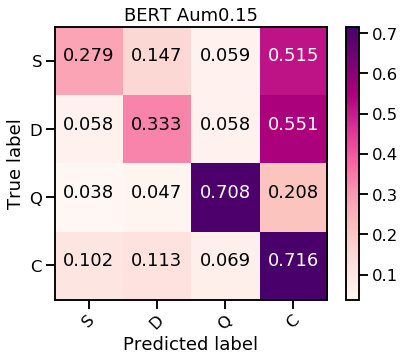

Test_ acc: 0.6601371204701273
Test_ f1 none: [0.218 0.236 0.617 0.779]
Test_ f1 macro: 0.46264829253335
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 19
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.108 	F-macro_val: 0.104
Epoch 10 	acc_val: 0.681 	F-macro_val: 0.497
Epoch 20 	acc_val: 0.694 	F-macro_val: 0.509
Testing run # 19
SE TUVIERON QUE REPETIR 3 EJEMPLOS


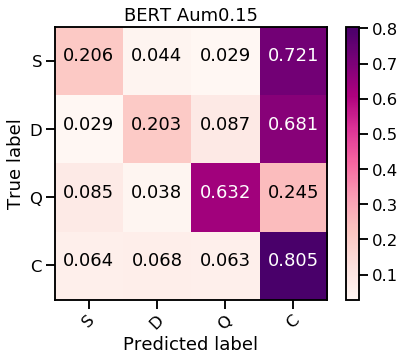

Test_ acc: 0.7061704211557297
Test_ f1 none: [0.196 0.196 0.583 0.82 ]
Test_ f1 macro: 0.4486656741742502
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 20
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.236 	F-macro_val: 0.124
Epoch 10 	acc_val: 0.667 	F-macro_val: 0.508
Epoch 20 	acc_val: 0.698 	F-macro_val: 0.519
Testing run # 20
SE TUVIERON QUE REPETIR 3 EJEMPLOS


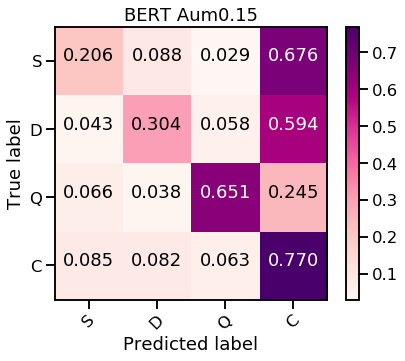

Test_ acc: 0.6885406464250735
Test_ f1 none: [0.177 0.256 0.6   0.804]
Test_ f1 macro: 0.4593348991216528


In [18]:
best_15, all_accs, all_fno, all_ma, all_cm =train_transformer(0.15, 30, path_a, path_m, "RdPu")

In [19]:
best_15  # array([0.2745098 , 0.21621622, 0.64435146, 0.79863481]

{'F_ma': 0.47884207349629726, 'Run': 12}

In [20]:
all_ma

[0.4296493648313039,
 0.45768565483360446,
 0.4630467132342627,
 0.46246151015875786,
 0.44886960120177744,
 0.4520321605596146,
 0.4695711253127521,
 0.46223156547976596,
 0.4405857285509945,
 0.4600565159574468,
 0.4436596233616147,
 0.47884207349629726,
 0.44302429521766395,
 0.46543172522179044,
 0.4592913626703842,
 0.45279682736754134,
 0.4320746522388875,
 0.46264829253335,
 0.4486656741742502,
 0.4593348991216528]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdc2ba24d30>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdc2ba2a320>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdc2ba24b00>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdc2ba2aa58>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdc2ba2ae10>],
 'means': []}

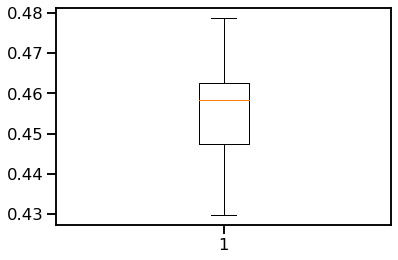

In [24]:
plt.boxplot([0.4296493648313039,
 0.45768565483360446,
 0.4630467132342627,
 0.46246151015875786,
 0.44886960120177744,
 0.4520321605596146,
 0.4695711253127521,
 0.46223156547976596,
 0.4405857285509945,
 0.4600565159574468,
 0.4436596233616147,
 0.47884207349629726,
 0.44302429521766395,
 0.46543172522179044,
 0.4592913626703842,
 0.45279682736754134,
 0.4320746522388875,
 0.46264829253335,
 0.4486656741742502,
 0.4593348991216528])

In [21]:
all_fno

[array([0.126, 0.187, 0.598, 0.807]),
 array([0.235, 0.236, 0.596, 0.763]),
 array([0.22 , 0.267, 0.61 , 0.755]),
 array([0.128, 0.268, 0.628, 0.826]),
 array([0.133, 0.232, 0.636, 0.794]),
 array([0.177, 0.225, 0.597, 0.81 ]),
 array([0.222, 0.253, 0.607, 0.796]),
 array([0.224, 0.178, 0.645, 0.802]),
 array([0.13 , 0.223, 0.604, 0.804]),
 array([0.2  , 0.234, 0.6  , 0.806]),
 array([0.095, 0.254, 0.605, 0.82 ]),
 array([0.213, 0.277, 0.613, 0.811]),
 array([0.169, 0.206, 0.581, 0.816]),
 array([0.122, 0.284, 0.633, 0.823]),
 array([0.159, 0.219, 0.635, 0.824]),
 array([0.19 , 0.222, 0.602, 0.798]),
 array([0.156, 0.243, 0.53 , 0.799]),
 array([0.218, 0.236, 0.617, 0.779]),
 array([0.196, 0.196, 0.583, 0.82 ]),
 array([0.177, 0.256, 0.6  , 0.804])]

In [22]:
all_accs

[0.692458374142997,
 0.6415279138099902,
 0.6327130264446621,
 0.7198824681684622,
 0.6767874632713027,
 0.693437806072478,
 0.6797257590597453,
 0.6856023506366308,
 0.6856023506366308,
 0.6953966699314398,
 0.703232125367287,
 0.7002938295788442,
 0.703232125367287,
 0.7149853085210578,
 0.7159647404505387,
 0.6777668952007836,
 0.6807051909892262,
 0.6601371204701273,
 0.7061704211557297,
 0.6885406464250735]

Acc: 0.688 -- deviation: 0.022
F-score: 0.455 -- deviation: 0.012
(0.15) SDQC: 0.1745316167644147 0.23485636328798093 0.6060720498689466 0.8029318431834003


Confusion counts
[[  270.   140.    71.   879.]
 [   65.   395.    80.   840.]
 [  101.    79.  1442.   498.]
 [ 1225.  1347.  1052. 11936.]]


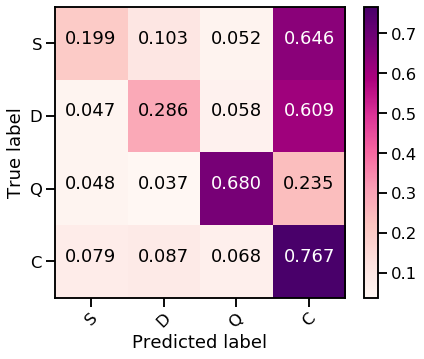

In [23]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs)), "-- deviation: %.3f" % np.std(np.asarray(all_accs)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma)), "-- deviation: %.3f" % np.std(np.asarray(all_ma)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno)[:,0])
den=np.mean(np.asarray(all_fno)[:,1])
que=np.mean(np.asarray(all_fno)[:,2])
com=np.mean(np.asarray(all_fno)[:,3])

print ("(0.15) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S","D","Q","C"], "", cmap='RdPu')

## 0.5 mask

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.278 	F-macro_val: 0.211
Epoch 10 	acc_val: 0.656 	F-macro_val: 0.493
Epoch 20 	acc_val: 0.660 	F-macro_val: 0.499
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


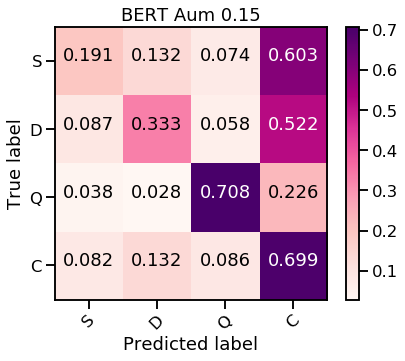

Test_ acc: 0.6415279138099902
Test_ f1 none: [0.168 0.222 0.584 0.765]
Test_ f1 macro: 0.4345509036362408


Ejemplo de tweet con label  commenting  y Tw_id  544280844060213248
Encoder Layer 1


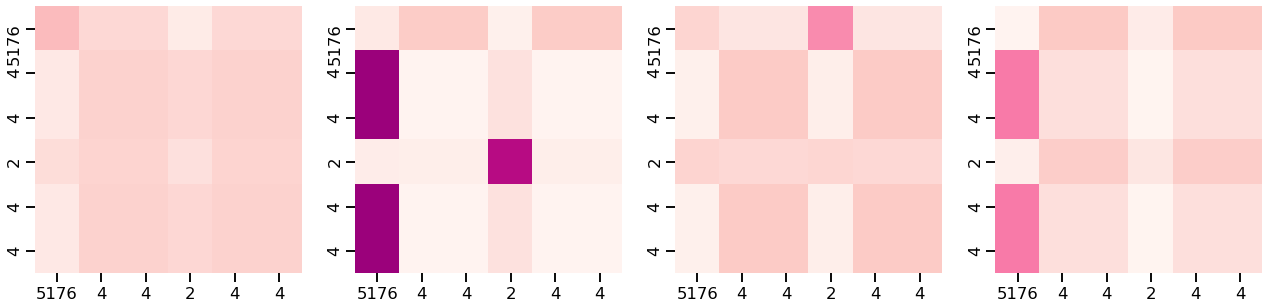

Encoder Layer 2


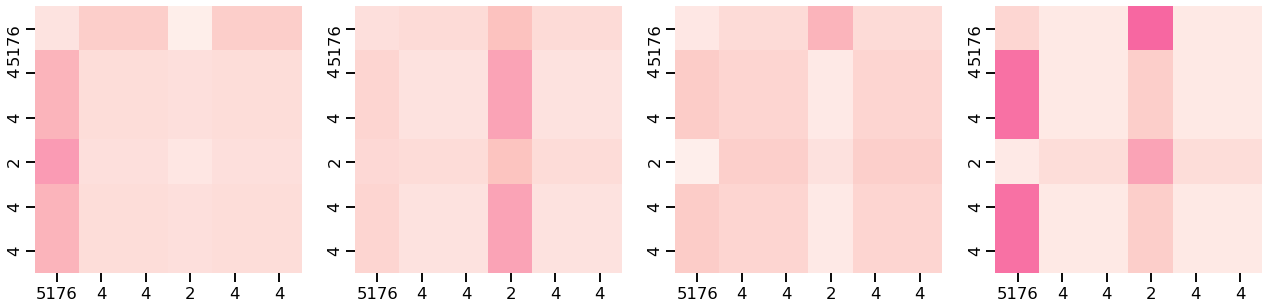



Ejemplo de tweet con label  support  y Tw_id  768863602065416192
Encoder Layer 1


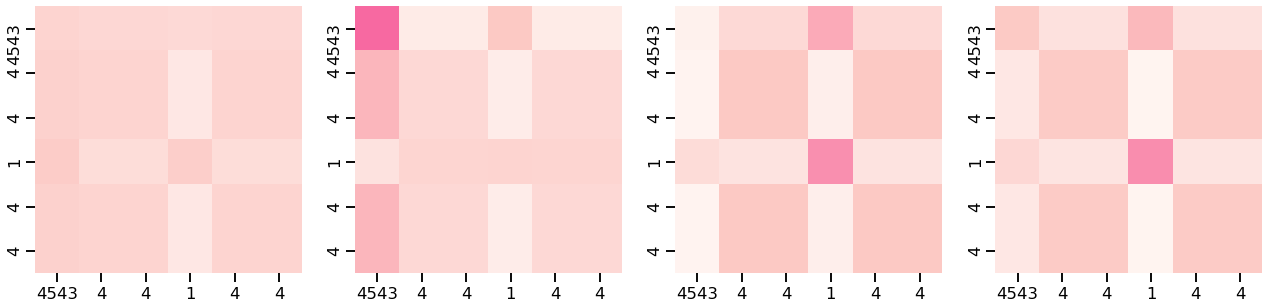

Encoder Layer 2


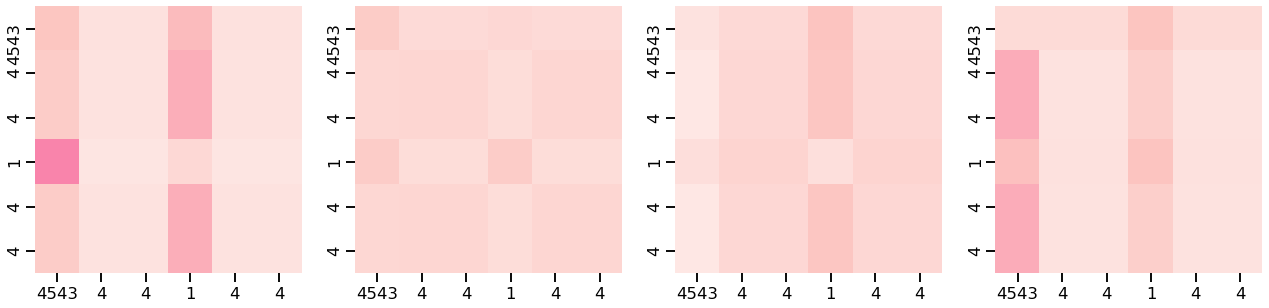



Ejemplo de tweet con label  denying  y Tw_id  758335648541671424
Encoder Layer 1


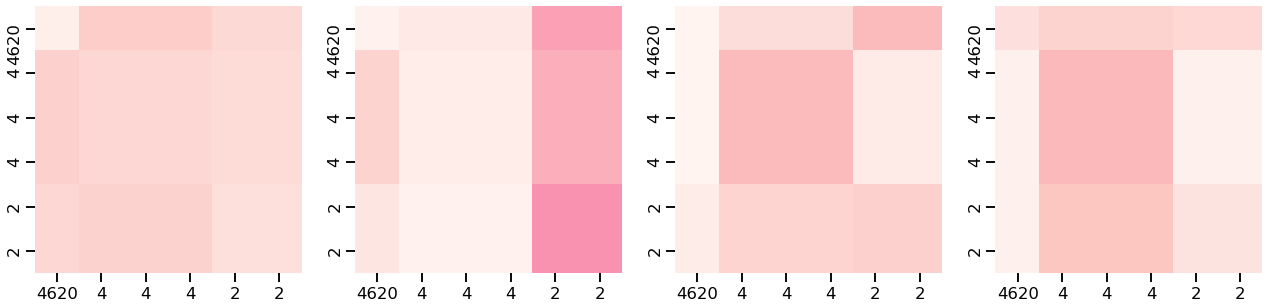

Encoder Layer 2


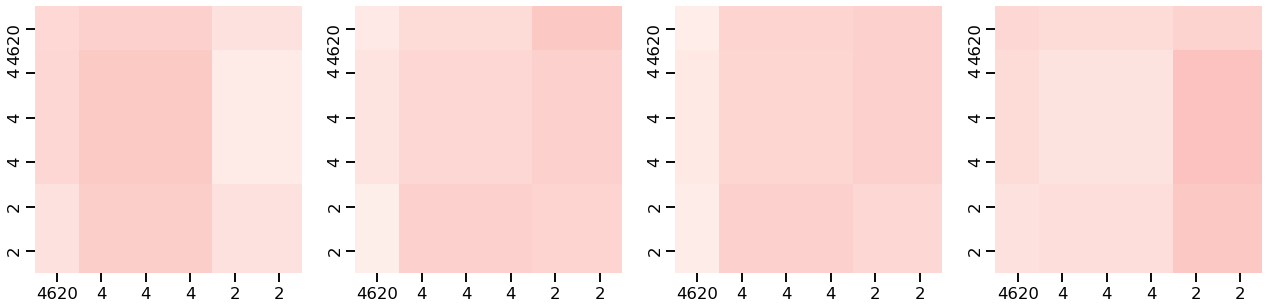



Ejemplo de tweet con label  questioning  y Tw_id  544280004860059648
Encoder Layer 1


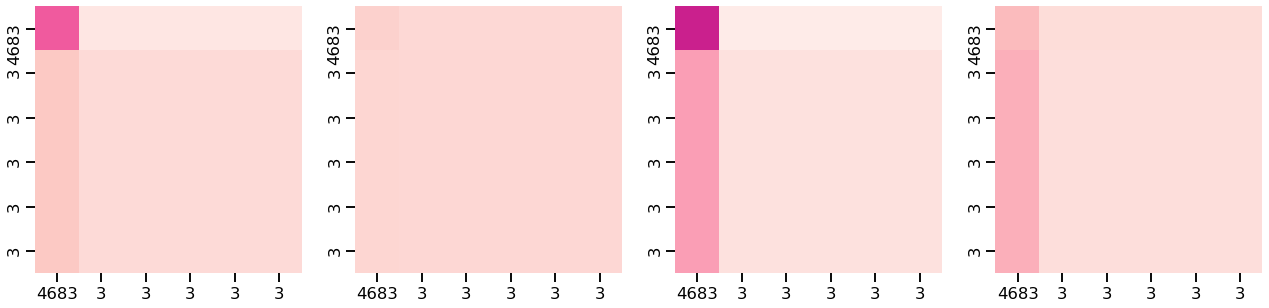

Encoder Layer 2


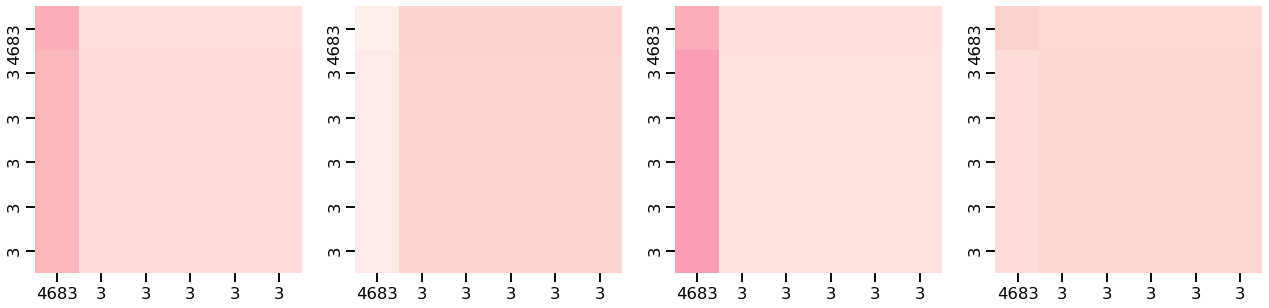

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.309 	F-macro_val: 0.177
Epoch 10 	acc_val: 0.681 	F-macro_val: 0.488
Epoch 20 	acc_val: 0.688 	F-macro_val: 0.498
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


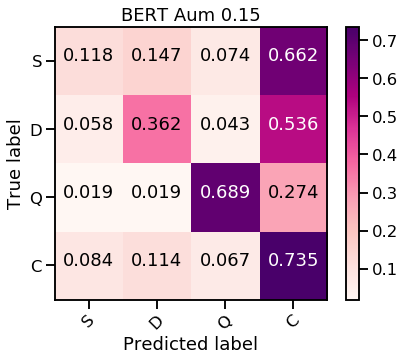

Test_ acc: 0.6640548481880509
Test_ f1 none: [0.109 0.256 0.611 0.783]
Test_ f1 macro: 0.4397894450082174


Ejemplo de tweet con label  commenting  y Tw_id  544365801503879169
Encoder Layer 1


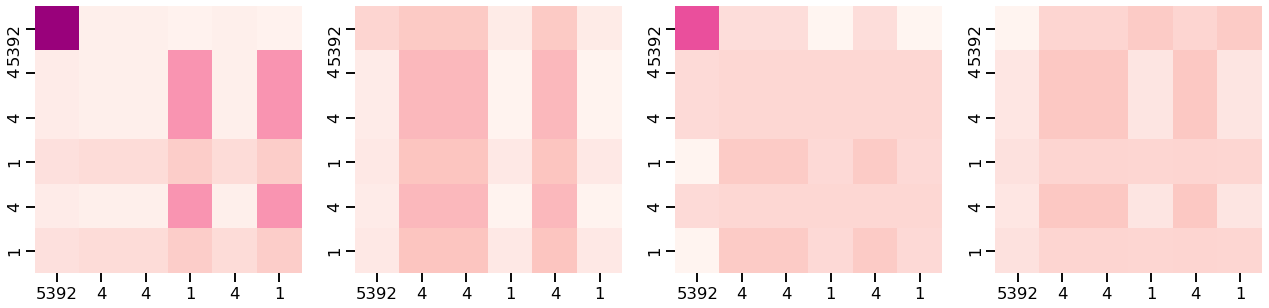

Encoder Layer 2


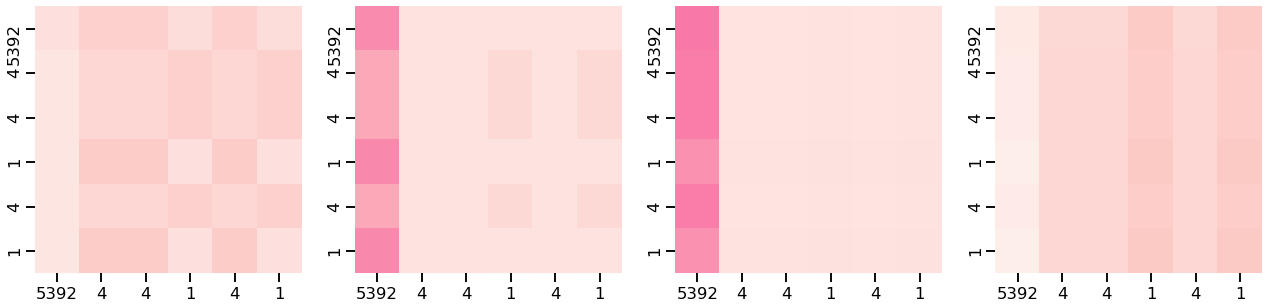



Ejemplo de tweet con label  support  y Tw_id  769993008896995328
Encoder Layer 1


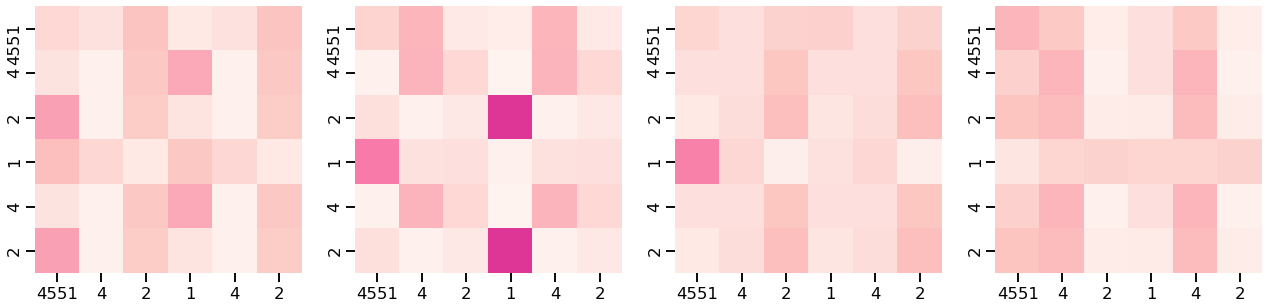

Encoder Layer 2


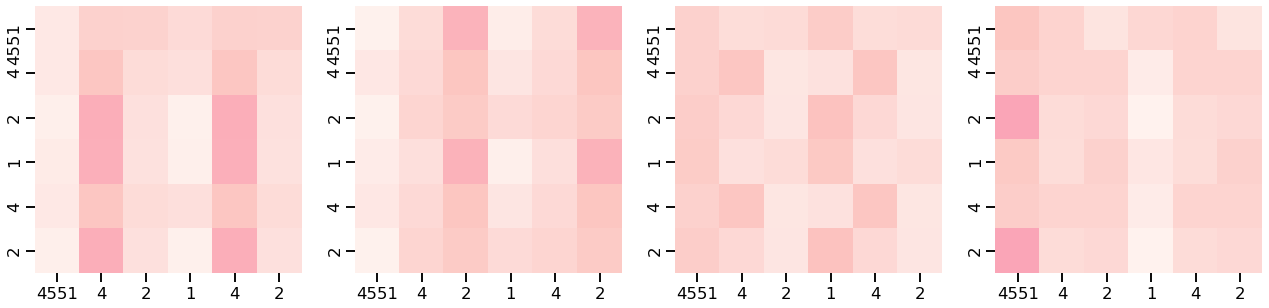



Ejemplo de tweet con label  denying  y Tw_id  498546719244578817
Encoder Layer 1


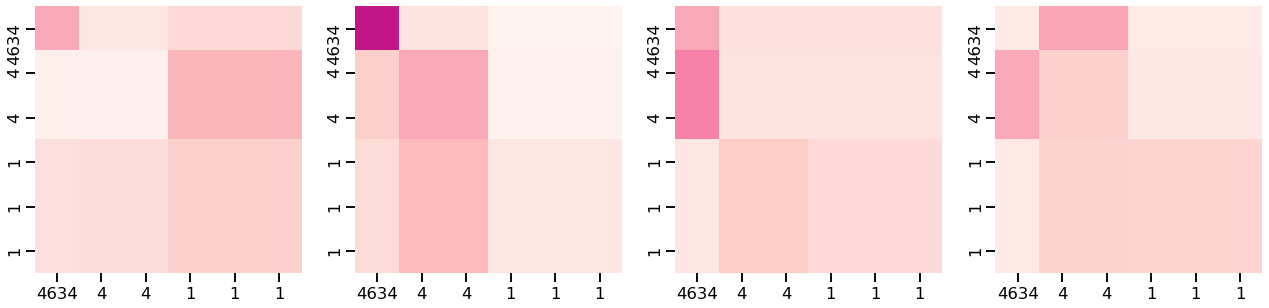

Encoder Layer 2


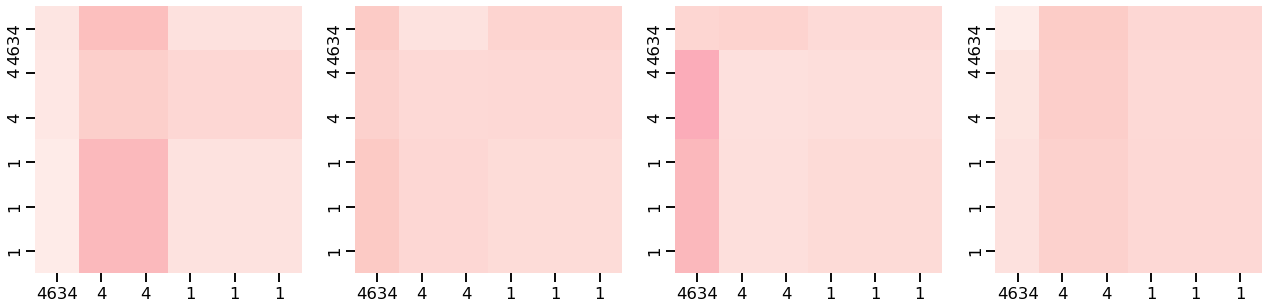



Ejemplo de tweet con label  questioning  y Tw_id  581297818528141313
Encoder Layer 1


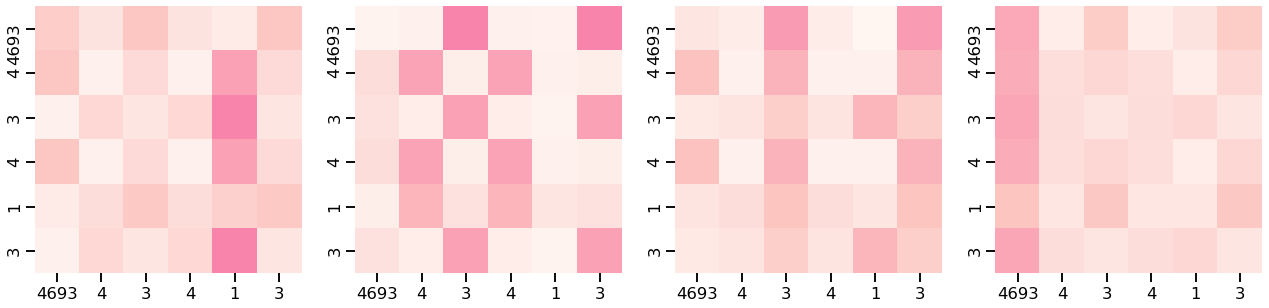

Encoder Layer 2


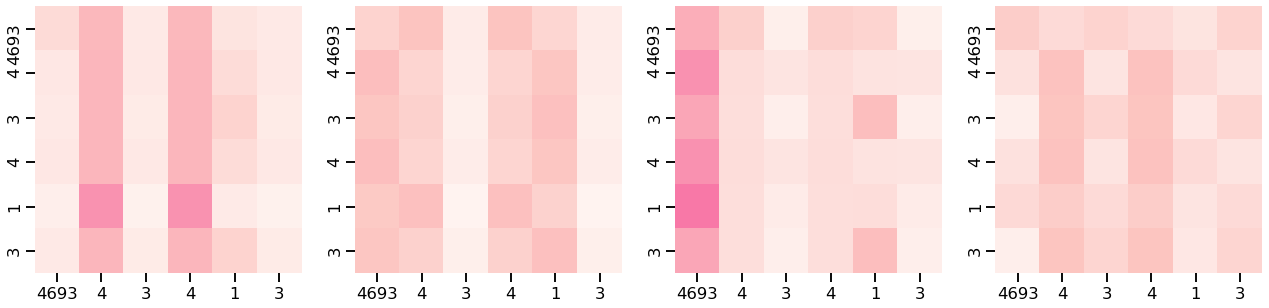

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.208 	F-macro_val: 0.184
Epoch 10 	acc_val: 0.670 	F-macro_val: 0.530
Epoch 20 	acc_val: 0.649 	F-macro_val: 0.510
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


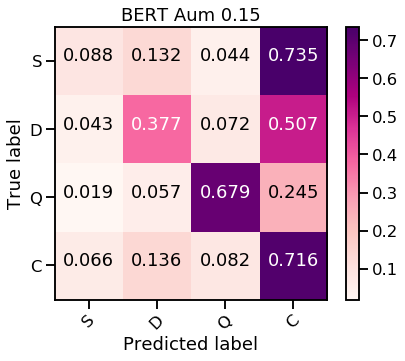

Test_ acc: 0.6474045053868757
Test_ f1 none: [0.092 0.241 0.576 0.77 ]
Test_ f1 macro: 0.4198623848872812
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.156 	F-macro_val: 0.111
Epoch 10 	acc_val: 0.632 	F-macro_val: 0.484
Epoch 20 	acc_val: 0.653 	F-macro_val: 0.498
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


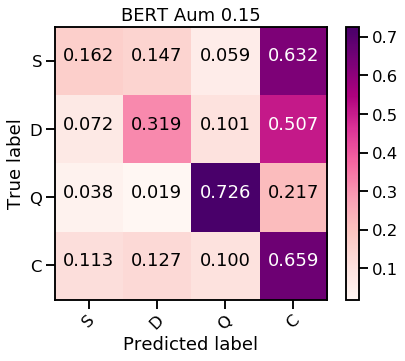

Test_ acc: 0.6101860920666013
Test_ f1 none: [0.125 0.218 0.566 0.737]
Test_ f1 macro: 0.41151680457092366
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.267 	F-macro_val: 0.186
Epoch 10 	acc_val: 0.667 	F-macro_val: 0.534
Epoch 20 	acc_val: 0.670 	F-macro_val: 0.544
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


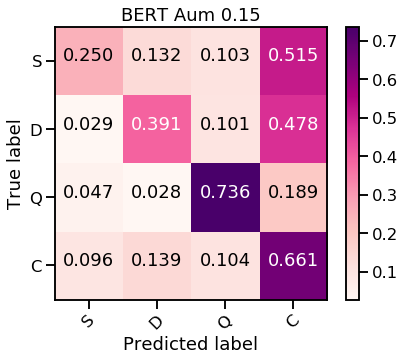

Test_ acc: 0.6229187071498531
Test_ f1 none: [0.204 0.25  0.559 0.745]
Test_ f1 macro: 0.4394150338873445
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.194 	F-macro_val: 0.152
Epoch 10 	acc_val: 0.635 	F-macro_val: 0.520
Epoch 20 	acc_val: 0.632 	F-macro_val: 0.509
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


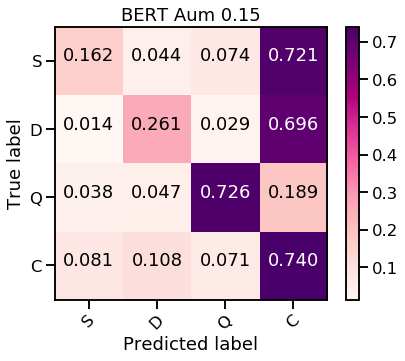

Test_ acc: 0.6679725759059746
Test_ f1 none: [0.15  0.201 0.629 0.783]
Test_ f1 macro: 0.4406223328877483


Ejemplo de tweet con label  commenting  y Tw_id  767741947763167232
Encoder Layer 1


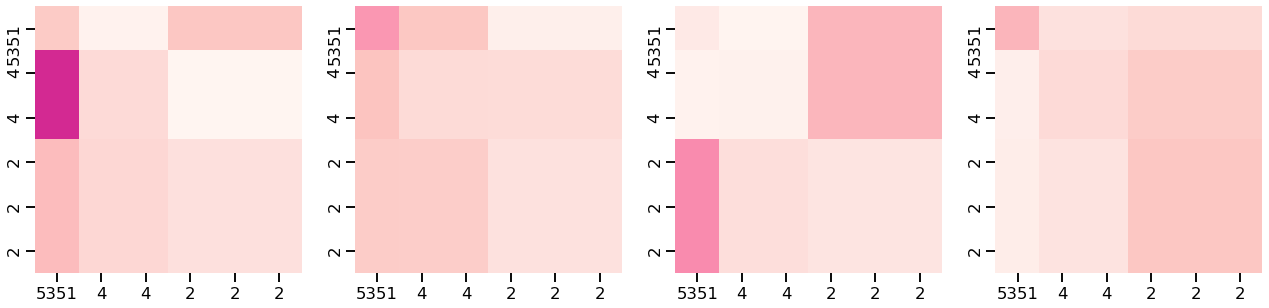

Encoder Layer 2


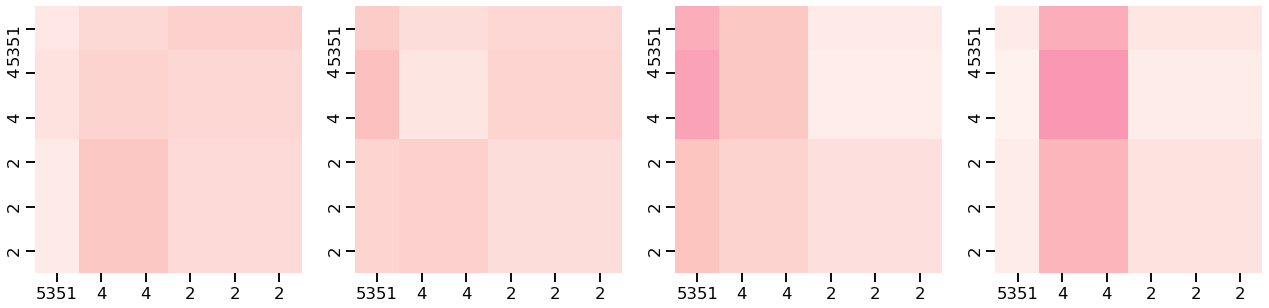



Ejemplo de tweet con label  support  y Tw_id  775075528554389504
Encoder Layer 1


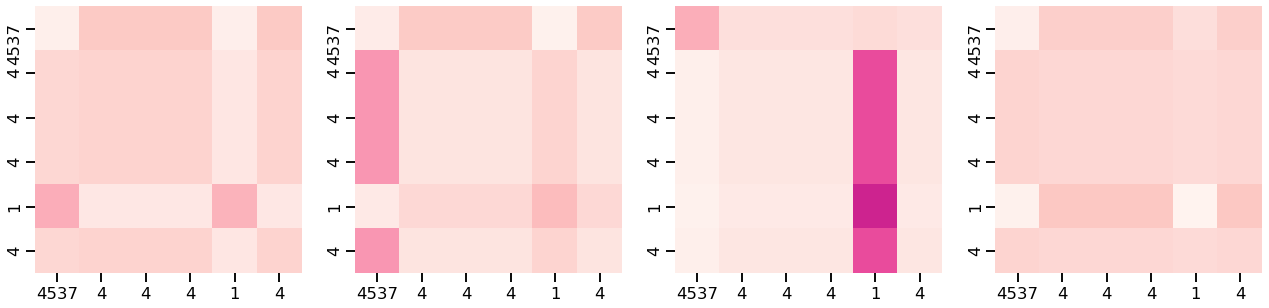

Encoder Layer 2


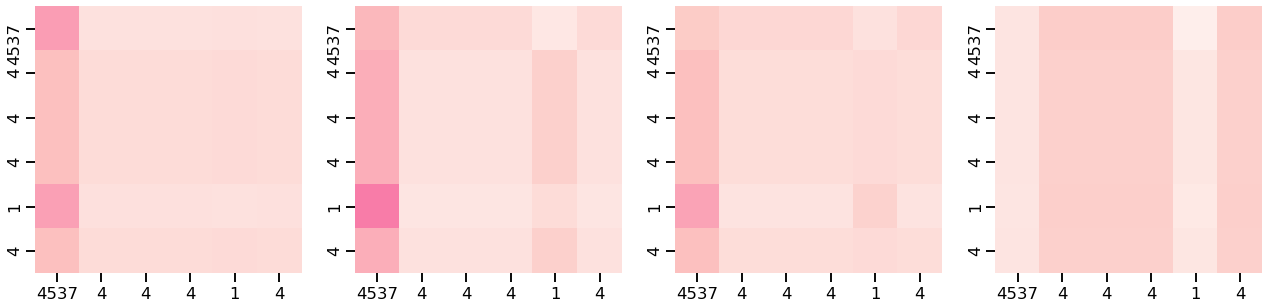



Ejemplo de tweet con label  denying  y Tw_id  765612220860370944
Encoder Layer 1


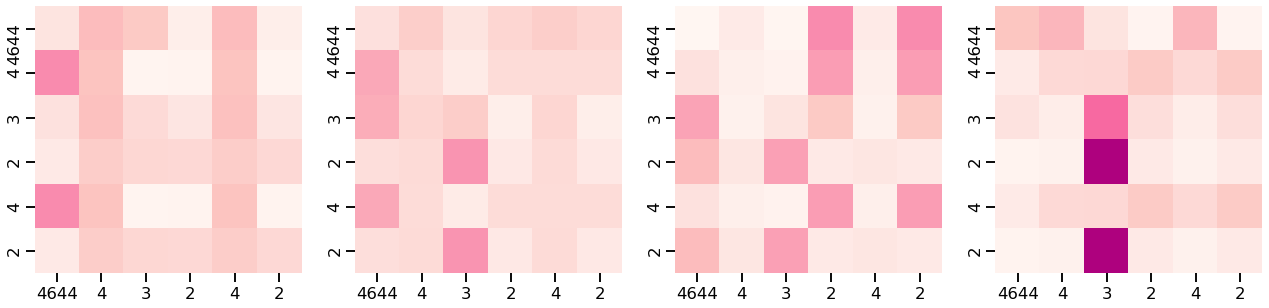

Encoder Layer 2


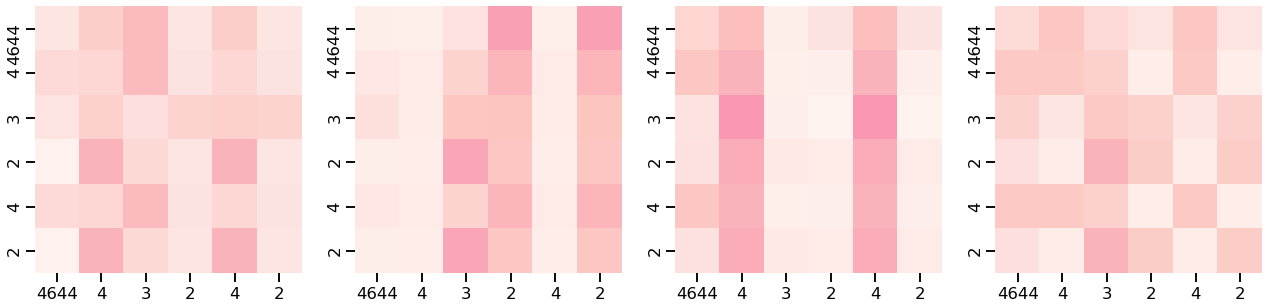



Ejemplo de tweet con label  questioning  y Tw_id  553561561139535872
Encoder Layer 1


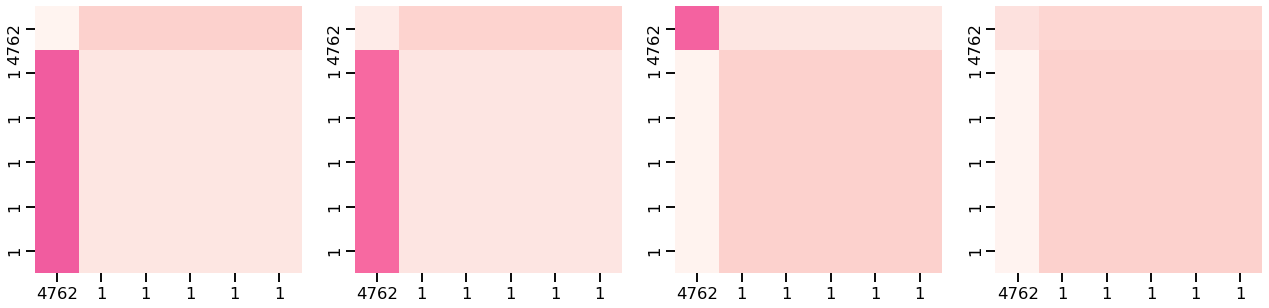

Encoder Layer 2


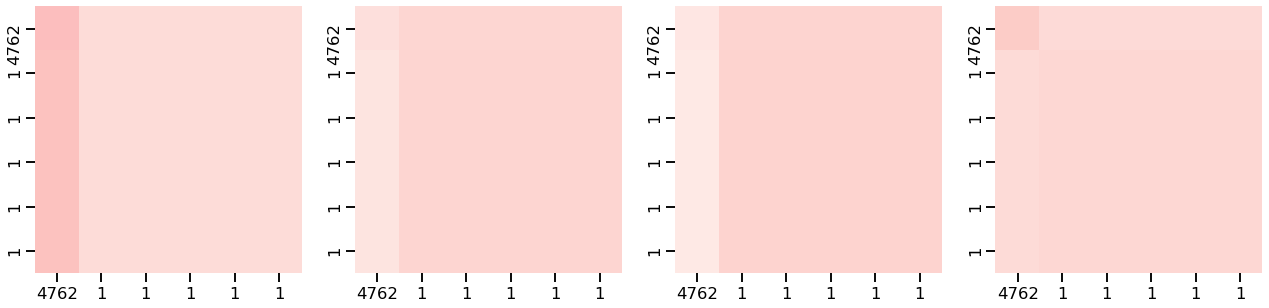

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.087 	F-macro_val: 0.078
Epoch 10 	acc_val: 0.653 	F-macro_val: 0.490
Epoch 20 	acc_val: 0.681 	F-macro_val: 0.504
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


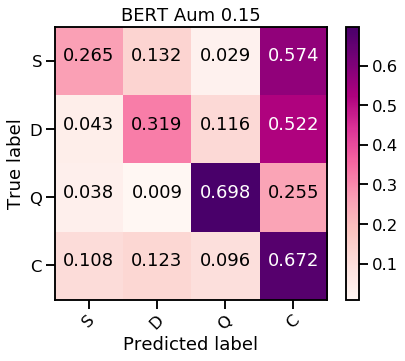

Test_ acc: 0.623898139079334
Test_ f1 none: [0.203 0.223 0.558 0.746]
Test_ f1 macro: 0.4326939776275309
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.208 	F-macro_val: 0.134
Epoch 10 	acc_val: 0.674 	F-macro_val: 0.523
Epoch 20 	acc_val: 0.667 	F-macro_val: 0.514
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


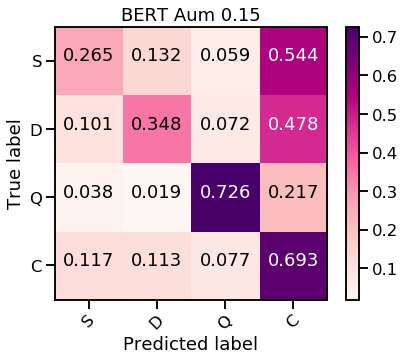

Test_ acc: 0.6444662095984329
Test_ f1 none: [0.191 0.25  0.611 0.765]
Test_ f1 macro: 0.4542848699763593


Ejemplo de tweet con label  commenting  y Tw_id  758424568260333570
Encoder Layer 1


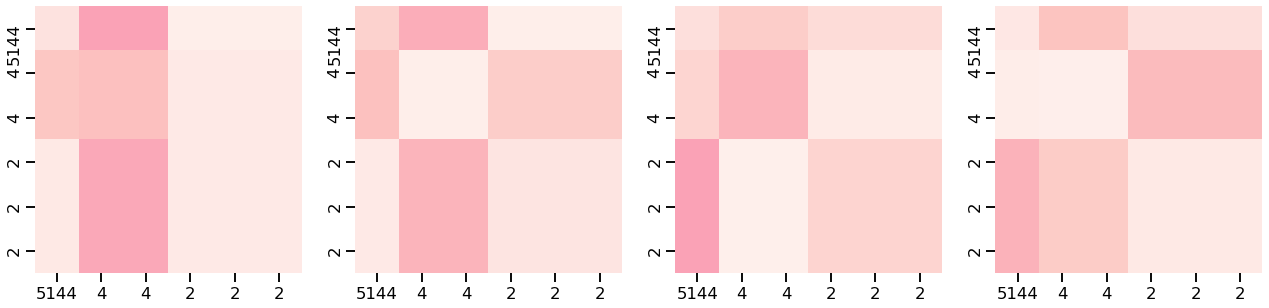

Encoder Layer 2


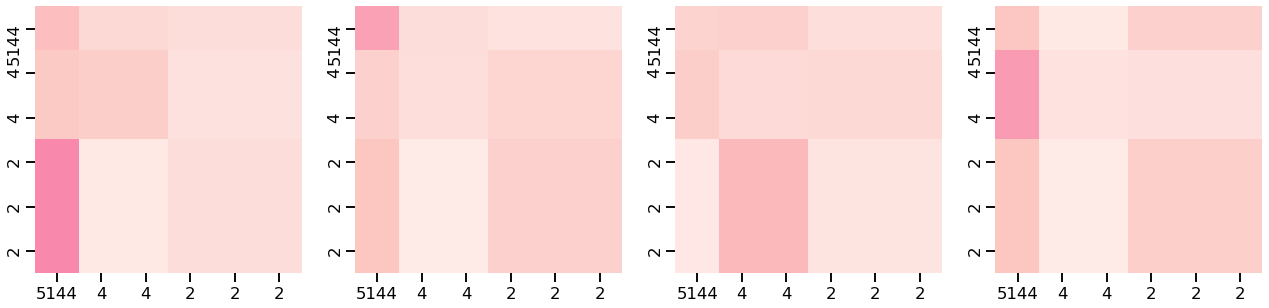



Ejemplo de tweet con label  support  y Tw_id  553574606259625984
Encoder Layer 1


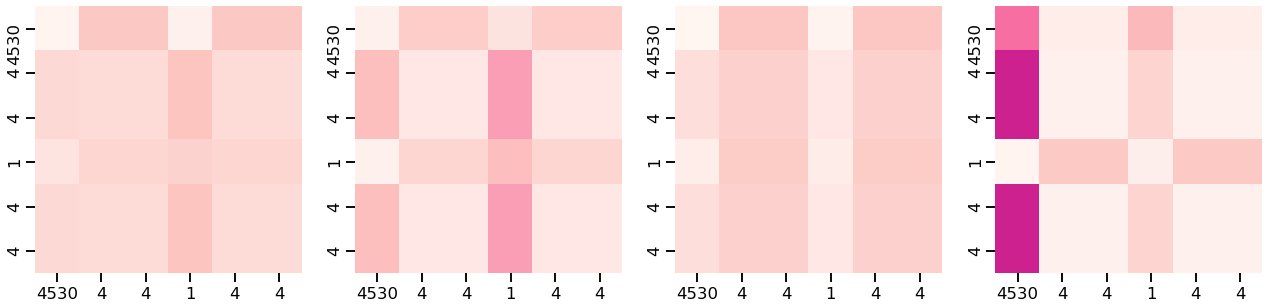

Encoder Layer 2


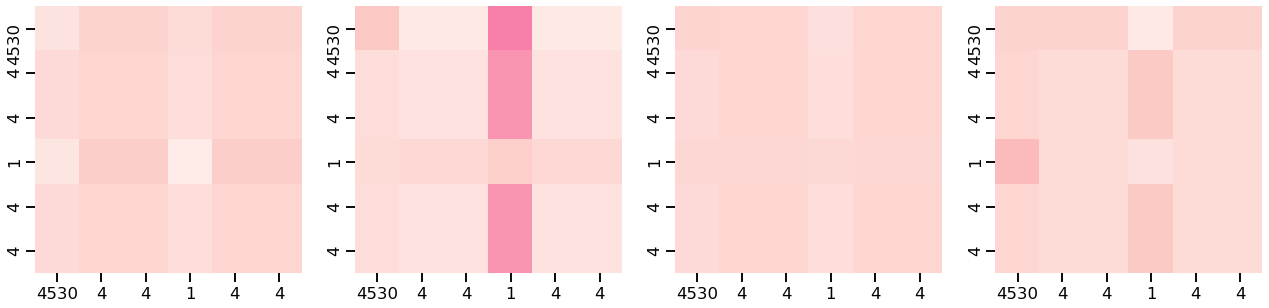



Ejemplo de tweet con label  denying  y Tw_id  767745760570044416
Encoder Layer 1


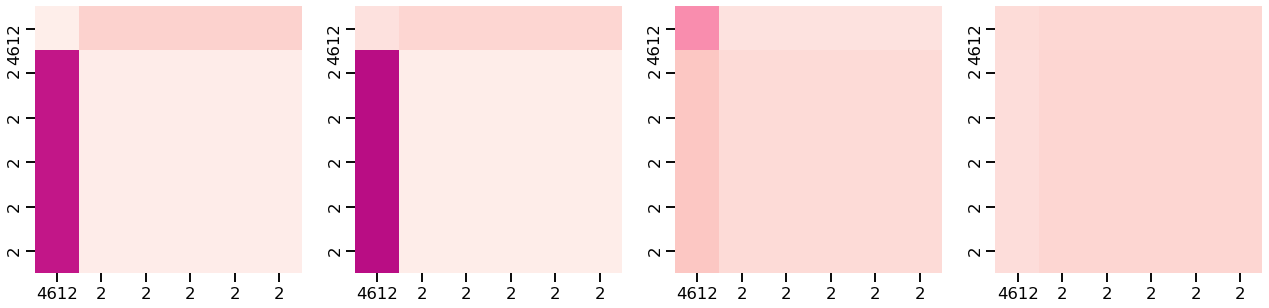

Encoder Layer 2


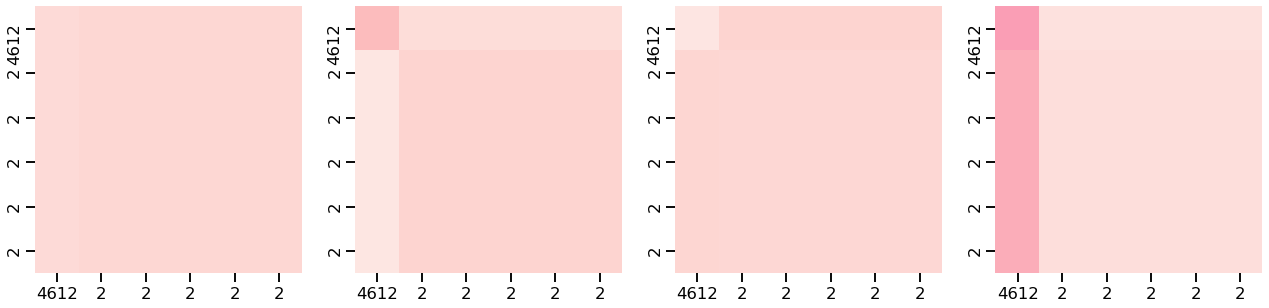



Ejemplo de tweet con label  questioning  y Tw_id  758346105415344128
Encoder Layer 1


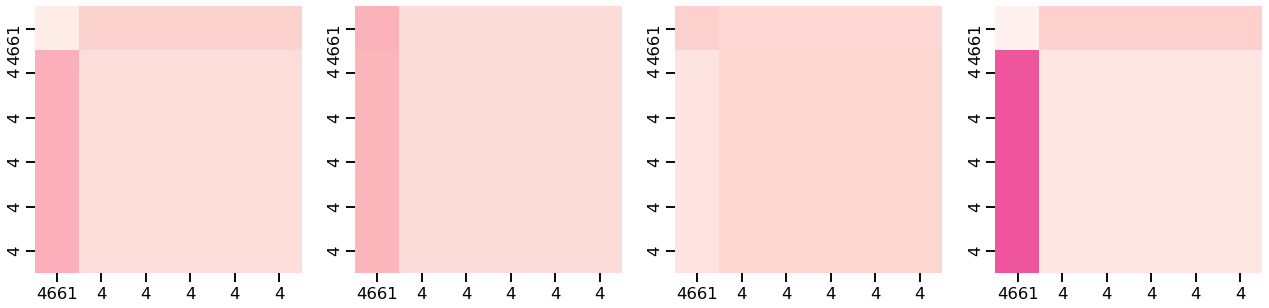

Encoder Layer 2


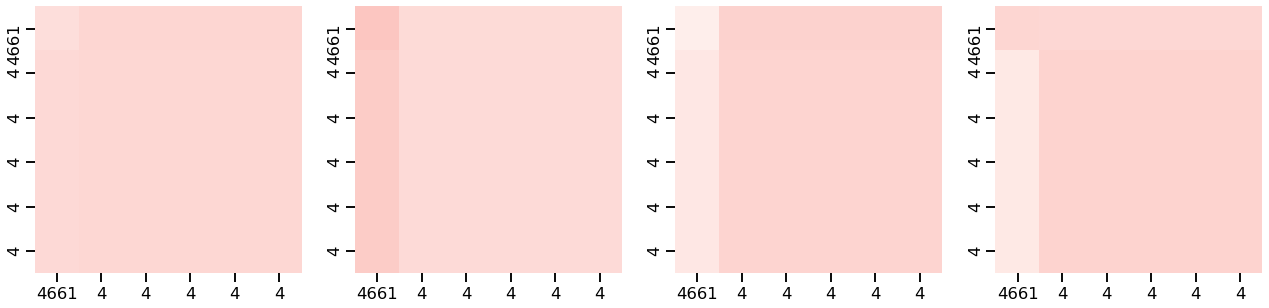

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.250 	F-macro_val: 0.230
Epoch 10 	acc_val: 0.642 	F-macro_val: 0.482
Epoch 20 	acc_val: 0.660 	F-macro_val: 0.502
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


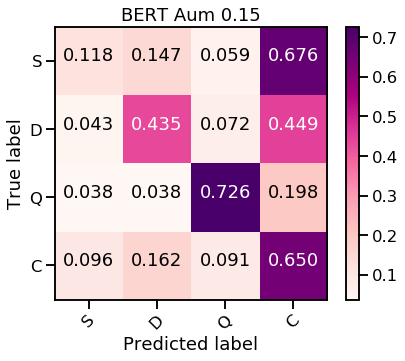

Test_ acc: 0.6082272282076395
Test_ f1 none: [0.101 0.251 0.586 0.732]
Test_ f1 macro: 0.41753381203810896
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.385 	F-macro_val: 0.318
Epoch 10 	acc_val: 0.670 	F-macro_val: 0.483
Epoch 20 	acc_val: 0.681 	F-macro_val: 0.490
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


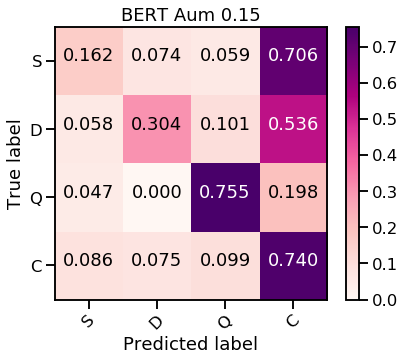

Test_ acc: 0.67384916748286
Test_ f1 none: [0.142 0.275 0.584 0.789]
Test_ f1 macro: 0.4473569973805909
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 11
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.181 	F-macro_val: 0.119
Epoch 10 	acc_val: 0.660 	F-macro_val: 0.479
Epoch 20 	acc_val: 0.660 	F-macro_val: 0.518
Testing run # 11
SE TUVIERON QUE REPETIR 3 EJEMPLOS


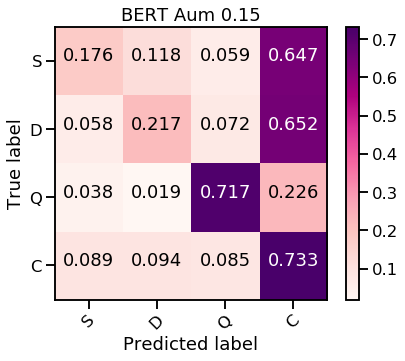

Test_ acc: 0.6591576885406464
Test_ f1 none: [0.153 0.18  0.591 0.78 ]
Test_ f1 macro: 0.4260585309124232
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 12
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.292 	F-macro_val: 0.200
Epoch 10 	acc_val: 0.660 	F-macro_val: 0.521
Epoch 20 	acc_val: 0.708 	F-macro_val: 0.561
Testing run # 12
SE TUVIERON QUE REPETIR 3 EJEMPLOS


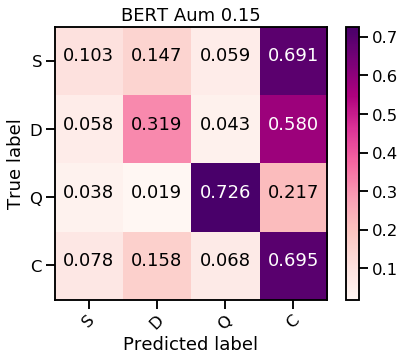

Test_ acc: 0.633692458374143
Test_ f1 none: [0.097 0.195 0.634 0.757]
Test_ f1 macro: 0.42070754795539567
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 13
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.292 	F-macro_val: 0.181
Epoch 10 	acc_val: 0.677 	F-macro_val: 0.486
Epoch 20 	acc_val: 0.656 	F-macro_val: 0.490
Testing run # 13
SE TUVIERON QUE REPETIR 3 EJEMPLOS


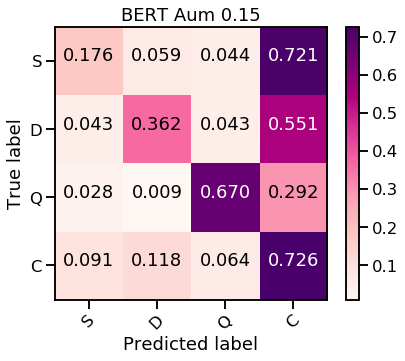

Test_ acc: 0.6591576885406464
Test_ f1 none: [0.153 0.262 0.609 0.773]
Test_ f1 macro: 0.44938281355022847
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 14
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.222 	F-macro_val: 0.169
Epoch 10 	acc_val: 0.642 	F-macro_val: 0.473
Epoch 20 	acc_val: 0.660 	F-macro_val: 0.478
Testing run # 14
SE TUVIERON QUE REPETIR 3 EJEMPLOS


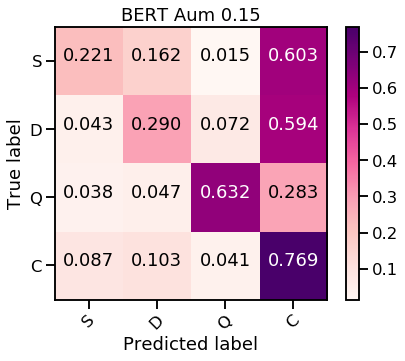

Test_ acc: 0.6856023506366308
Test_ f1 none: [0.19  0.216 0.635 0.804]
Test_ f1 macro: 0.46123104121133596


Ejemplo de tweet con label  commenting  y Tw_id  524962170166317056
Encoder Layer 1


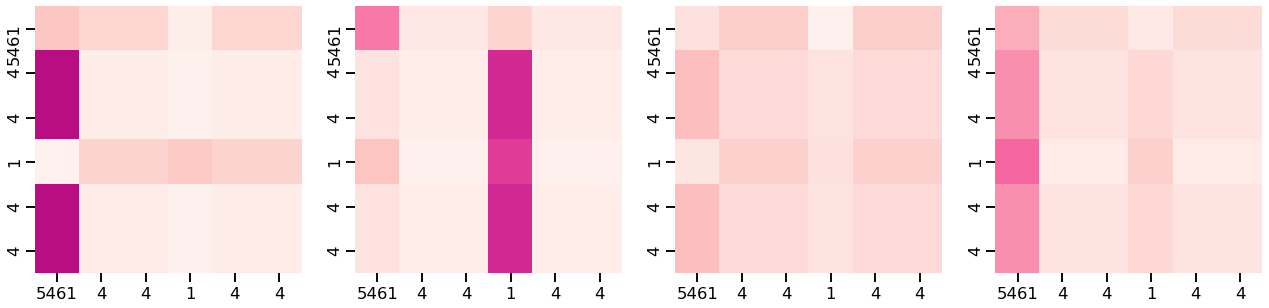

Encoder Layer 2


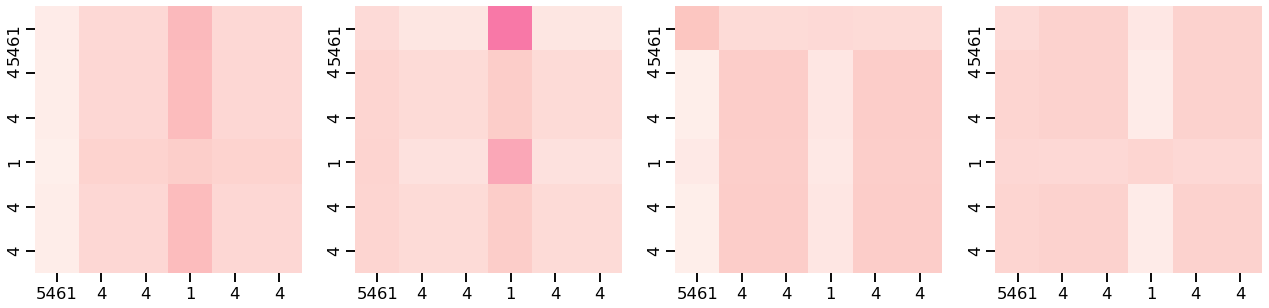



Ejemplo de tweet con label  support  y Tw_id  767727622046511104
Encoder Layer 1


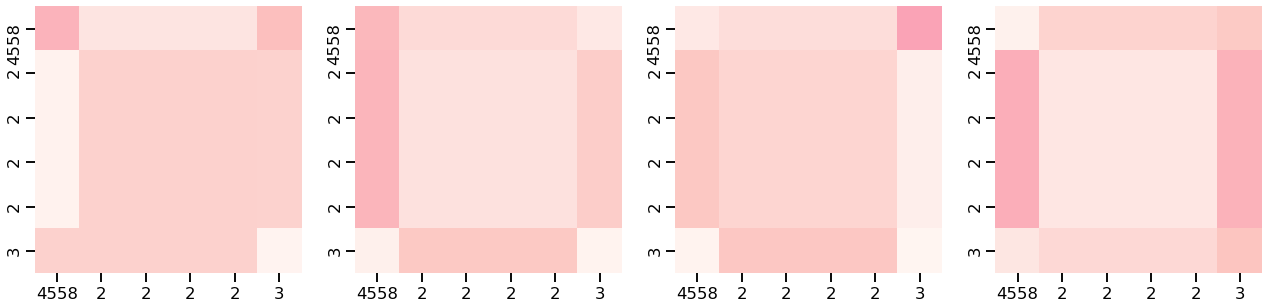

Encoder Layer 2


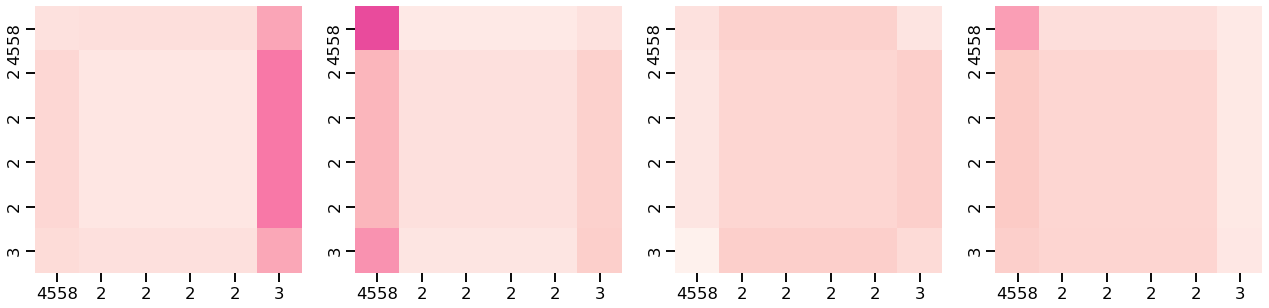



Ejemplo de tweet con label  denying  y Tw_id  765171900683161601
Encoder Layer 1


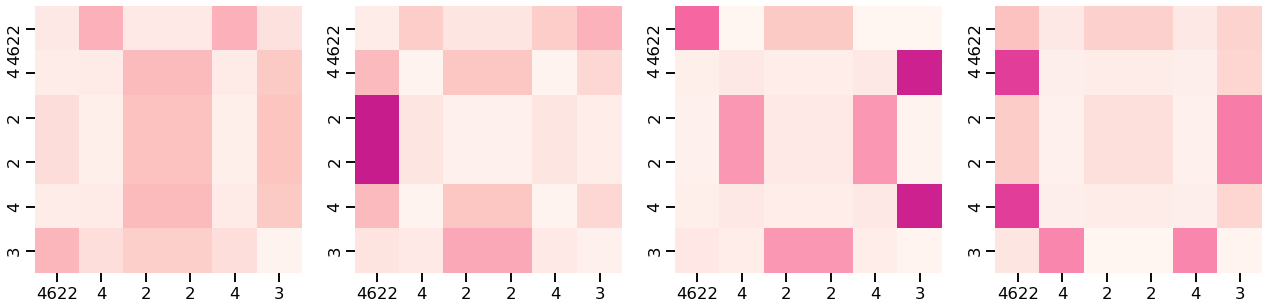

Encoder Layer 2


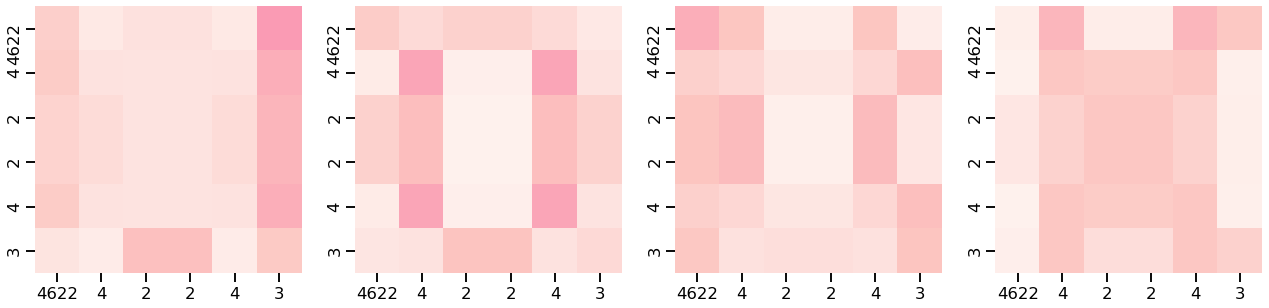



Ejemplo de tweet con label  questioning  y Tw_id  524948710942588928
Encoder Layer 1


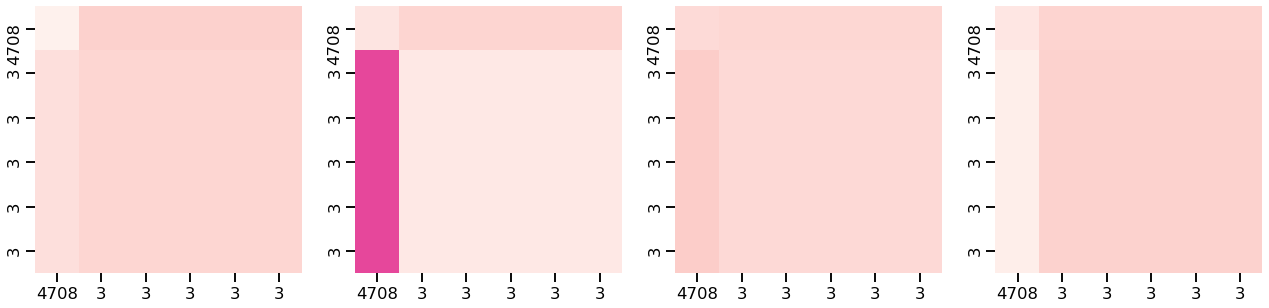

Encoder Layer 2


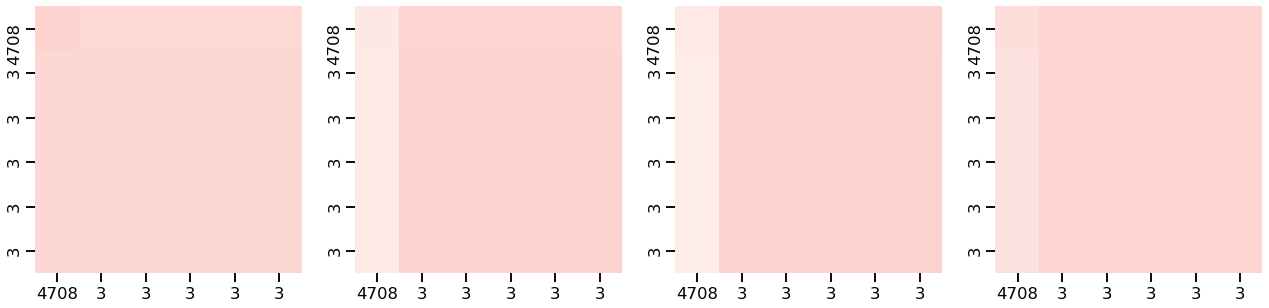

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 15
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.135 	F-macro_val: 0.127
Epoch 10 	acc_val: 0.642 	F-macro_val: 0.520
Epoch 20 	acc_val: 0.656 	F-macro_val: 0.531
Testing run # 15
SE TUVIERON QUE REPETIR 3 EJEMPLOS


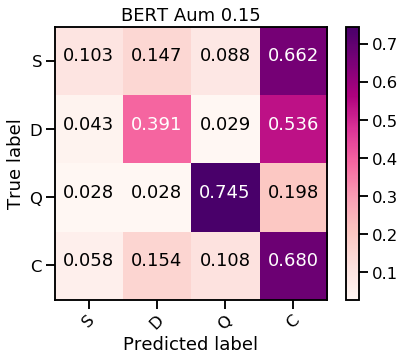

Test_ acc: 0.6287952987267384
Test_ f1 none: [0.111 0.236 0.57  0.75 ]
Test_ f1 macro: 0.4169176733038888
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 16
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.240 	F-macro_val: 0.162
Epoch 10 	acc_val: 0.625 	F-macro_val: 0.472
Epoch 20 	acc_val: 0.656 	F-macro_val: 0.482
Testing run # 16
SE TUVIERON QUE REPETIR 3 EJEMPLOS


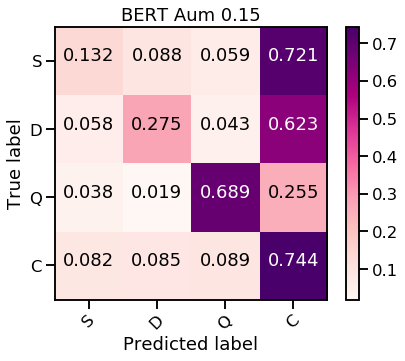

Test_ acc: 0.6660137120470128
Test_ f1 none: [0.121 0.235 0.573 0.785]
Test_ f1 macro: 0.4281187838745958
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 17
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.108 	F-macro_val: 0.090
Epoch 10 	acc_val: 0.642 	F-macro_val: 0.488
Epoch 20 	acc_val: 0.642 	F-macro_val: 0.489
Testing run # 17
SE TUVIERON QUE REPETIR 3 EJEMPLOS


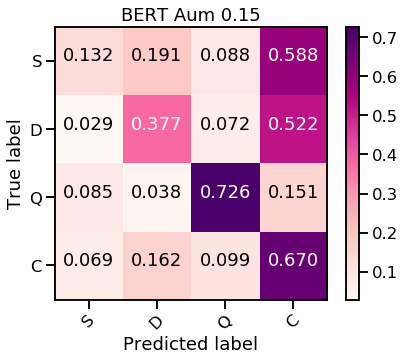

Test_ acc: 0.6199804113614104
Test_ f1 none: [0.127 0.218 0.568 0.749]
Test_ f1 macro: 0.41565375172972185
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 18
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.226 	F-macro_val: 0.144
Epoch 10 	acc_val: 0.694 	F-macro_val: 0.554
Epoch 20 	acc_val: 0.701 	F-macro_val: 0.543
Testing run # 18
SE TUVIERON QUE REPETIR 3 EJEMPLOS


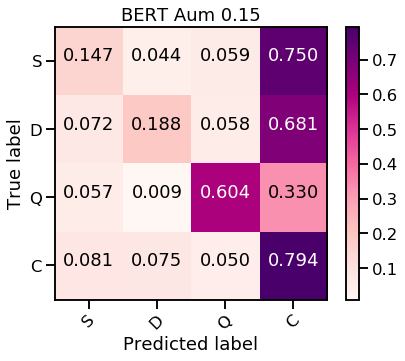

Test_ acc: 0.6904995102840352
Test_ f1 none: [0.132 0.181 0.59  0.808]
Test_ f1 macro: 0.4275919346766319
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 19
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.101 	F-macro_val: 0.091
Epoch 10 	acc_val: 0.698 	F-macro_val: 0.549
Epoch 20 	acc_val: 0.701 	F-macro_val: 0.534
Testing run # 19
SE TUVIERON QUE REPETIR 3 EJEMPLOS


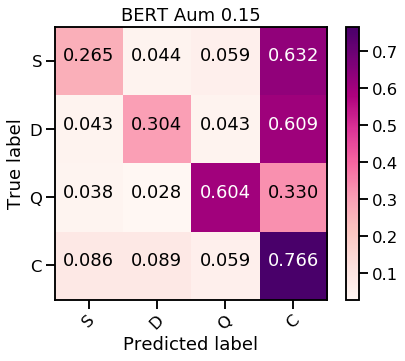

Test_ acc: 0.6846229187071499
Test_ f1 none: [0.225 0.255 0.574 0.798]
Test_ f1 macro: 0.46284864624962685


Ejemplo de tweet con label  commenting  y Tw_id  544295899585732609
Encoder Layer 1


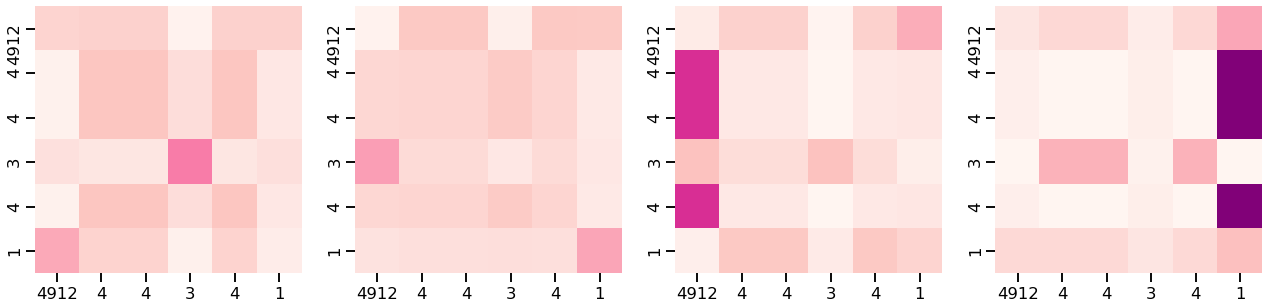

Encoder Layer 2


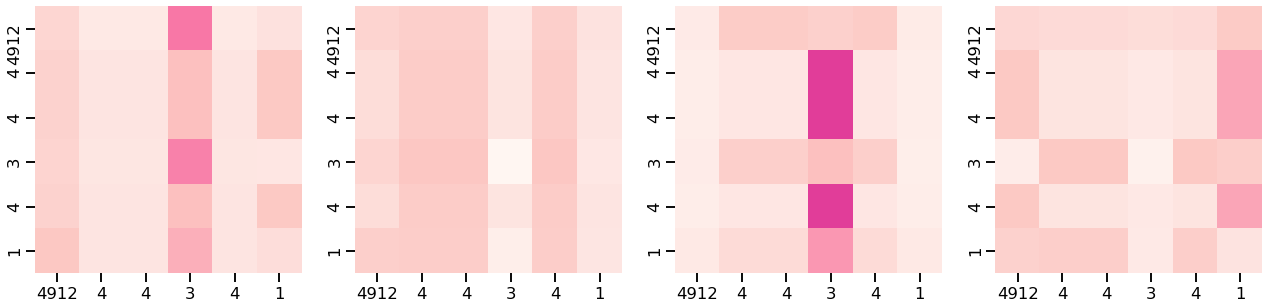



Ejemplo de tweet con label  support  y Tw_id  774992054883540992
Encoder Layer 1


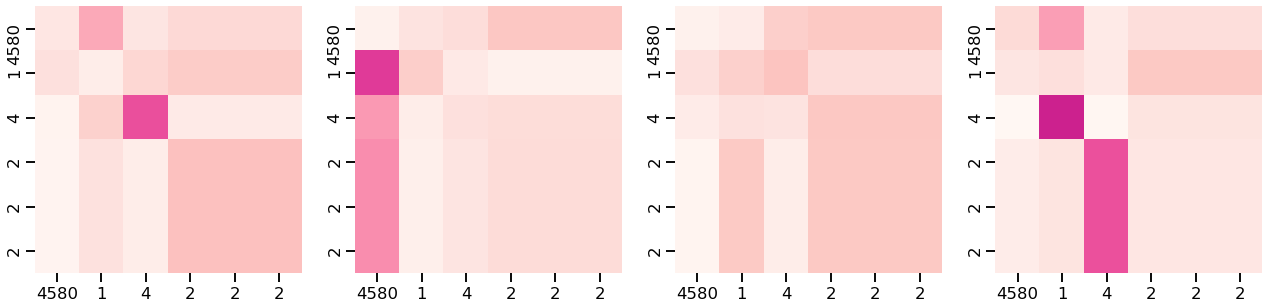

Encoder Layer 2


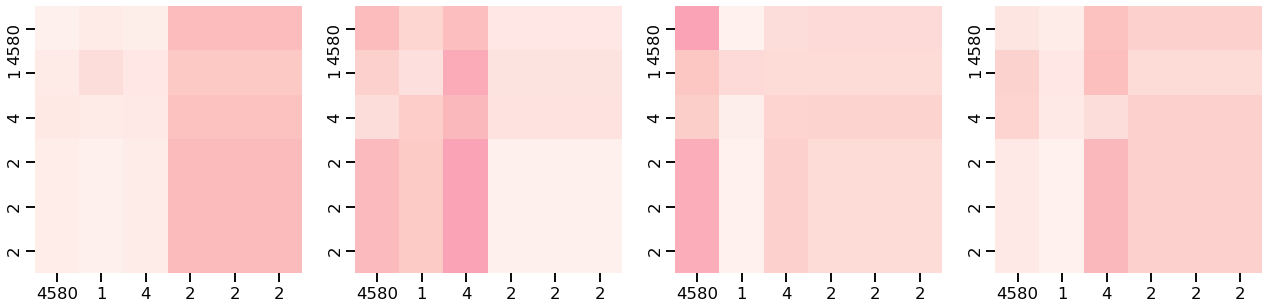



Ejemplo de tweet con label  denying  y Tw_id  764944029922590720
Encoder Layer 1


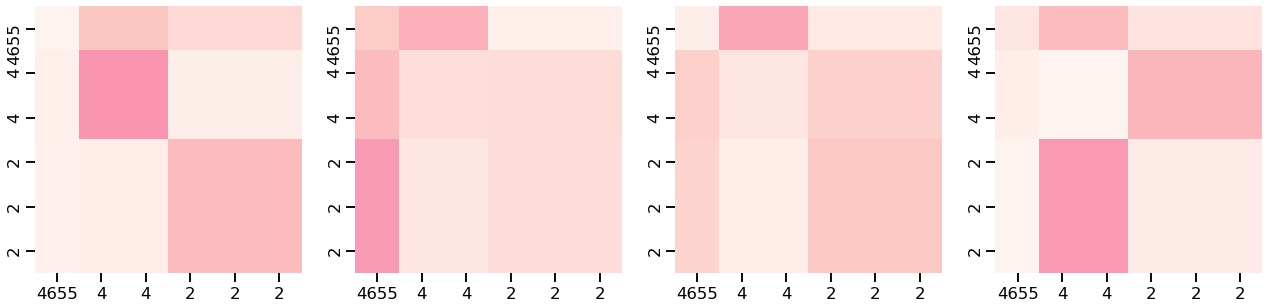

Encoder Layer 2


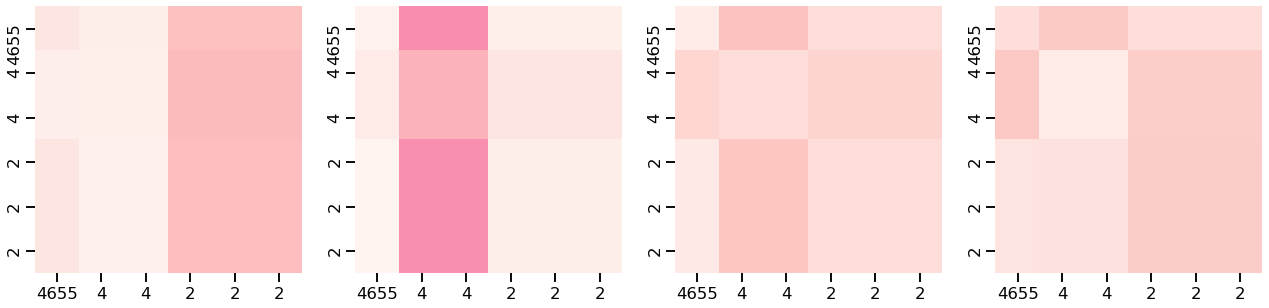



Ejemplo de tweet con label  questioning  y Tw_id  581363347041460224
Encoder Layer 1


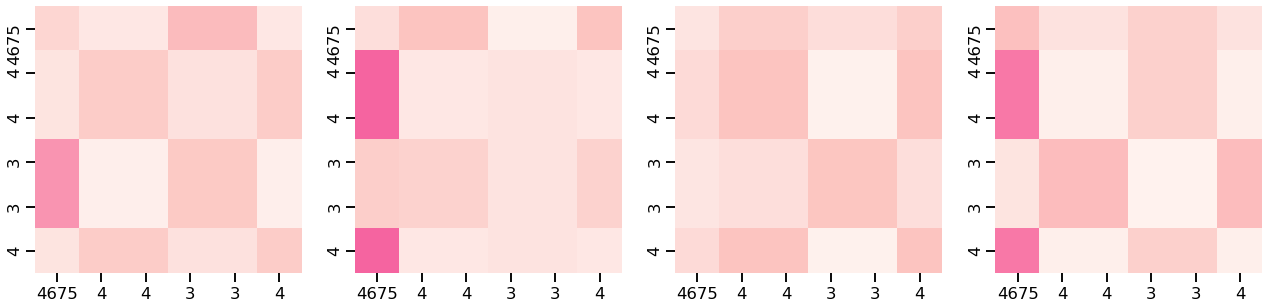

Encoder Layer 2


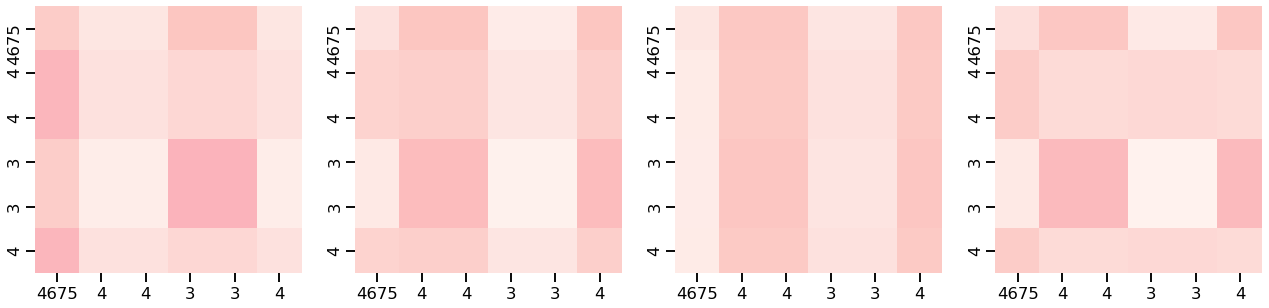

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 20
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.087 	F-macro_val: 0.075
Epoch 10 	acc_val: 0.663 	F-macro_val: 0.541
Epoch 20 	acc_val: 0.670 	F-macro_val: 0.525
Testing run # 20
SE TUVIERON QUE REPETIR 3 EJEMPLOS


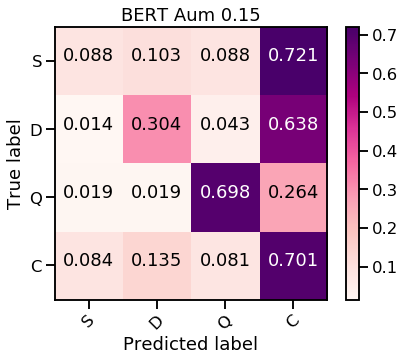

Test_ acc: 0.6327130264446621
Test_ f1 none: [0.085 0.206 0.587 0.755]
Test_ f1 macro: 0.40813465698141194


In [32]:
best_50, all_accs_50, all_fno_50, all_ma_50, all_cm_50 =train_transformer(0.5, 30, path_a, path_m, "RdPu")

In [33]:
print ("best_50", best_50)
print ("all_accs_50", all_accs_50)
print ("all_fno_50", all_fno_50)
print ("all_ma_50", all_ma_50)

best_50 {'F_ma': 0.46284864624962685, 'Run': 19}
all_accs_50 [0.6415279138099902, 0.6640548481880509, 0.6474045053868757, 0.6101860920666013, 0.6229187071498531, 0.6679725759059746, 0.623898139079334, 0.6444662095984329, 0.6082272282076395, 0.67384916748286, 0.6591576885406464, 0.633692458374143, 0.6591576885406464, 0.6856023506366308, 0.6287952987267384, 0.6660137120470128, 0.6199804113614104, 0.6904995102840352, 0.6846229187071499, 0.6327130264446621]
all_fno_50 [array([0.168, 0.222, 0.584, 0.765]), array([0.109, 0.256, 0.611, 0.783]), array([0.092, 0.241, 0.576, 0.77 ]), array([0.125, 0.218, 0.566, 0.737]), array([0.204, 0.25 , 0.559, 0.745]), array([0.15 , 0.201, 0.629, 0.783]), array([0.203, 0.223, 0.558, 0.746]), array([0.191, 0.25 , 0.611, 0.765]), array([0.101, 0.251, 0.586, 0.732]), array([0.142, 0.275, 0.584, 0.789]), array([0.153, 0.18 , 0.591, 0.78 ]), array([0.097, 0.195, 0.634, 0.757]), array([0.153, 0.262, 0.609, 0.773]), array([0.19 , 0.216, 0.635, 0.804]), array([0.111

Acc: 0.648 -- deviation: 0.025
F-score: 0.433 -- deviation: 0.016
(0.5) SDQC: 0.14389087498253855 0.2284696113647537 0.5897791212683615 0.7687147808534674


Confusion counts
[[  226.   158.    85.   891.]
 [   70.   447.    89.   774.]
 [   81.    53.  1482.   504.]
 [ 1350.  1869.  1259. 11082.]]


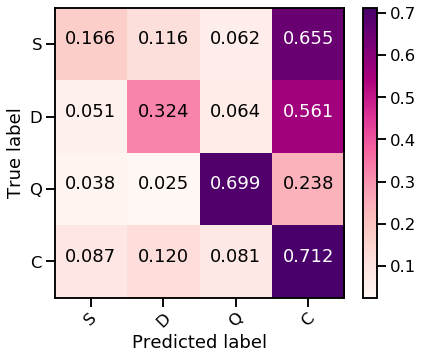

In [34]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_50)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_50)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_50)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_50)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_50)[:,0])
den=np.mean(np.asarray(all_fno_50)[:,1])
que=np.mean(np.asarray(all_fno_50)[:,2])
com=np.mean(np.asarray(all_fno_50)[:,3])

print ("(0.5) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_50:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S","D","Q","C"], "", cmap='RdPu')

## 0.85 -- 10 run

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.535 	F-macro_val: 0.265
Epoch 10 	acc_val: 0.705 	F-macro_val: 0.516
Epoch 20 	acc_val: 0.708 	F-macro_val: 0.526
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


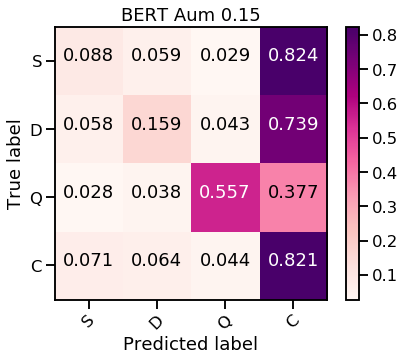

Test_ acc: 0.7002938295788442
Test_ f1 none: [0.088 0.159 0.578 0.817]
Test_ f1 macro: 0.4108056265984654


Ejemplo de tweet con label  commenting  y Tw_id  767728097928052736
Encoder Layer 1


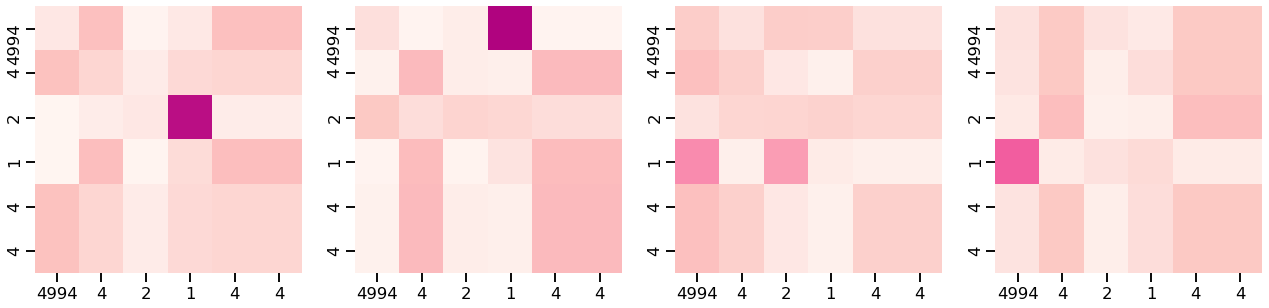

Encoder Layer 2


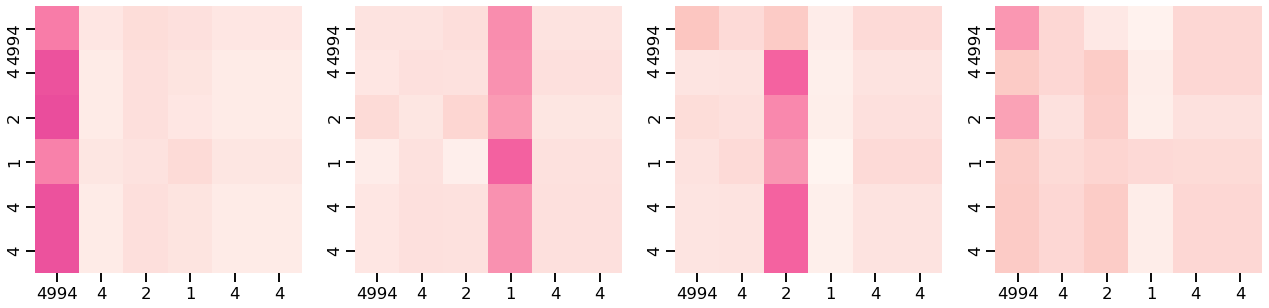



Ejemplo de tweet con label  support  y Tw_id  544275255163125760
Encoder Layer 1


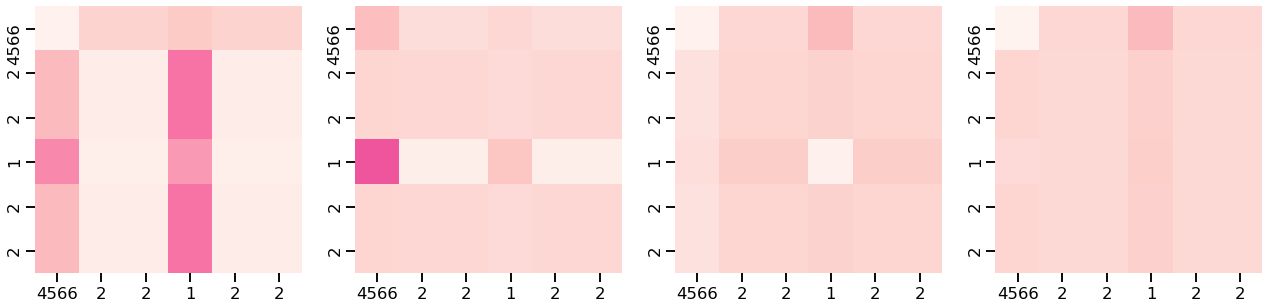

Encoder Layer 2


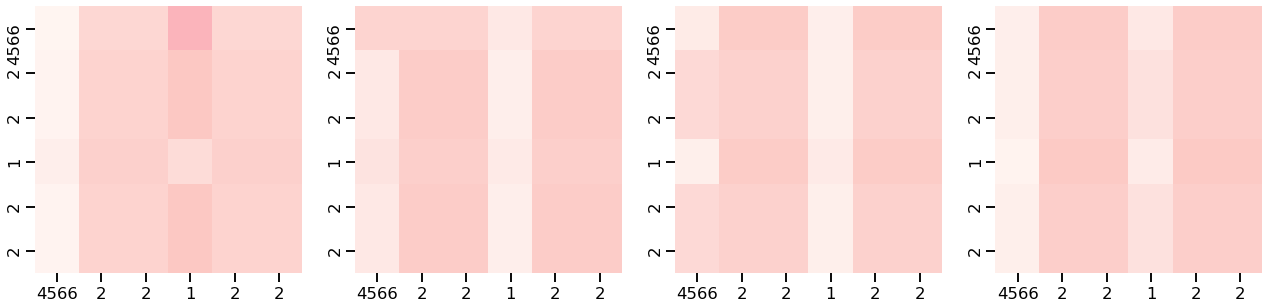



Ejemplo de tweet con label  denying  y Tw_id  764958204493176832
Encoder Layer 1


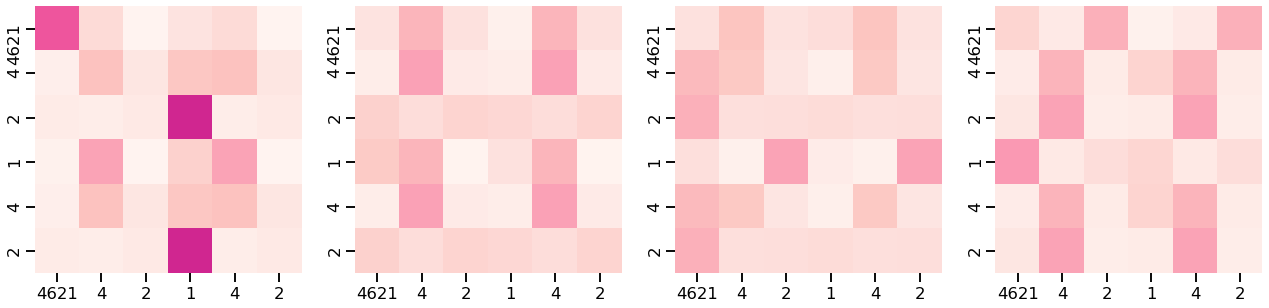

Encoder Layer 2


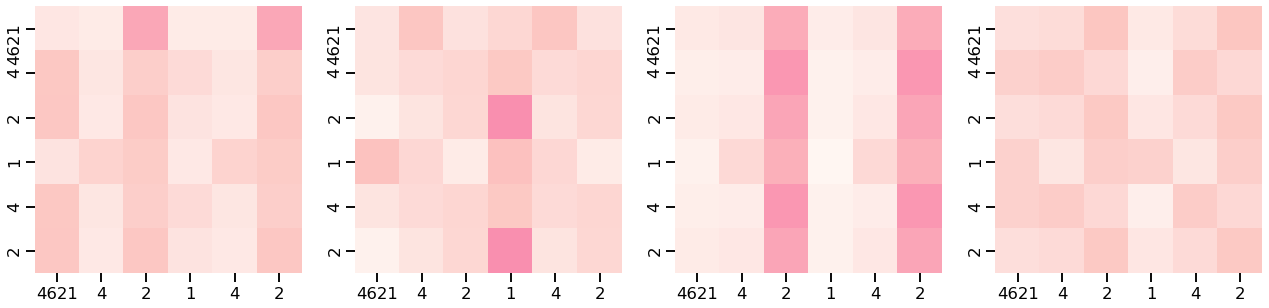



Ejemplo de tweet con label  questioning  y Tw_id  768313868175089664
Encoder Layer 1


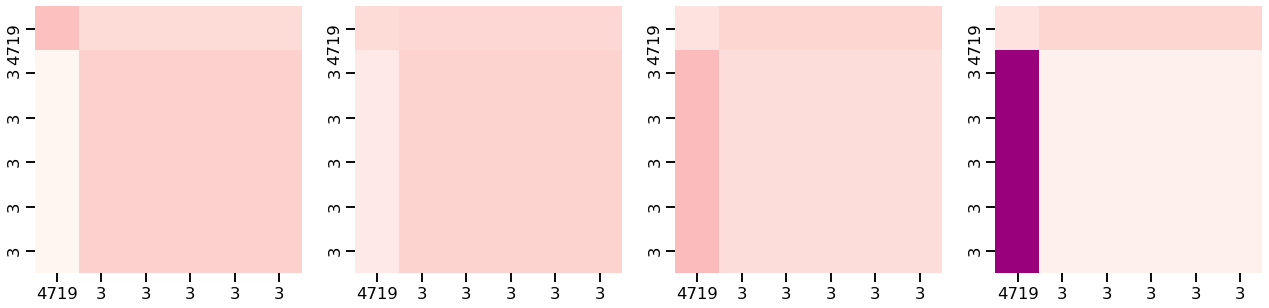

Encoder Layer 2


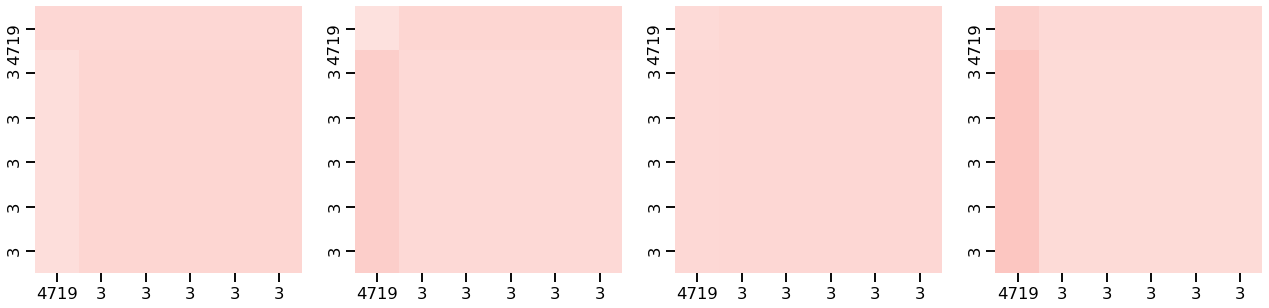

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.226 	F-macro_val: 0.139
Epoch 10 	acc_val: 0.681 	F-macro_val: 0.502
Epoch 20 	acc_val: 0.688 	F-macro_val: 0.501
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


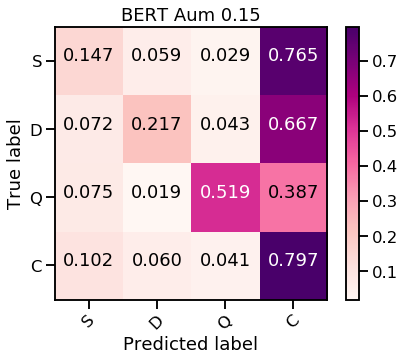

Test_ acc: 0.6856023506366308
Test_ f1 none: [0.118 0.219 0.556 0.807]
Test_ f1 macro: 0.4247367861688918


Ejemplo de tweet con label  commenting  y Tw_id  770234243356233728
Encoder Layer 1


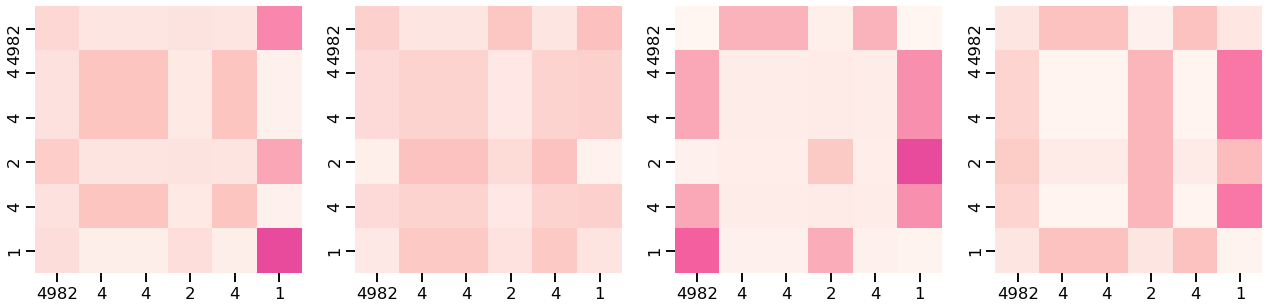

Encoder Layer 2


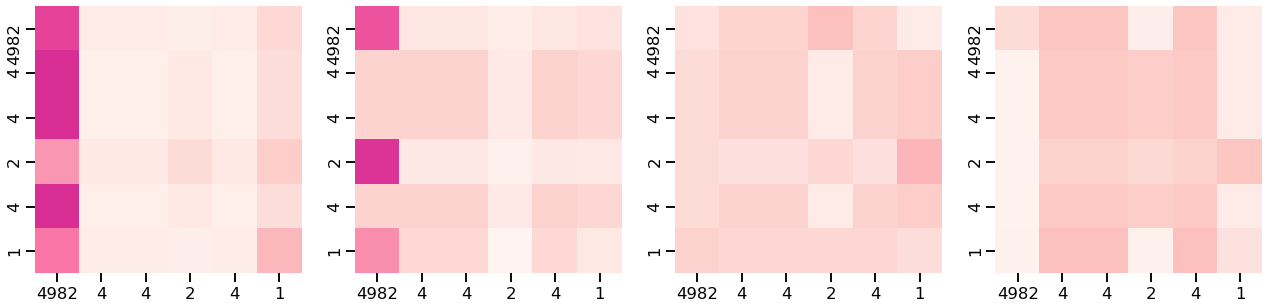



Ejemplo de tweet con label  support  y Tw_id  498298019045847040
Encoder Layer 1


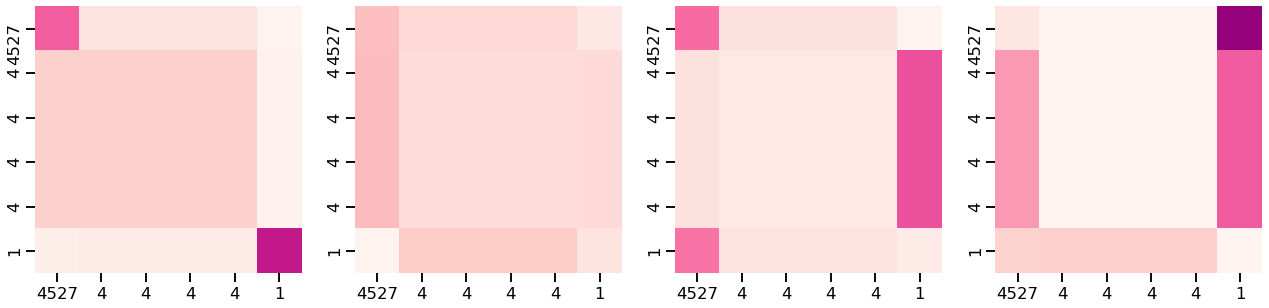

Encoder Layer 2


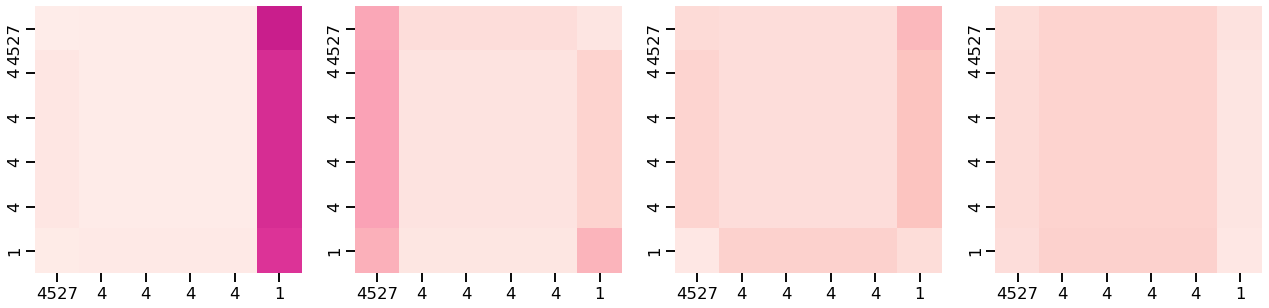



Ejemplo de tweet con label  denying  y Tw_id  770304212844613632
Encoder Layer 1


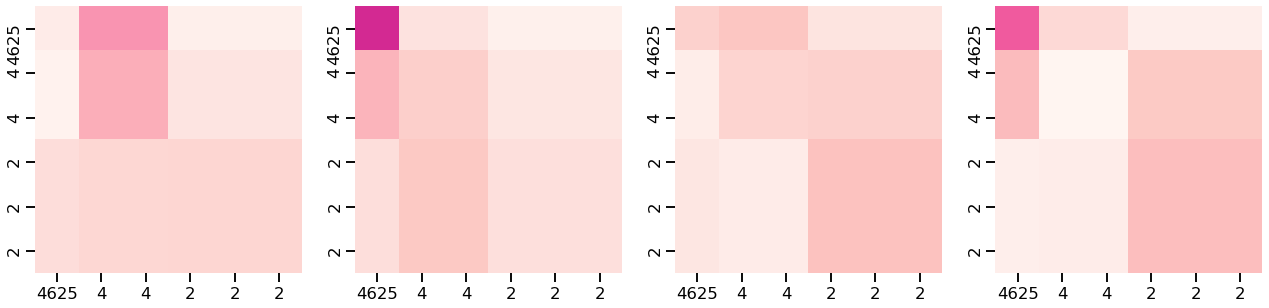

Encoder Layer 2


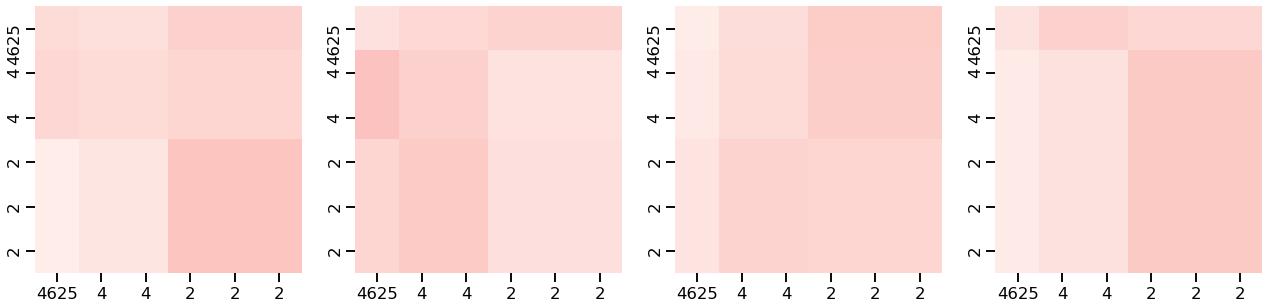



Ejemplo de tweet con label  questioning  y Tw_id  553561563710644224
Encoder Layer 1


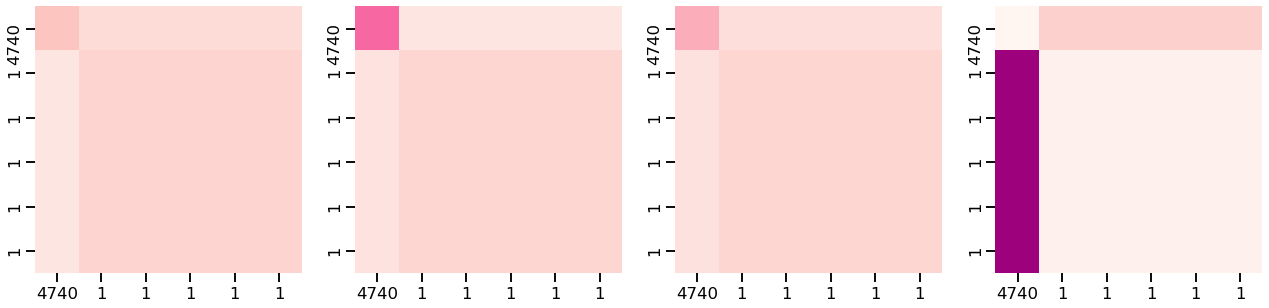

Encoder Layer 2


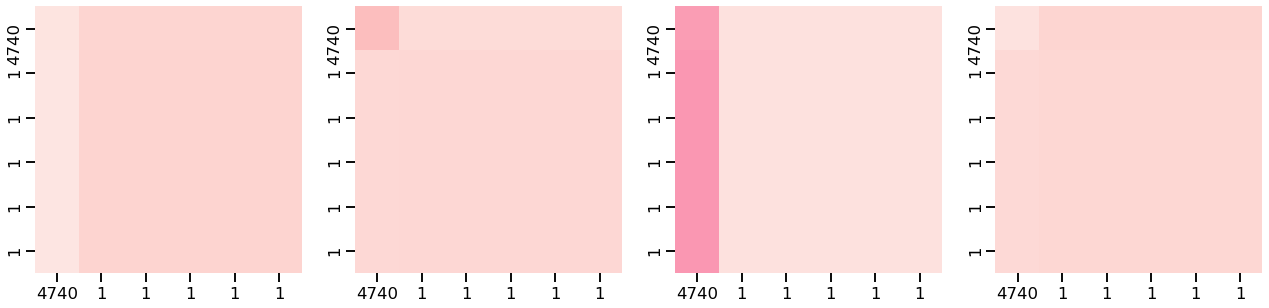

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.219 	F-macro_val: 0.181
Epoch 10 	acc_val: 0.663 	F-macro_val: 0.515
Epoch 20 	acc_val: 0.681 	F-macro_val: 0.519
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


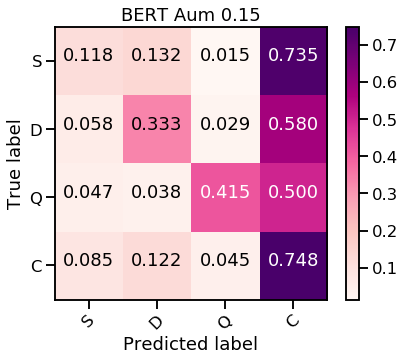

Test_ acc: 0.643486777668952
Test_ f1 none: [0.106 0.23  0.468 0.774]
Test_ f1 macro: 0.3946241172720081
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.253 	F-macro_val: 0.172
Epoch 10 	acc_val: 0.681 	F-macro_val: 0.512
Epoch 20 	acc_val: 0.684 	F-macro_val: 0.518
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


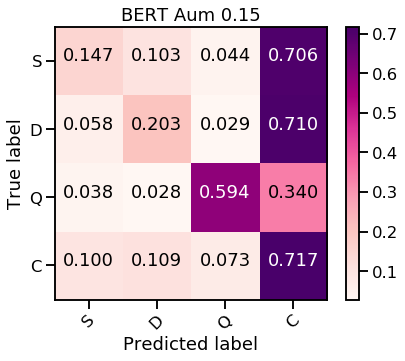

Test_ acc: 0.6317335945151812
Test_ f1 none: [0.122 0.157 0.545 0.76 ]
Test_ f1 macro: 0.3961024030669733
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.236 	F-macro_val: 0.177
Epoch 10 	acc_val: 0.691 	F-macro_val: 0.513
Epoch 20 	acc_val: 0.688 	F-macro_val: 0.515
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


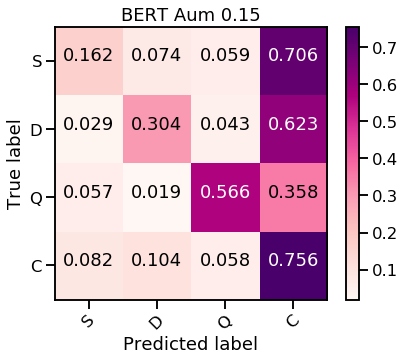

Test_ acc: 0.6660137120470128
Test_ f1 none: [0.146 0.236 0.55  0.787]
Test_ f1 macro: 0.42968280239827783


Ejemplo de tweet con label  commenting  y Tw_id  764951944934731776
Encoder Layer 1


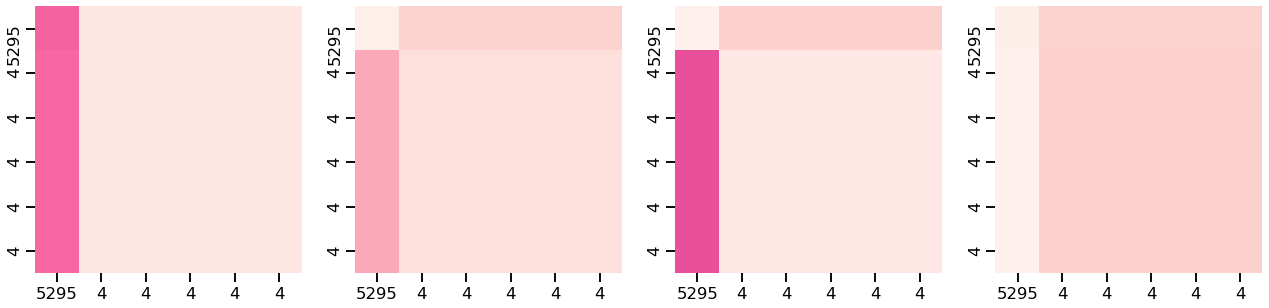

Encoder Layer 2


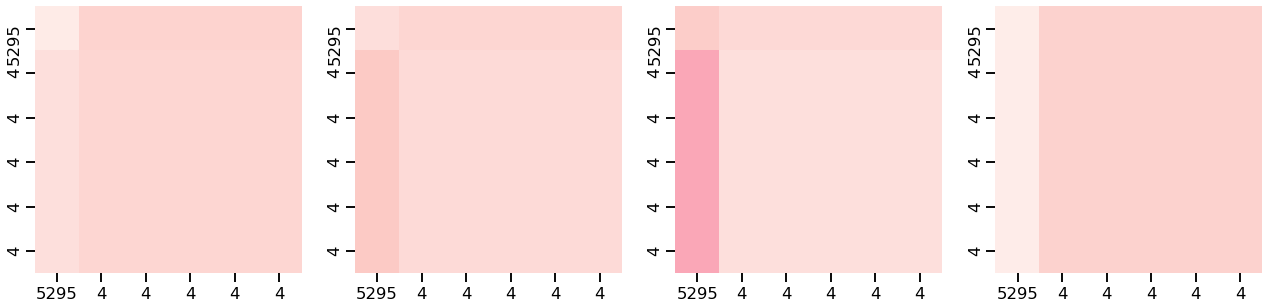



Ejemplo de tweet con label  support  y Tw_id  581290541645635584
Encoder Layer 1


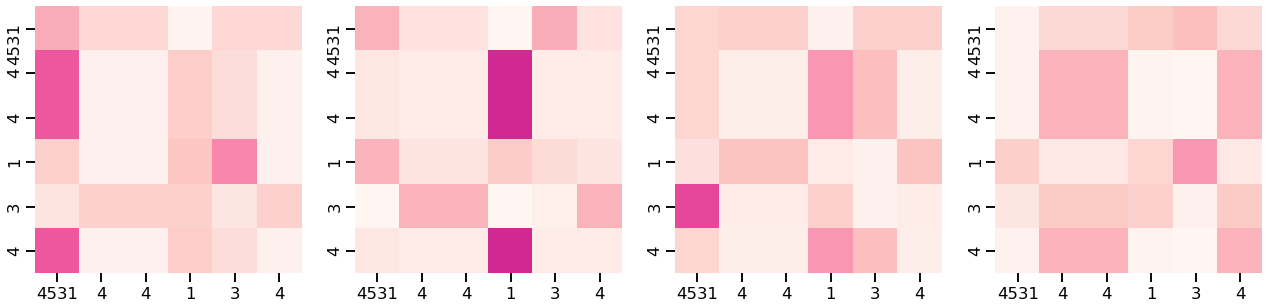

Encoder Layer 2


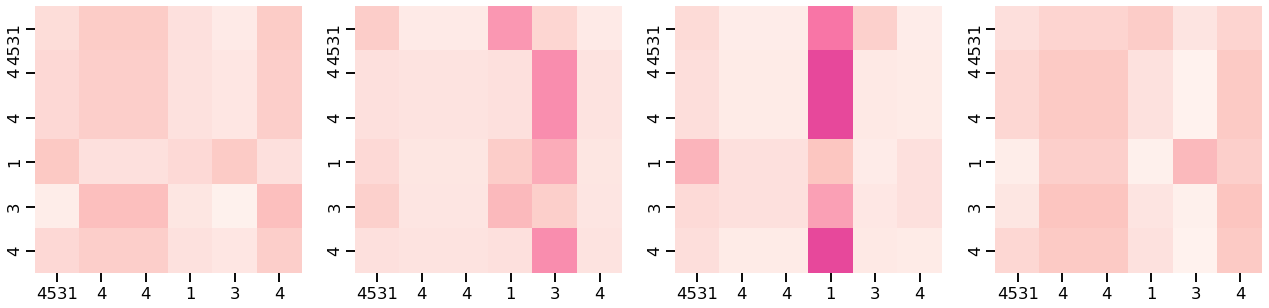



Ejemplo de tweet con label  denying  y Tw_id  769989019627290624
Encoder Layer 1


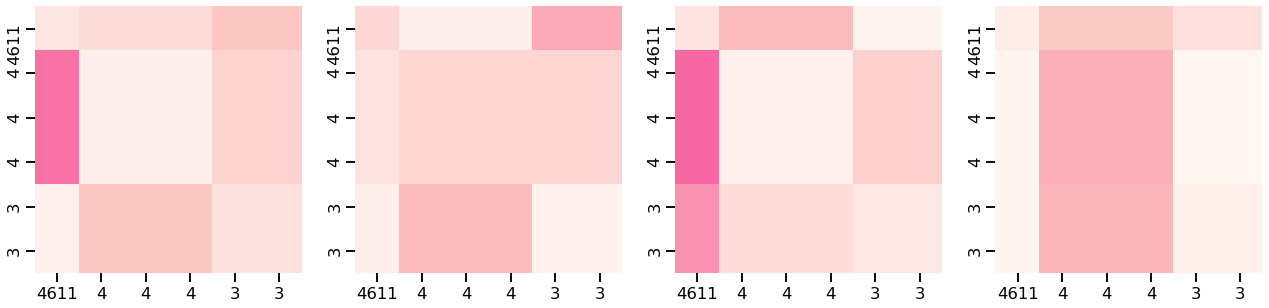

Encoder Layer 2


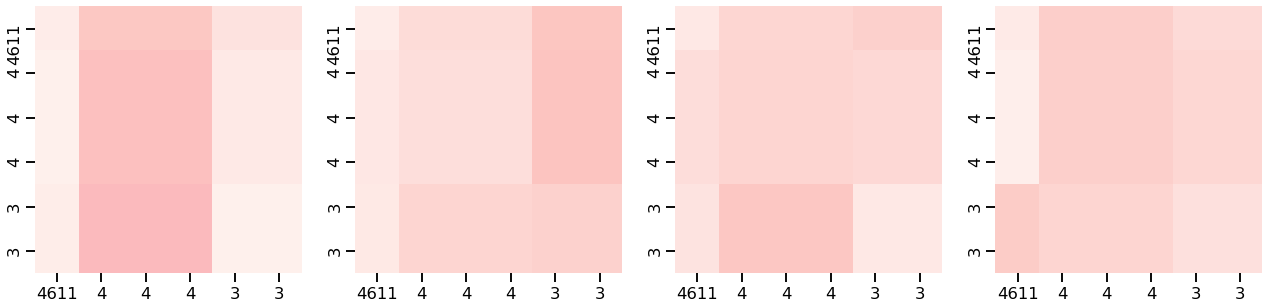



Ejemplo de tweet con label  questioning  y Tw_id  767727443398451200
Encoder Layer 1


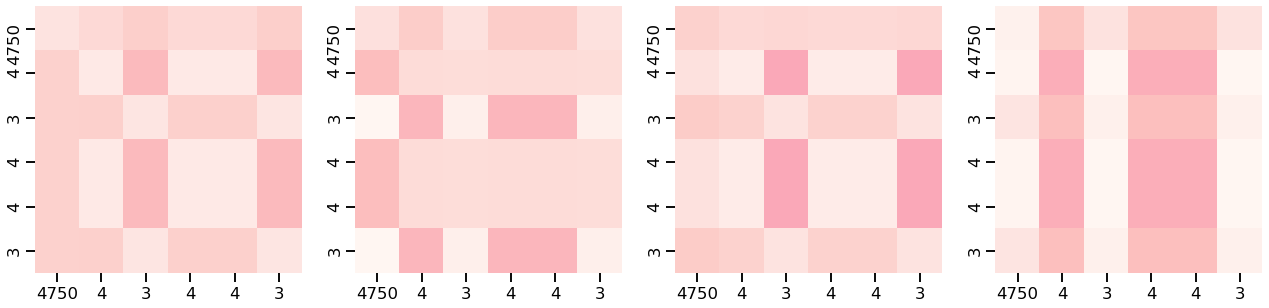

Encoder Layer 2


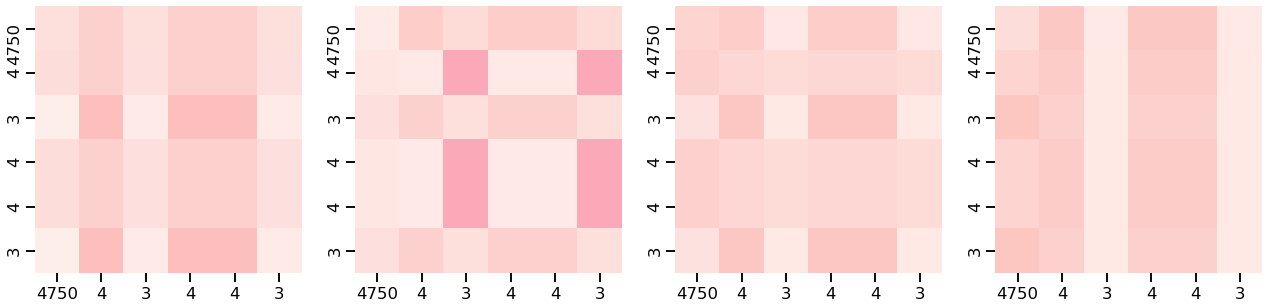

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.177 	F-macro_val: 0.147
Epoch 10 	acc_val: 0.667 	F-macro_val: 0.523
Epoch 20 	acc_val: 0.667 	F-macro_val: 0.519
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


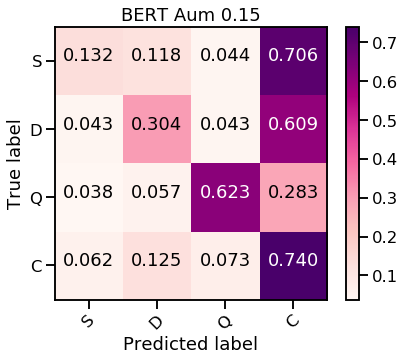

Test_ acc: 0.6581782566111655
Test_ f1 none: [0.136 0.209 0.562 0.782]
Test_ f1 macro: 0.42214194982534137
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.208 	F-macro_val: 0.154
Epoch 10 	acc_val: 0.694 	F-macro_val: 0.545
Epoch 20 	acc_val: 0.705 	F-macro_val: 0.540
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


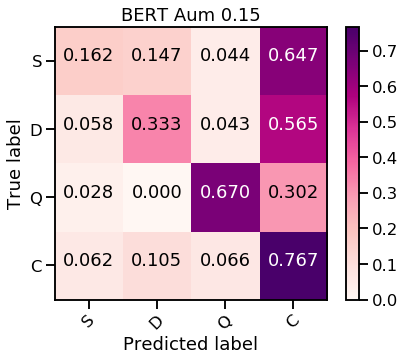

Test_ acc: 0.6875612144955926
Test_ f1 none: [0.164 0.25  0.607 0.801]
Test_ f1 macro: 0.4555897482986033


Ejemplo de tweet con label  commenting  y Tw_id  775084898595987457
Encoder Layer 1


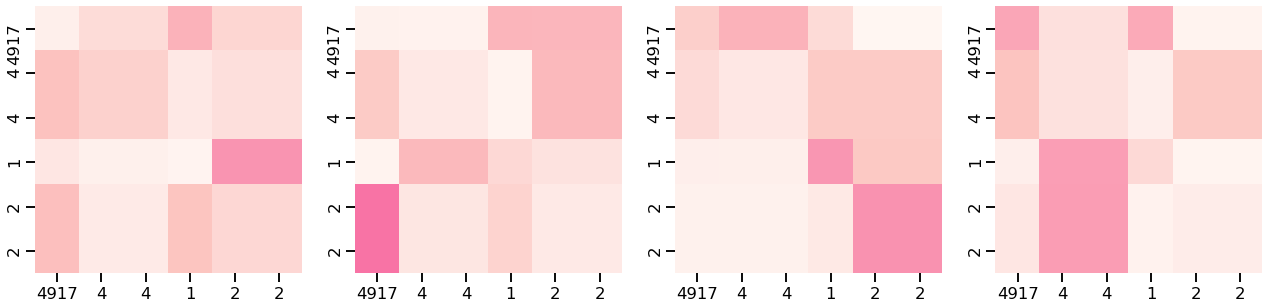

Encoder Layer 2


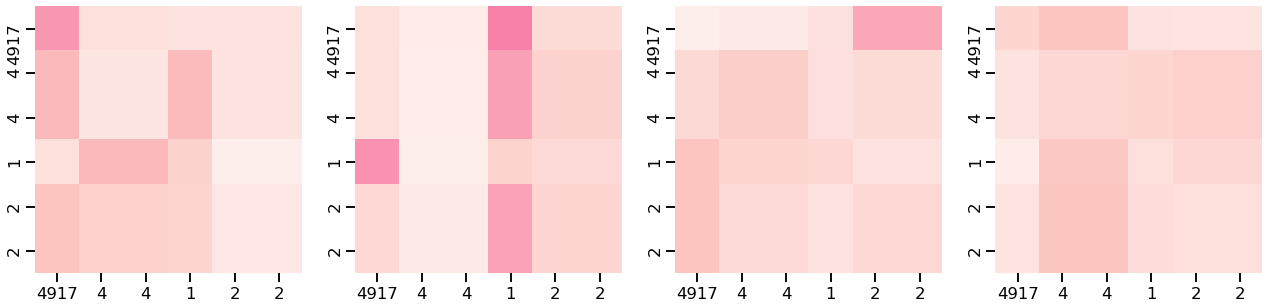



Ejemplo de tweet con label  support  y Tw_id  775075528554389504
Encoder Layer 1


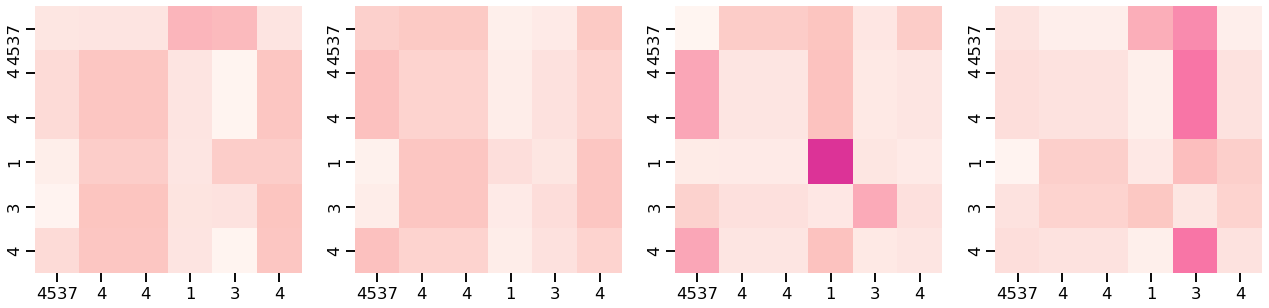

Encoder Layer 2


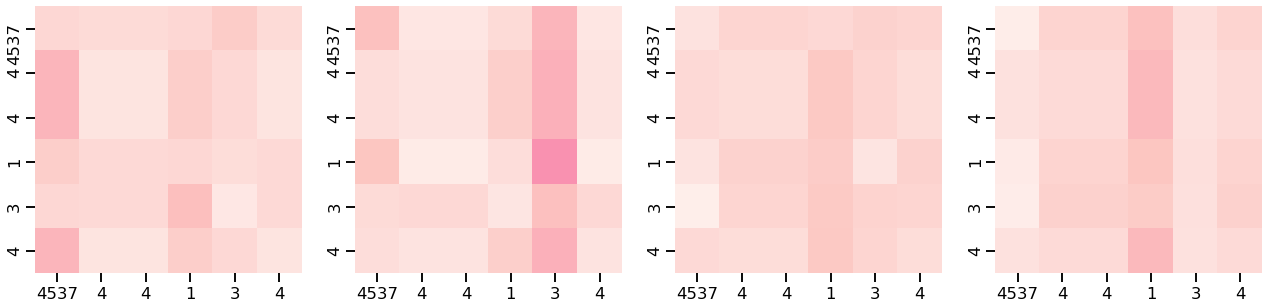



Ejemplo de tweet con label  denying  y Tw_id  580354345935486976
Encoder Layer 1


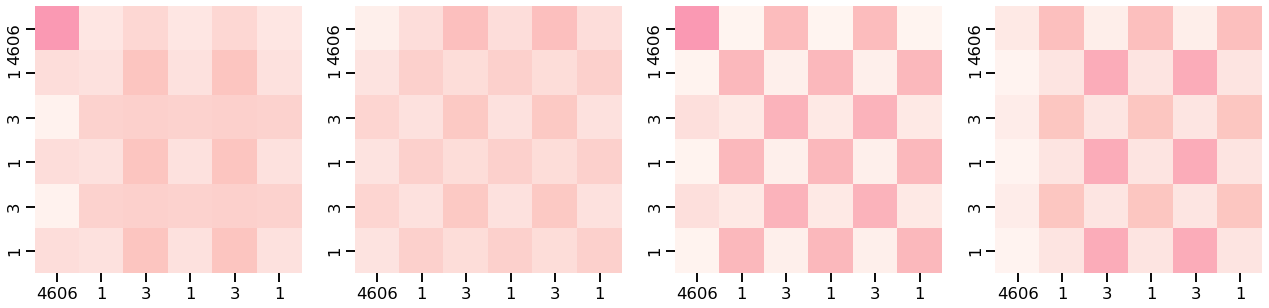

Encoder Layer 2


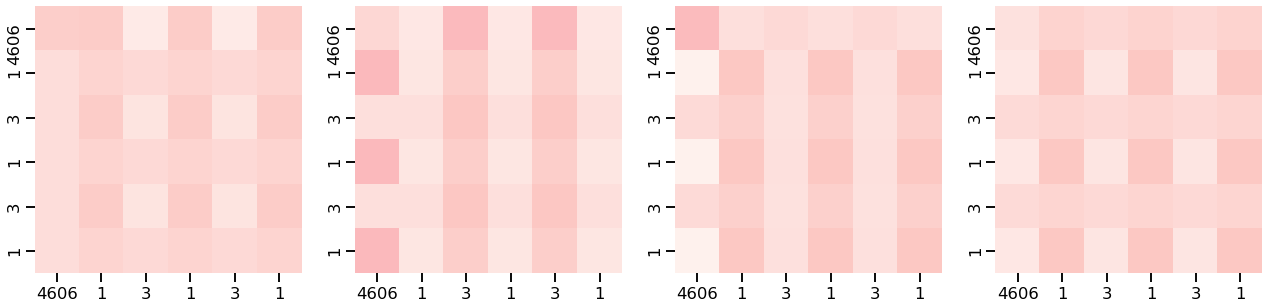



Ejemplo de tweet con label  questioning  y Tw_id  580359656750653441
Encoder Layer 1


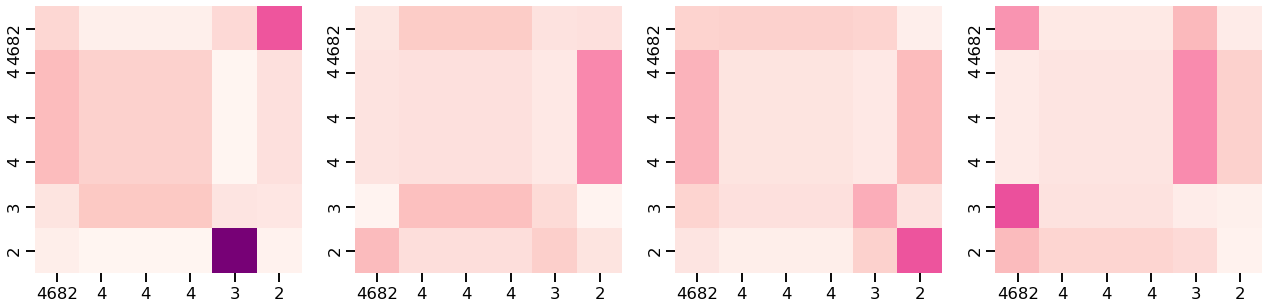

Encoder Layer 2


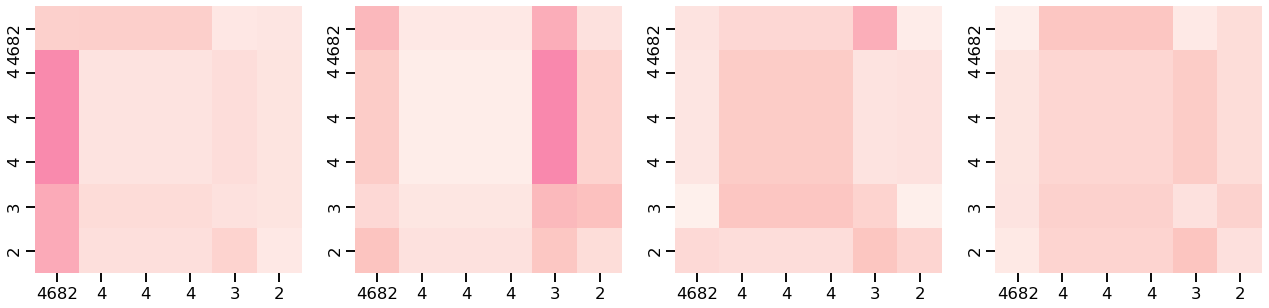

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.198 	F-macro_val: 0.152
Epoch 10 	acc_val: 0.649 	F-macro_val: 0.484
Epoch 20 	acc_val: 0.660 	F-macro_val: 0.480
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


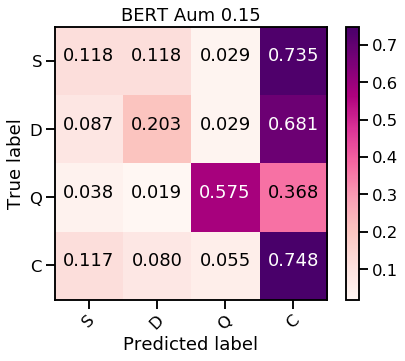

Test_ acc: 0.6513222331047992
Test_ f1 none: [0.09  0.181 0.57  0.778]
Test_ f1 macro: 0.40480224144259924
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.135 	F-macro_val: 0.150
Epoch 10 	acc_val: 0.719 	F-macro_val: 0.536
Epoch 20 	acc_val: 0.729 	F-macro_val: 0.535
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


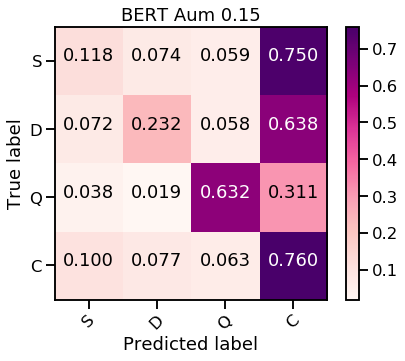

Test_ acc: 0.6679725759059746
Test_ f1 none: [0.098 0.211 0.583 0.79 ]
Test_ f1 macro: 0.4202184197401837
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.160 	F-macro_val: 0.139
Epoch 10 	acc_val: 0.688 	F-macro_val: 0.526
Epoch 20 	acc_val: 0.681 	F-macro_val: 0.535
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


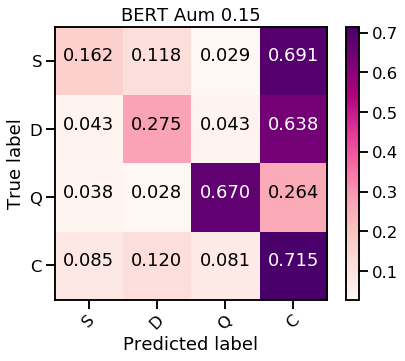

Test_ acc: 0.643486777668952
Test_ f1 none: [0.145 0.198 0.58  0.765]
Test_ f1 macro: 0.4218896226808541


In [36]:
### solo 10!! 
best_85, all_accs_85, all_fno_85, all_ma_85, all_cm_85 =train_transformer(0.85, 30, path_a, path_m, "RdPu", xfrom=1, xto=10)

In [37]:
print ("best_85", best_85)
print ("all_accs_85", all_accs_85)
print ("all_fno_85", all_fno_85)
print ("all_ma_85", all_ma_85)

best_85 {'F_ma': 0.4555897482986033, 'Run': 7}
all_accs_85 [0.7002938295788442, 0.6856023506366308, 0.643486777668952, 0.6317335945151812, 0.6660137120470128, 0.6581782566111655, 0.6875612144955926, 0.6513222331047992, 0.6679725759059746, 0.643486777668952]
all_fno_85 [array([0.088, 0.159, 0.578, 0.817]), array([0.118, 0.219, 0.556, 0.807]), array([0.106, 0.23 , 0.468, 0.774]), array([0.122, 0.157, 0.545, 0.76 ]), array([0.146, 0.236, 0.55 , 0.787]), array([0.136, 0.209, 0.562, 0.782]), array([0.164, 0.25 , 0.607, 0.801]), array([0.09 , 0.181, 0.57 , 0.778]), array([0.098, 0.211, 0.583, 0.79 ]), array([0.145, 0.198, 0.58 , 0.765])]
all_ma_85 [0.4108056265984654, 0.4247367861688918, 0.3946241172720081, 0.3961024030669733, 0.42968280239827783, 0.42214194982534137, 0.4555897482986033, 0.40480224144259924, 0.4202184197401837, 0.4218896226808541]


Acc: 0.664 -- deviation: 0.021
F-score: 0.418 -- deviation: 0.017
(0.85) SDQC: 0.12133237739673985 0.20497001866382053 0.5598819020366402 0.7860531888996786


Confusion counts
[[  92.   68.   26.  494.]
 [  40.  177.   28.  445.]
 [  45.   28.  617.  370.]
 [ 673.  752.  466. 5889.]]


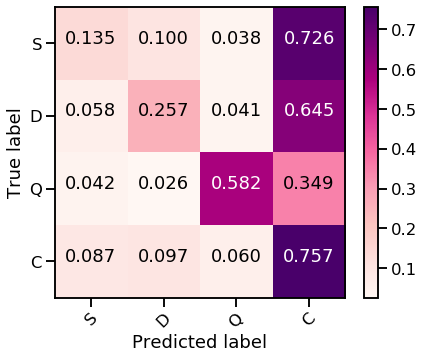

In [38]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_85)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_85)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_85)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_85)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_85)[:,0])
den=np.mean(np.asarray(all_fno_85)[:,1])
que=np.mean(np.asarray(all_fno_85)[:,2])
com=np.mean(np.asarray(all_fno_85)[:,3])

print ("(0.85) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_85:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S","D","Q","C"], "", cmap='RdPu')